# irp-dbk24 - "Optimising Demand Response Strategies for Carbon-Intelligent Electricity Use"

# STEP 6 Analysis

### Importing Libraries

In [15]:
# ─────────────────────────────────────────────────────────────────────────────
# Notebook/Display Tools
# ─────────────────────────────────────────────────────────────────────────────
from IPython.display import display
%matplotlib inline

# ────────────────────────────────────────────────────────────────────────────
# Data Manipulation & Analysis
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import polars as pl
import numpy as np
from zoneinfo import ZoneInfo

# ─────────────────────────────────────────────────────────────────────────────
# Geospatial Data Handling
# ─────────────────────────────────────────────────────────────────────────────
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.wkb import loads
from pyproj import Proj, transform

# ─────────────────────────────────────────────────────────────────────────────
# Visualization
# ─────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import folium
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from PIL import Image

# ─────────────────────────────────────────────────────────────────────────────
# System / Miscellaneous
# ─────────────────────────────────────────────────────────────────────────────
import os
import calendar
import binascii
import re
from functools import reduce
from typing import List, Tuple, Optional, Literal, Any
from datetime import datetime, timedelta
from pathlib import Path

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator, ScalarFormatter

### Directories, Filenames, Filepaths

In [16]:
# Base directory for data
base_data_directory = "data"
 # Directory for hitachi data
hitachi_data_directory = os.path.join(base_data_directory, "hitachi_copy")
optimisation_development_directory = os.path.join(base_data_directory, "optimisation_development")
marginal_emissions_development_directory = os.path.join(base_data_directory, "marginal_emissions_development")
marginal_emissions_results_directory = os.path.join(marginal_emissions_development_directory, "results")
# test_results_directory = os.path.join(optimisation_development_directory, "testing_results")
full_results_directory = os.path.join(optimisation_development_directory,"full_results")
optimisation_processing_directory = os.path.join(optimisation_development_directory,"processing_files")

In [17]:
# optimisation_development_directory = os.path.join(base_data_directory, "optimisation_development")
print(f"Contents of '{optimisation_development_directory}' and subdirectories:\n" + "-" * 120)
for root, dirs, files in sorted(os.walk(top=optimisation_development_directory)):
    for f in sorted(files):
        rel_dir = os.path.relpath(path=root, start=optimisation_development_directory)
        rel_file = os.path.join(rel_dir, f) if rel_dir != "." else f
        print(f"  - {rel_file}")

Contents of 'data/optimisation_development' and subdirectories:
------------------------------------------------------------------------------------------------------------------------
  - .DS_Store
  - average_emissions_2022-05-04_to_2022-05-18.parquet
  - marginal_and_average_emissions_2022-05-04_to_2022-05-18.parquet
  - marginal_emissions_2022-05-04_to_2022-05-18.parquet
  - meter_readings_2022-05-01_to_2022-05-14.parquet
  - meter_readings_2022-05-01_to_2022-05-14_with_marginal_emissions.parquet
  - meter_readings_2022-05-04_to_2022-05-18.parquet
  - meter_readings_all_years_20250714_formatted_with_emission_factors_filled.parquet
  - meter_readings_all_years_20250714_formatted_with_emission_factors_filled_2022-05-04_to_2022-05-18.parquet
  - meter_readings_all_years_20250714_formatted_with_pygam_cal_emission_factors_filled.parquet
  - meter_readings_all_years_20250714_formatted_with_pygam_emission_factors_filled.parquet
  - meter_readings_all_years_20250714_formatted_with_quantile

In [18]:
# Filenames
policy_2_greedy_metrics_filename =  "policy_2_greedy_metrics_20250828_203425"
policy_2_greedy_moves_filename = "policy_2_greedy_moves_20250828_203425"
policy_2_greedy_optimised_filename = "policy_2_greedy_optimised_20250828_203425"

# test_data_filename = "meter_readings_all_years_20250714_formatted_with_emission_factors_filled_2022-05-04_to_2022-05-18"

In [19]:
emission_factors = "pyGAM_marginal_emissions_timeseries"
emission_factors_full = "marginal_and_average_emissions_2021-01-01_to_2025-05-31"

In [20]:
# Filepaths
policy_2_greedy_metrics_filepath = os.path.join(full_results_directory, policy_2_greedy_metrics_filename + ".parquet")
policy_2_greedy_moves_filepath = os.path.join(full_results_directory, policy_2_greedy_moves_filename + ".parquet")
policy_2_greedy_optimised_filepath = os.path.join(full_results_directory, policy_2_greedy_optimised_filename + ".parquet")

emission_factors_filepath = os.path.join(marginal_emissions_results_directory, emission_factors + ".parquet")
emission_factors_full_filepath = os.path.join(optimisation_processing_directory, emission_factors_full + ".parquet")

# test_data_filepath = os.path.join(optimisation_development_directory, test_data_filename + ".parquet")

### Loading Data

In [21]:
policy_2_greedy_metrics_pldf = pl.read_parquet(source=policy_2_greedy_metrics_filepath)
policy_2_greedy_moves_pldf = pl.read_parquet(policy_2_greedy_moves_filepath)
# policy_2_greedy_optimised_pldf = pl.read_parquet(policy_2_greedy_optimised_filepath)

In [22]:
emission_factors_pldf = pl.read_parquet(source=emission_factors_filepath)

In [23]:
emission_factors_pldf

timestamp,land_latitude,land_longitude,y_true,y_pred,ME,city,demand_met,demand_minus_renewables,National MW Shift,Pearson R Score,Spearman Score,Confidence Level,ME_cal
"datetime[μs, Asia/Kolkata]",f64,f64,f64,f64,f64,cat,f64,f64,f64,f64,f64,str,f64
2021-01-01 00:00:00 IST,18.5,72.97,51887.3969,52785.092165,0.487644,"""mumbai""",129481.666667,120024.25,3102.666667,0.55606,0.587619,"""medium""",0.502544
2021-01-01 00:00:00 IST,18.6,72.97,51887.3969,52782.25982,0.487644,"""mumbai""",129481.666667,120024.25,3102.666667,0.55606,0.587619,"""medium""",0.502544
2021-01-01 00:00:00 IST,19.3,72.97,51887.3969,52763.59717,0.487644,"""mumbai""",129481.666667,120024.25,3102.666667,0.55606,0.587619,"""medium""",0.502544
2021-01-01 00:00:00 IST,19.1,72.87,51887.3969,52794.244424,0.487644,"""mumbai""",129481.666667,120024.25,3102.666667,0.55606,0.587619,"""medium""",0.502544
2021-01-01 00:00:00 IST,18.8,72.97,51887.3969,52779.495748,0.487644,"""mumbai""",129481.666667,120024.25,3102.666667,0.55606,0.587619,"""medium""",0.502544
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-05-31 23:30:00 IST,28.8,76.94,74410.90595,75220.296742,0.359818,"""delhi""",212822.75,187549.25,716.5,0.407424,0.490606,"""medium""",0.217991
2025-05-31 23:30:00 IST,28.8,77.04,74410.90595,75241.728732,0.359818,"""delhi""",212822.75,187549.25,716.5,0.407424,0.490606,"""medium""",0.217991
2025-05-31 23:30:00 IST,28.8,77.14,74410.90595,75267.927068,0.359818,"""delhi""",212822.75,187549.25,716.5,0.407424,0.490606,"""medium""",0.217991


In [24]:
emission_factors_full_pldf = pl.read_parquet(source=emission_factors_full_filepath)

In [25]:
emission_factors_full_pldf

average_emissions_grams_co2_per_kWh,timestamp,city,land_longitude,land_latitude,demand_met_kWh,quantile_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh_calibrated,National MW Shift,Pearson R Score,Spearman Score,Confidence Level
f64,"datetime[μs, Asia/Kolkata]",cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
681.636648,2022-09-13 03:30:00 IST,"""mumbai""",72.97,18.9,8.0111375e7,759.551296,857.821285,743.595963,987.166667,0.44016,0.510815,"""medium"""
692.319596,2022-09-13 22:30:00 IST,"""mumbai""",72.97,18.9,8.9905e7,777.687393,844.540427,714.031444,519.708333,0.362911,0.471026,"""low"""
702.264879,2022-09-14 05:30:00 IST,"""mumbai""",72.97,18.9,8.0648e7,826.443447,860.892919,750.433726,2397.541667,0.539221,0.575285,"""medium"""
703.804938,2022-09-14 06:30:00 IST,"""mumbai""",72.97,18.9,8.3406625e7,804.836474,874.967342,781.764801,3025.416667,0.554597,0.58668,"""medium"""
584.493172,2022-09-14 11:00:00 IST,"""mumbai""",72.97,18.9,8.9016e7,701.048907,875.800704,783.619948,1966.75,0.526001,0.564784,"""medium"""
…,…,…,…,…,…,…,…,…,…,…,…,…
574.82108,2024-07-24 11:30:00 IST,"""delhi""",77.24,28.8,1.0415e8,489.565394,856.686617,741.070078,2386.75,0.539012,0.57513,"""medium"""
550.470842,2024-07-24 13:00:00 IST,"""delhi""",77.24,28.8,1.0267e8,511.804828,882.625624,798.812901,1690.166667,0.502939,0.552052,"""medium"""
674.181013,2024-07-25 01:30:00 IST,"""delhi""",77.24,28.8,9.7989e7,649.805849,841.551682,707.3782,2472.75,0.540674,0.576367,"""medium"""


In [26]:
national_emission_factors = emission_factors_pldf.drop([c for c in ["land_latitude", "land_longitude", "city"] if c in emission_factors_pldf.columns])

national_emission_factors = national_emission_factors.with_columns(pl.col("timestamp").
                                                                   dt.cast_time_unit("us"))
national_emission_factors = national_emission_factors.unique(subset=["timestamp"], keep="first").sort("timestamp")


In [27]:
national_emission_factors_full_pldf = emission_factors_full_pldf.drop([c for c in ["land_latitude", "land_longitude", "city"] if c in emission_factors_pldf.columns])

national_emission_factors_full_pldf = national_emission_factors_full_pldf.with_columns(pl.col("timestamp").
                                                                   dt.cast_time_unit("us"))
national_emission_factors_full_pldf = national_emission_factors_full_pldf.unique(subset=["timestamp"], keep="first").sort("timestamp")

In [28]:
national_emission_factors_full_pldf

average_emissions_grams_co2_per_kWh,timestamp,demand_met_kWh,quantile_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh_calibrated,National MW Shift,Pearson R Score,Spearman Score,Confidence Level
f64,"datetime[μs, Asia/Kolkata]",f64,f64,f64,f64,f64,f64,f64,str
802.033059,2021-01-01 00:00:00 IST,6.4741e7,1019.474915,975.287688,1005.087922,3102.666667,0.55606,0.587619,"""medium"""
808.4177,2021-01-01 00:30:00 IST,6.3078e7,1017.348058,990.645477,1039.275896,2087.583333,0.5321,0.571076,"""medium"""
811.554595,2021-01-01 01:00:00 IST,6.2424875e7,1049.469712,972.448151,998.76683,1455.125,0.479428,0.539555,"""medium"""
808.966393,2021-01-01 01:30:00 IST,6.1435e7,1049.641954,917.840625,877.205015,1698.0,0.503676,0.552412,"""medium"""
806.104596,2021-01-01 02:00:00 IST,6.0568e7,1057.557294,868.783074,767.998002,1411.583333,0.47798,0.538592,"""medium"""
…,…,…,…,…,…,…,…,…,…
687.919301,2025-05-31 21:30:00 IST,1.0404e8,685.357381,730.640632,460.479111,1528.125,0.484789,0.542533,"""medium"""
687.28651,2025-05-31 22:00:00 IST,1.0475e8,680.709674,726.951792,452.267384,1715.666667,0.505299,0.553196,"""medium"""
686.737951,2025-05-31 22:30:00 IST,1.0612e8,671.795602,721.221054,439.510189,1836.25,0.516378,0.55855,"""medium"""


#### Initial Look at Data

In [29]:
print("-"*120)
print("Sample Rows of [policy_2_greedy_metrics_pldf] : \n"+ "-"*120)
policy_2_greedy_metrics_pldf = policy_2_greedy_metrics_pldf.with_columns(pl.col("day").dt.cast_time_unit("us"))
display(policy_2_greedy_metrics_pldf.sample(8))

print("\n" + "-"*120)
print("Sample Rows of [policy_2_greedy_moves_pldf] : \n"+ "-"*120)
policy_2_greedy_moves_pldf = policy_2_greedy_moves_pldf.with_columns(pl.col("day").dt.cast_time_unit("us"),
                                                                     pl.col("original_time").dt.cast_time_unit("us"),
                                                                     pl.col("proposed_shift_time").dt.cast_time_unit("us"),)
display(policy_2_greedy_moves_pldf.sample(8))

print("\n" + "-"*120)
print("Sample Rows of [policy_2_greedy_optimised_pldf] : \n"+ "-"*120)


------------------------------------------------------------------------------------------------------------------------
Sample Rows of [policy_2_greedy_metrics_pldf] : 
------------------------------------------------------------------------------------------------------------------------


ca_id,city,day,solver_family_used,solver_low_level_used,baseline_E_avg_g,post_E_avg_g,delta_E_avg_g,baseline_E_marg_g,post_E_marg_g,delta_E_marg_g,baseline_kwh,post_kwh,moved_kwh,avg_shift_minutes_energy_weighted,median_shift_minutes_energy_weighted,weekly_moves_used,weekly_moves_remaining,solve_wall_s,row_type,n_customers_solved,day_wall_s,moved_kwh_day_sum
str,str,"datetime[μs, Asia/Kolkata]",str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""60028436818""","""delhi""",2022-05-18 00:00:00 IST,"""greedy""",null,51632.374866,51618.411993,13.962873,48033.623447,47840.089418,193.534029,68.840004,68.840004,1.7952,90.0,90.0,1.0,0.0,0.000858,null,null,null,null
"""60025517099""","""delhi""",2022-04-27 00:00:00 IST,"""greedy""",null,6531.479914,6536.3645,-4.884586,5883.481225,5862.23722,21.244004,8.530001,8.530001,0.41656,60.0,60.0,1.0,0.0,0.000547,null,null,null,null
"""60027202591""","""delhi""",2022-05-18 00:00:00 IST,"""greedy""",null,41541.386496,41565.145447,-23.758951,38672.602625,38568.720824,103.881802,54.691002,54.691002,1.3695,120.0,120.0,1.0,0.0,0.000826,null,null,null,null
"""60000274765""","""delhi""",2022-03-02 00:00:00 IST,"""greedy""",null,6360.628828,6338.907653,21.721175,6613.221759,6584.108258,29.1135,8.395,8.395,0.40626,120.0,120.0,1.0,0.0,0.000184,null,null,null,null
"""60028363079""","""delhi""",2022-02-21 00:00:00 IST,"""greedy""",null,915.299653,915.16506,0.134593,924.105263,922.711003,1.39426,1.2,1.2,0.035,30.0,30.0,1.0,2.0,0.000176,null,null,null,null
"""60021807486""","""delhi""",2022-04-27 00:00:00 IST,"""greedy""",null,8272.358071,8268.573907,3.784164,7417.210054,7409.793089,7.416965,10.746,10.746,0.12732,90.0,90.0,1.0,0.0,0.00038,null,null,null,null
"""60014403459""","""delhi""",2021-12-02 00:00:00 IST,"""greedy""",null,3091.261106,3091.753967,-0.492861,3855.170826,3853.429298,1.741527,4.041,4.041,0.094604,90.0,90.0,1.0,1.0,0.000154,null,null,null,null
"""60009356563""","""delhi""",2022-01-01 00:00:00 IST,"""greedy""",null,486.106108,485.800329,0.305779,532.995443,530.385475,2.609968,0.636,0.636,0.020307,120.0,120.0,1.0,2.0,0.000303,null,null,null,null



------------------------------------------------------------------------------------------------------------------------
Sample Rows of [policy_2_greedy_moves_pldf] : 
------------------------------------------------------------------------------------------------------------------------


ca_id,city,day,original_time,proposed_shift_time,delta_minutes,shift_direction,delta_kwh,marginal_emissions_before_shift_grams_co2,marginal_emissions_after_shift_grams_co2,marginal_emissions_delta_grams_co2,average_emissions_before_shift_grams_co2,average_emissions_after_shift_grams_co2,average_emissions_delta_grams_co2
str,str,"datetime[μs, Asia/Kolkata]","datetime[μs, Asia/Kolkata]","datetime[μs, Asia/Kolkata]",i64,str,f64,f64,f64,f64,f64,f64,f64
"""60002464927""","""delhi""",2022-05-03 00:00:00 IST,2022-05-03 16:00:00 IST,2022-05-03 14:00:00 IST,-120,"""backward""",1.049542,764.198712,609.597131,154.601581,738.859685,699.712368,39.147317
"""60019429525""","""delhi""",2022-03-29 00:00:00 IST,2022-03-29 05:00:00 IST,2022-03-29 07:00:00 IST,120,"""forward""",0.556625,452.190687,402.961989,49.228699,458.846372,443.403018,15.443354
"""60026955595""","""delhi""",2022-02-07 00:00:00 IST,2022-02-07 09:30:00 IST,2022-02-07 11:30:00 IST,120,"""forward""",0.2355,162.097186,147.560179,14.537008,187.921534,174.406819,13.514716
"""60001631286""","""delhi""",2022-03-29 00:00:00 IST,2022-03-29 22:00:00 IST,2022-03-29 20:00:00 IST,-120,"""backward""",0.64775,507.515976,472.896259,34.619716,509.398341,497.925409,11.472932
"""900001192754""","""mumbai""",2022-12-26 00:00:00 IST,2022-12-26 16:30:00 IST,2022-12-26 14:30:00 IST,-120,"""backward""",0.128333,92.303004,81.488806,10.814198,95.995469,92.117005,3.878464
"""60012179630""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 04:30:00 IST,2022-02-21 06:30:00 IST,120,"""forward""",1.408022,1457.45898,1286.521918,170.937062,1179.776093,1165.041279,14.734814
"""60008627410""","""delhi""",2022-01-10 00:00:00 IST,2022-01-10 07:30:00 IST,2022-01-10 09:30:00 IST,120,"""forward""",0.13963,124.252416,112.191471,12.060945,113.478945,107.31338,6.165565
"""60023435658""","""delhi""",2022-03-16 00:00:00 IST,2022-03-16 09:00:00 IST,2022-03-16 11:00:00 IST,120,"""forward""",0.4285,278.827176,248.565436,30.26174,318.308074,304.012117,14.295957



------------------------------------------------------------------------------------------------------------------------
Sample Rows of [policy_2_greedy_optimised_pldf] : 
------------------------------------------------------------------------------------------------------------------------


In [30]:
policy_2_greedy_metrics_pldf.filter(
    pl.col("baseline_E_avg_g") == 0,
    ).describe()

statistic,ca_id,city,day,solver_family_used,solver_low_level_used,baseline_E_avg_g,post_E_avg_g,delta_E_avg_g,baseline_E_marg_g,post_E_marg_g,delta_E_marg_g,baseline_kwh,post_kwh,moved_kwh,avg_shift_minutes_energy_weighted,median_shift_minutes_energy_weighted,weekly_moves_used,weekly_moves_remaining,solve_wall_s,row_type,n_customers_solved,day_wall_s,moved_kwh_day_sum
str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""count""","""1906871""","""1906871""","""1906871""","""1906871""",0.0,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,1.906871e6,"""0""",0.0,0.0,0.0
"""null_count""","""0""","""0""","""0""","""0""",1.906871e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""1906871""",1.906871e6,1.906871e6,1.906871e6
"""mean""",null,null,"""2022-05-27 18:05:25.403868+05:…",null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.858758,0.000045,null,null,null,null
"""std""",null,null,null,null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.43431,0.000004,null,null,null,null
"""min""","""60000018931""","""delhi""","""2021-12-01 00:00:00+05:30""","""greedy""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000031,null,null,null,null
"""25%""",null,null,"""2022-01-27 00:00:00+05:30""",null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000043,null,null,null,null
"""50%""",null,null,"""2022-03-26 00:00:00+05:30""",null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000044,null,null,null,null
"""75%""",null,null,"""2022-11-10 00:00:00+05:30""",null,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.000045,null,null,null,null
"""max""","""900001220768""","""mumbai""","""2023-03-28 00:00:00+05:30""","""greedy""",null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.00339,null,null,null,null


In [ ]:
# policy_2_greedy_optimised_pldf.filter(
#     pl.col("ca_id") == "60018580716",
#     pl.col("date") > datetime(2022,5,17,22, tzinfo=ZoneInfo("Asia/Kolkata"))
#     )

NameError: name 'policy_2_greedy_optimised_pldf' is not defined

In [ ]:
# test_data_pldf.filter(
#     pl.col("ca_id") == "60018580716",
#     pl.col("date") > datetime(2022,5,17,22, tzinfo=ZoneInfo("Asia/Kolkata"))


#### Description

In [32]:
print("-"*120)
print("Descriptive Statistics of [policy_2_greedy_metrics_pldf] : \n"+ "-"*120)
display(policy_2_greedy_metrics_pldf.describe())


------------------------------------------------------------------------------------------------------------------------
Descriptive Statistics of [policy_2_greedy_metrics_pldf] : 
------------------------------------------------------------------------------------------------------------------------


statistic,ca_id,city,day,solver_family_used,solver_low_level_used,baseline_E_avg_g,post_E_avg_g,delta_E_avg_g,baseline_E_marg_g,post_E_marg_g,delta_E_marg_g,baseline_kwh,post_kwh,moved_kwh,avg_shift_minutes_energy_weighted,median_shift_minutes_energy_weighted,weekly_moves_used,weekly_moves_remaining,solve_wall_s,row_type,n_customers_solved,day_wall_s,moved_kwh_day_sum
str,str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64
"""count""","""18240618""","""18241097""","""18241097""","""18240618""",0.0,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,1.8240618e7,"""479""",479.0,479.0,479.0
"""null_count""","""479""","""0""","""0""","""479""",1.8241097e7,479.0,479.0,479.0,479.0,479.0,479.0,479.0,479.0,479.0,479.0,479.0,479.0,479.0,479.0,"""18240618""",1.8240618e7,1.8240618e7,1.8240618e7
"""mean""",null,null,"""2022-05-02 12:44:35.484616+05:…",null,null,7215.999916,7207.200537,8.799379,7301.580882,7265.242153,36.338728,9.439826,9.439826,0.352433,86.811937,86.811937,0.822151,1.316392,0.000302,null,38080.622129,60.425851,13420.859805
"""std""",null,null,null,null,null,28985.000682,28950.526226,41.299426,31211.771215,31033.342302,197.450711,38.817958,38.817958,3.294685,46.716972,46.716972,0.382386,1.016638,0.000217,null,60107.479687,92.184308,24351.732726
"""min""","""200000018015""","""delhi""","""2021-12-01 00:00:00+05:30""","""greedy""",null,0.0,0.0,-1801.012232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000031,"""day_summary""",0.0,0.002765,0.0
"""25%""",null,null,"""2022-01-24 00:00:00+05:30""",null,null,1588.547556,1585.761407,0.0,1654.2227,1644.988122,2.172673,2.06,2.06,0.03,60.0,60.0,1.0,0.0,0.000132,null,3.0,0.00594,0.0
"""50%""",null,null,"""2022-03-16 00:00:00+05:30""",null,null,4419.715985,4410.873824,2.38124,4536.055032,4506.348734,17.536231,5.766,5.766,0.233,120.0,120.0,1.0,1.0,0.000245,null,7497.0,15.22624,598.524367
"""75%""",null,null,"""2022-05-18 00:00:00+05:30""",null,null,8712.521045,8699.590666,12.158268,8872.232983,8820.409339,50.09933,11.38,11.38,0.526796,120.0,120.0,1.0,2.0,0.000444,null,41455.0,66.731264,16907.808077
"""max""","""900001220776""","""mumbai""","""2023-03-28 00:00:00+05:30""","""greedy""",null,7.9764e7,7.9635e7,129030.423282,8.5461e7,8.4800e7,660324.227226,100963.609375,100963.601562,12553.292969,120.000021,120.0,1.0,3.0,0.011254,"""day_summary""",182025.0,323.936227,100726.75584


In [33]:
print("-"*120)
print("Descriptive Statistics of [policy_2_greedy_moves_pldf] : \n"+ "-"*120)
display(policy_2_greedy_moves_pldf.describe())

------------------------------------------------------------------------------------------------------------------------
Descriptive Statistics of [policy_2_greedy_moves_pldf] : 
------------------------------------------------------------------------------------------------------------------------


statistic,ca_id,city,day,original_time,proposed_shift_time,delta_minutes,shift_direction,delta_kwh,marginal_emissions_before_shift_grams_co2,marginal_emissions_after_shift_grams_co2,marginal_emissions_delta_grams_co2,average_emissions_before_shift_grams_co2,average_emissions_after_shift_grams_co2,average_emissions_delta_grams_co2
str,str,str,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""14996536""","""14996536""","""14996536""","""14996536""","""14996536""",1.4996536e7,"""14996536""",1.4996536e7,1.4996536e7,1.4996536e7,1.4996536e7,1.4996536e7,1.4996536e7,1.4996536e7
"""null_count""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,"""2022-05-01 02:30:47.795037+05:…","""2022-05-01 14:02:16.180448+05:…","""2022-05-01 14:05:46.473812+05:…",3.504889,null,0.428672,345.636688,301.43709,44.199598,328.592799,317.88992,10.702879
"""std""",null,null,null,null,null,108.66873,null,3.629109,3281.58966,3073.553004,216.963081,2894.296106,2853.81044,45.323586
"""min""","""200000018015""","""delhi""","""2021-12-01 00:00:00+05:30""","""2021-12-01 00:00:00+05:30""","""2021-12-01 00:00:00+05:30""",-120.0,"""backward""",1.4901e-8,0.000014,0.000012,2.4722e-7,0.000011,0.000011,-1801.012232
"""25%""",null,null,"""2022-01-24 00:00:00+05:30""","""2022-01-24 14:30:00+05:30""","""2022-01-24 12:30:00+05:30""",-120.0,null,0.1275,99.096973,87.299296,9.039228,96.730857,93.526046,0.497126
"""50%""",null,null,"""2022-03-21 00:00:00+05:30""","""2022-03-21 07:00:00+05:30""","""2022-03-21 09:00:00+05:30""",30.0,null,0.323056,257.22142,225.615875,26.132975,247.619421,238.706938,4.863188
"""75%""",null,null,"""2022-05-18 00:00:00+05:30""","""2022-05-18 00:00:00+05:30""","""2022-05-18 02:00:00+05:30""",120.0,null,0.599542,486.362237,422.329554,59.925459,460.8589,445.405979,15.261385
"""max""","""900001220776""","""mumbai""","""2023-03-27 00:00:00+05:30""","""2023-03-27 23:30:00+05:30""","""2023-03-27 23:00:00+05:30""",120.0,"""forward""",12553.291992,1.1567e7,1.0907e7,660323.5395,1.0282e7,1.0153e7,129029.820841


In [34]:
# print("-"*120)
# print("Descriptive Statistics of [policy_2_greedy_optimised_pldf] : \n"+ "-"*120)
# display(policy_2_greedy_optimised_pldf.describe())

### Analysis

In [35]:
policy_2_greedy_moves_join = policy_2_greedy_moves_pldf.join(national_emission_factors, left_on="day", right_on="timestamp", how="left")


In [36]:
policy_2_greedy_moves_join

ca_id,city,day,original_time,proposed_shift_time,delta_minutes,shift_direction,delta_kwh,marginal_emissions_before_shift_grams_co2,marginal_emissions_after_shift_grams_co2,marginal_emissions_delta_grams_co2,average_emissions_before_shift_grams_co2,average_emissions_after_shift_grams_co2,average_emissions_delta_grams_co2,y_true,y_pred,ME,demand_met,demand_minus_renewables,National MW Shift,Pearson R Score,Spearman Score,Confidence Level,ME_cal
str,str,"datetime[μs, Asia/Kolkata]","datetime[μs, Asia/Kolkata]","datetime[μs, Asia/Kolkata]",i64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64
"""60019133564""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 09:30:00 IST,2022-02-21 11:30:00 IST,120,"""forward""",2.8825,2017.928711,1792.02177,225.906941,2113.455673,2057.66354,55.792133,58125.67805,58971.140899,0.469864,138665.333333,132026.333333,1842.041667,0.51691,0.558808,"""medium""",0.462963
"""60029695321""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 14:30:00 IST,2022-02-21 12:30:00 IST,-120,"""backward""",3.410143,2735.166055,2184.106403,551.059652,2430.892808,2395.978389,34.914418,58125.67805,58971.140899,0.469864,138665.333333,132026.333333,1842.041667,0.51691,0.558808,"""medium""",0.462963
"""60007072881""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 15:00:00 IST,2022-02-21 13:00:00 IST,-120,"""backward""",10.04011,7973.879093,6539.936467,1433.942626,7161.939766,7016.913373,145.026393,58125.67805,58971.140899,0.469864,138665.333333,132026.333333,1842.041667,0.51691,0.558808,"""medium""",0.462963
"""60006355626""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 15:00:00 IST,2022-02-21 13:00:00 IST,-120,"""backward""",8.170891,6489.341029,5328.374343,1160.966686,5828.564621,5710.538537,118.026084,58125.67805,58971.140899,0.469864,138665.333333,132026.333333,1842.041667,0.51691,0.558808,"""medium""",0.462963
"""60011549155""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 15:00:00 IST,2022-02-21 13:00:00 IST,-120,"""backward""",7.713499,6126.079416,5024.426594,1101.652822,5502.292079,5390.872883,111.419197,58125.67805,58971.140899,0.469864,138665.333333,132026.333333,1842.041667,0.51691,0.558808,"""medium""",0.462963
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900001197305""","""mumbai""",2023-01-15 00:00:00 IST,2023-01-15 20:30:00 IST,2023-01-15 19:00:00 IST,-90,"""backward""",0.0025,2.122064,2.036244,0.08582,2.091131,2.011701,0.07943,60500.212,60548.121888,0.450486,142590.666667,135527.583333,3053.333333,0.555126,0.587019,"""medium""",0.419827
"""900001174650""","""mumbai""",2023-01-15 00:00:00 IST,2023-01-15 14:30:00 IST,2023-01-15 12:30:00 IST,-120,"""backward""",0.0025,1.71638,1.584109,0.132271,1.702097,1.711279,-0.009182,60500.212,60548.121888,0.450486,142590.666667,135527.583333,3053.333333,0.555126,0.587019,"""medium""",0.419827
"""900001174652""","""mumbai""",2023-01-15 00:00:00 IST,2023-01-15 12:00:00 IST,2023-01-15 10:30:00 IST,-90,"""backward""",0.0025,1.559517,1.507711,0.051806,1.715613,1.74757,-0.031956,60500.212,60548.121888,0.450486,142590.666667,135527.583333,3053.333333,0.555126,0.587019,"""medium""",0.419827


In [37]:
import polars as pl
lf = policy_2_greedy_moves_join.lazy() if isinstance(policy_2_greedy_moves_join, pl.DataFrame) else policy_2_greedy_moves_join

# pick the confidence column name and normalize it to lowercase string
cols = lf.collect_schema()
conf_col = "confidence_level" if "confidence_level" in cols else (
           "Confidence Level" if "Confidence Level" in cols else None)
assert conf_col is not None, "No confidence column found (expected 'confidence_level' or 'Confidence Level')."

lf = lf.select([
    pl.col("delta_kwh").cast(pl.Float64),
    pl.col(conf_col).cast(pl.Utf8).str.to_lowercase().alias("conf"),
])

# ---- per-label shares (moves & kWh) ----
by_label = (
    lf.group_by("conf")
      .agg([
          pl.len().alias("n_moves"),
          pl.col("delta_kwh").sum().alias("kwh"),
      ])
      .with_columns([
          (pl.col("n_moves")/pl.col("n_moves").sum()).alias("share_moves"),
          (pl.col("kwh")/pl.col("kwh").sum()).alias("share_kwh"),
      ])
      .sort("conf")
      .collect()
)

# ---- combined share for MEDIUM or LOW (overall) ----
overall = (
    lf.select([
        pl.len().alias("n_total"),
        pl.col("delta_kwh").sum().alias("kwh_total"),
        pl.when(pl.col("conf").is_in(["medium","low"])).then(1).otherwise(0).sum().alias("n_medlow"),
        pl.when(pl.col("conf").is_in(["medium","low"])).then(pl.col("delta_kwh")).otherwise(0.0).sum().alias("kwh_medlow"),
    ])
    .collect()
    .row(0, named=True)
)

pct_moves_medium_or_low = (overall["n_medlow"]/overall["n_total"]) if overall["n_total"] else 0.0
pct_kwh_medium_or_low   = (overall["kwh_medlow"]/overall["kwh_total"]) if overall["kwh_total"] else 0.0

# Optional: pretty print
print("Per-label shares:")
print(by_label.with_columns(
    pl.col("share_moves").map_elements(lambda x: f"{100*x:.1f}%"),
    pl.col("share_kwh").map_elements(lambda x: f"{100*x:.1f}%")
).to_pandas().to_string(index=False))

print("\nOverall (medium or low):",
      {"pct_moves_medium_or_low": f"{100*pct_moves_medium_or_low:.1f}%",
       "pct_kwh_medium_or_low":   f"{100*pct_kwh_medium_or_low:.1f}%"})


Per-label shares:
  conf  n_moves          kwh share_moves share_kwh
   low   554231 2.371885e+05        3.7%      3.7%
medium 14442305 6.191403e+06       96.3%     96.3%

Overall (medium or low): {'pct_moves_medium_or_low': '100.0%', 'pct_kwh_medium_or_low': '100.0%'}


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.


=== Average carbon & kWh per move (overall, savings-only) ===
{'n_moves': 14996536.0, 'avg_g_per_move': 44.19959791633526, 'median_g_per_move': 26.132966673725605, 'avg_gCO2_per_move': 44.19959791633526, 'median_gCO2_per_move': 26.132966673725605, 'avg_kWh_per_move': 0.4286717842831302, 'median_kWh_per_move': 0.32305556535720825}

=== Average carbon & kWh per move (by city, savings-only) ===
  city  n_moves  avg_g_per_move  median_g_per_move  avg_gCO2_per_move  median_gCO2_per_move  avg_kWh_per_move  median_kWh_per_move
 delhi 12394970       44.329391          25.972813          44.329391             25.972813          0.419184               0.3185
mumbai  2601566       43.581207          26.785321          43.581207             26.785321          0.473876               0.3425


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_54984/1715004242.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(mv_for_plot["dE_g"].to_numpy(), vert=True, labels=["All cities"])


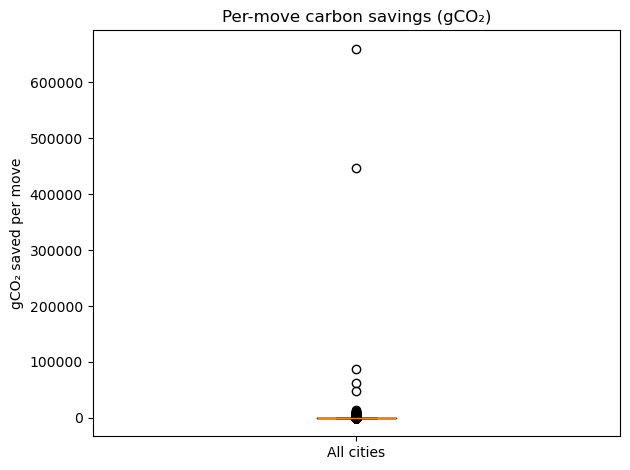

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_54984/1715004242.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(city_vals, vert=True, labels=city_labels_final, showfliers=False)



=== Average carbon saved per household-week (overall) ===
{'n_household_weeks': 5118766.0, 'avg_gCO2_per_hhweek': 129.49231563098232, 'median_gCO2_per_hhweek': 88.7531711130548, 'avg_kWh_per_hhweek': 1.255887033409569, 'median_kWh_per_hhweek': 1.0360632557421923}

=== Average carbon saved per household-week (by city) ===
  city  n_household_weeks  avg_gCO2_per_hhweek  median_gCO2_per_hhweek  avg_kWh_per_hhweek  median_kWh_per_hhweek
 delhi            4203122           130.726987               89.255438            1.236170               1.025152
mumbai             915644           123.824746               86.931046            1.346397               1.079286


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_54984/1715004242.py:163: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(hh_week_df["dE_week_g"].to_numpy(), vert=True, labels=["All cities"], showfliers=False)
/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_54984/1715004242.py:183: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(pw_vals, vert=True, labels=pw_labels_final, showfliers=False)



PNG boxplots saved to: /Users/Daniel/Desktop/IRP_WORK_UPDATED/irp-dbk24/code_and_analysis/analysis_outputs


In [113]:
# ---- Inputs (adjust if your variable names differ) --------------------------
# I’ll assume you already have these Polars objects in memory:
#   - policy_2_greedy_moves_pldf   (per-move table)
#   - policy_2_greedy_metrics_pldf (per-customer-day table)

moves = policy_2_greedy_moves_pldf
metrics = policy_2_greedy_metrics_pldf
out_dir = Path("analysis_outputs"); out_dir.mkdir(parents=True, exist_ok=True)

# ----------------------------------------------------------------------------
# A. CARBON SAVED *PER MOVE* (overall + by city), using marginal deltas
# ----------------------------------------------------------------------------
# Robust: keep only moves with a positive marginal emissions delta (i.e., savings)
mv_lf = (moves.lazy()
              .select([
                  pl.col("city").cast(pl.Utf8),
                  pl.col("marginal_emissions_delta_grams_co2")
                    .cast(pl.Float64)
                    .alias("dE_g"),
                  pl.col("delta_kwh").cast(pl.Float64).alias("dQ_kwh"),

              ])
              .filter(pl.col("dE_g") > 0)
              .filter(pl.col("dQ_kwh").is_not_null())  # safety

        )

per_move_overall = (
    mv_lf.select([
        pl.len().alias("n_moves"),
        pl.col("dE_g").mean().alias("avg_g_per_move"),
        pl.col("dE_g").median().alias("median_g_per_move"),
        (pl.col("dE_g")).mean().alias("avg_gCO2_per_move"),
        (pl.col("dE_g")).median().alias("median_gCO2_per_move"),
        pl.col("dQ_kwh").mean().alias("avg_kWh_per_move"),
        pl.col("dQ_kwh").median().alias("median_kWh_per_move"),
    ]).collect()
).row(0, named=True)

per_move_by_city = (
    mv_lf.group_by("city")
         .agg([
             pl.len().alias("n_moves"),
             pl.col("dE_g").mean().alias("avg_g_per_move"),
             pl.col("dE_g").median().alias("median_g_per_move"),
             (pl.col("dE_g")).mean().alias("avg_gCO2_per_move"),
             (pl.col("dE_g").median().alias("median_gCO2_per_move")),
             pl.col("dQ_kwh").mean().alias("avg_kWh_per_move"),
             pl.col("dQ_kwh").median().alias("median_kWh_per_move"),
         ])
         .sort("city")
         .collect()
)

print("=== Average carbon & kWh per move (overall, savings-only) ===")
print({k: (float(v) if isinstance(v, (int, float, np.floating)) else v)
       for k, v in per_move_overall.items()})

print("\n=== Average carbon & kWh per move (by city, savings-only) ===")
print(per_move_by_city.to_pandas().to_string(index=False))

# Boxplots (per-move savings)
mv_for_plot = mv_lf.select([
    pl.col("city"),
    pl.col("dE_g"),
]).collect()
# overall boxplot
fig = plt.figure()
ax = plt.gca()
ax.boxplot(mv_for_plot["dE_g"].to_numpy(), vert=True, labels=["All cities"])
ax.set_ylabel("gCO₂ saved per move")
ax.set_title("Per-move carbon savings (gCO₂)")
fig.tight_layout()
fig.savefig(out_dir / "per_move_savings_boxplot_overall.png", dpi=160)
plt.show()


city_labels = per_move_by_city["city"].to_list()
city_vals, city_labels_final = [], []

for c in city_labels:
    sub = mv_for_plot.filter(pl.col("city") == c)
    if sub.height:
        city_vals.append(sub["dE_g"].to_numpy() / 1_000_000)  # -> tCO2
        city_labels_final.append(c)

if city_vals:
    fig = plt.figure(figsize=(max(5, len(city_vals)*0.9), 4))
    ax = plt.gca()
    ax.boxplot(city_vals, vert=True, labels=city_labels_final, showfliers=False)
    ax.set_ylabel("tCO₂ saved per move")
    ax.set_title("Per-move carbon savings by city (tCO₂)")
    fig.tight_layout()
    fig.savefig(out_dir / "per_move_savings_boxplot_by_city.png", dpi=160)
    plt.close(fig)

# --------------- PER WEEK: average carbon saved (HH-week) -------------------
# Build household-week savings from daily deltas; keep positive daily savings.
week_start_expr = (
    (pl.col("day") - pl.duration(days=pl.col("day").dt.weekday()))
    .dt.truncate("1d")
    .alias("week_start")
)

m_lf = (
    metrics.lazy()
           .filter(pl.col("ca_id").is_not_null())
           .select([
               pl.col("city").cast(pl.Utf8),
               pl.col("ca_id").cast(pl.Utf8),
               pl.col("day"),
               pl.col("delta_E_marg_g").cast(pl.Float64).alias("dE_day_g"),
               pl.col("moved_kwh").cast(pl.Float64).alias("dQ_kwh"),
           ])
           .filter(pl.col("dE_day_g") > 0)  # guard against tiny negatives
           .filter(pl.col("dQ_kwh").is_not_null())
)

hh_week = (
    m_lf.with_columns(week_start_expr)
        .group_by(["city","ca_id","week_start"])
        .agg(pl.col("dE_day_g").sum().alias("dE_week_g"), pl.col("dQ_kwh").sum().alias("dQ_week_kwh"))
)

per_week_overall = (
    hh_week.select([
        pl.len().alias("n_household_weeks"),
        (pl.col("dE_week_g")).mean().alias("avg_gCO2_per_hhweek"),
        (pl.col("dE_week_g")).median().alias("median_gCO2_per_hhweek"),
        (pl.col("dQ_week_kwh")).mean().alias("avg_kWh_per_hhweek"),
        (pl.col("dQ_week_kwh")).median().alias("median_kWh_per_hhweek"),
    ]).collect()
).row(0, named=True)

per_week_by_city = (
    hh_week.group_by("city")
           .agg([
               pl.len().alias("n_household_weeks"),
               (pl.col("dE_week_g")).mean().alias("avg_gCO2_per_hhweek"),
               (pl.col("dE_week_g")).median().alias("median_gCO2_per_hhweek"),
               (pl.col("dQ_week_kwh")).mean().alias("avg_kWh_per_hhweek"),
               (pl.col("dQ_week_kwh")).median().alias("median_kWh_per_hhweek"),
           ])
           .sort("city")
           .collect()
)

print("\n=== Average carbon saved per household-week (overall) ===")
print({k: (float(v) if isinstance(v, (int, float, np.floating)) else v)
       for k, v in per_week_overall.items()})
print("\n=== Average carbon saved per household-week (by city) ===")
print(per_week_by_city.to_pandas().to_string(index=False))

# Boxplots (per-household-week savings)
hh_week_df = hh_week.select([
    pl.col("city"),
    (pl.col("dE_week_g")).alias("dE_week_g")
]).collect()

# overall
fig = plt.figure()
ax = plt.gca()
ax.boxplot(hh_week_df["dE_week_g"].to_numpy(), vert=True, labels=["All cities"], showfliers=False)
ax.set_ylabel("gCO₂ saved per household-week")
ax.set_title("Weekly carbon savings per household (gCO₂)")
fig.tight_layout()
fig.savefig(out_dir / "per_week_hh_savings_boxplot_overall.png", dpi=160)
plt.close(fig)

# by city (same ordering as per_week_by_city)
pw_city_labels = per_week_by_city["city"].to_list()
pw_vals = []
pw_labels_final = []
for c in pw_city_labels:
    arr = hh_week_df.filter(pl.col("city")==c)["dE_week_g"].to_numpy()
    if arr.size > 0:
        pw_vals.append(arr)
        pw_labels_final.append(c)

if pw_vals:
    fig = plt.figure(figsize=(max(5, len(pw_vals)*0.9), 4))
    ax = plt.gca()
    ax.boxplot(pw_vals, vert=True, labels=pw_labels_final, showfliers=False)
    ax.set_ylabel("gCO₂ saved per household-week")
    ax.set_title("Weekly carbon savings per household by city gCO₂)")
    fig.tight_layout()
    fig.savefig(out_dir / "per_week_hh_savings_boxplot_by_city.png", dpi=160)
    plt.close(fig)

print(f"\nPNG boxplots saved to: {out_dir.resolve()}")

In [119]:
import polars as pl

mv_all = (
    policy_2_greedy_moves_pldf.lazy()
    .select([
        pl.col("city").cast(pl.Utf8),
        pl.col("delta_kwh").cast(pl.Float64).alias("dQ_kwh"),
        pl.col("marginal_emissions_delta_grams_co2")
          .cast(pl.Float64).alias("dE_g"),
    ])
    .filter(pl.col("dQ_kwh").is_not_null())
)

# Categorize moves by emissions impact
mv_categorized = mv_all.with_columns(
    pl.when(pl.col("dE_g") > 0).then(pl.lit("savings"))
     .when(pl.col("dE_g") < 0).then(pl.lit("increases"))
     .otherwise(pl.lit("neutral"))
     .alias("category")
)


In [120]:
by_cat = (
    mv_categorized
    .group_by("category")
    .agg([
        pl.len().alias("n_moves"),
        pl.col("dE_g").sum().alias("net_gCO2"),              # >0 for savings, <0 for increases
        pl.col("dE_g").abs().mean().alias("mean_abs_gCO2_per_move"),
        pl.col("dE_g").abs().median().alias("median_abs_gCO2_per_move"),
        pl.col("dQ_kwh").mean().alias("avg_kWh_per_move"),
        pl.col("dQ_kwh").median().alias("median_kWh_per_move"),
        # weighted effectiveness (gCO2 saved per kWh moved)
        (pl.col("dE_g").sum() / pl.col("dQ_kwh").sum()).alias("gCO2_per_kWh_weighted"),
        # per-move ratio (mean of individual ratios) – guards against div/0
        pl.when(pl.col("dQ_kwh") > 0)
          .then((pl.col("dE_g")/pl.col("dQ_kwh"))).otherwise(None)
          .mean().alias("gCO2_per_kWh_per_move_mean"),
    ])
    .collect()
)

# add shares
by_cat = by_cat.with_columns(
    (pl.col("n_moves") / pl.col("n_moves").sum()).alias("share_moves")
)

print("\n=== Moves by emissions category (overall) ===")
print(by_cat.to_pandas().to_string(index=False))



=== Moves by emissions category (overall) ===
category  n_moves     net_gCO2  mean_abs_gCO2_per_move  median_abs_gCO2_per_move  avg_kWh_per_move  median_kWh_per_move  gCO2_per_kWh_weighted  gCO2_per_kWh_per_move_mean  share_moves
 savings 14996536 6.628409e+08               44.199598                 26.132967          0.428672             0.323056             103.108251                  100.357187          1.0


In [123]:
net_overall = (
    mv_all.select([
        pl.len().alias("n_moves_total"),
        pl.col("dE_g").clip(lower_bound=0).sum().alias("total_saved_gCO2"),
        (-pl.col("dE_g").clip(upper_bound=0)).sum().alias("total_added_gCO2"),
        pl.col("dE_g").sum().alias("net_gCO2"),
        pl.col("dQ_kwh").sum().alias("total_kWh_moved"),
    ])
    .collect()
)

d = net_overall.row(0, named=True)
giveback_ratio = (d["total_added_gCO2"] / d["total_saved_gCO2"]) if d["total_saved_gCO2"] else float("nan")
realization_rate = (d["net_gCO2"] / d["total_saved_gCO2"]) if d["total_saved_gCO2"] else float("nan")

print("\n=== Net CO₂ impact (overall) ===")
print({
    **d,
    "giveback_ratio": giveback_ratio,   # fraction of savings “given back” by increases
    "realization_rate": realization_rate # net / saved (0–1 ideal)
})



=== Net CO₂ impact (overall) ===
{'n_moves_total': 14996536, 'total_saved_gCO2': 662840861.3378466, 'total_added_gCO2': 0.0, 'net_gCO2': 662840861.3378466, 'total_kWh_moved': 6428591.845186196, 'giveback_ratio': 0.0, 'realization_rate': 1.0}


In [124]:
by_city_cat = (
    mv_categorized
    .group_by(["city","category"])
    .agg([
        pl.len().alias("n_moves"),
        pl.col("dE_g").sum().alias("net_gCO2"),
        pl.col("dE_g").abs().mean().alias("mean_abs_gCO2_per_move"),
        pl.col("dQ_kwh").mean().alias("avg_kWh_per_move"),
        (pl.col("dE_g").sum() / pl.col("dQ_kwh").sum()).alias("gCO2_per_kWh_weighted"),
    ])
    .sort(["city","category"])
    .collect()
)
print("\n=== Moves by emissions category × city ===")
print(by_city_cat.to_pandas().to_string(index=False))

by_city_net = (
    mv_all
    .group_by("city")
    .agg([
        pl.len().alias("n_moves_total"),
        pl.col("dE_g").clip(lower_bound=0).sum().alias("total_saved_gCO2"),
        (-pl.col("dE_g").clip(upper_bound=0)).sum().alias("total_added_gCO2"),
        pl.col("dE_g").sum().alias("net_gCO2"),
        pl.col("dQ_kwh").sum().alias("total_kWh_moved"),
    ])
    .with_columns([
        (pl.col("total_added_gCO2")/pl.col("total_saved_gCO2")).alias("giveback_ratio"),
        (pl.col("net_gCO2")/pl.col("total_saved_gCO2")).alias("realization_rate"),
    ])
    .sort("city")
    .collect()
)
print("\n=== Net CO₂ impact × city ===")
print(by_city_net.to_pandas().to_string(index=False))



=== Moves by emissions category × city ===
  city category  n_moves     net_gCO2  mean_abs_gCO2_per_move  avg_kWh_per_move  gCO2_per_kWh_weighted
 delhi  savings 12394970 5.494615e+08               44.329391          0.419184             105.751661
mumbai  savings  2601566 1.133794e+08               43.581207          0.473876              91.967492

=== Net CO₂ impact × city ===
  city  n_moves_total  total_saved_gCO2  total_added_gCO2     net_gCO2  total_kWh_moved  giveback_ratio  realization_rate
 delhi       12394970      5.494615e+08              -0.0 5.494615e+08     5.195772e+06            -0.0               1.0
mumbai        2601566      1.133794e+08              -0.0 1.133794e+08     1.232820e+06            -0.0               1.0


In [ ]:
import polars as pl

# use your metrics table
metrics = policy_2_greedy_metrics_pldf

# keep per-customer-day rows only (drop the "day_summary" rows)
m_lf = (
    metrics.lazy()
    .filter(
        pl.col("ca_id").is_not_null()
        & (pl.col("row_type").is_null() | (pl.col("row_type") != "day_summary"))
    )
    .select([
        pl.col("city").cast(pl.Utf8),
        pl.col("day"),
        pl.col("baseline_E_marg_g").cast(pl.Float64),
        pl.col("post_E_marg_g").cast(pl.Float64),
        pl.col("delta_E_marg_g").cast(pl.Float64),
        pl.col("baseline_E_avg_g").cast(pl.Float64),
        pl.col("post_E_avg_g").cast(pl.Float64),
        pl.col("delta_E_avg_g").cast(pl.Float64),
        pl.col("baseline_kwh").cast(pl.Float64),
        pl.col("moved_kwh").cast(pl.Float64),
        pl.col("ca_id").cast(pl.Utf8),
    ])
)

# ---------- OVERALL ----------
overall = (
    m_lf
    .select([
        pl.sum("delta_E_marg_g").alias("saved_marg_g"),
        pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
        pl.sum("delta_E_avg_g").alias("saved_avg_g"),
        pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
        pl.sum("moved_kwh").alias("moved_kwh"),
        pl.sum("baseline_kwh").alias("baseline_kwh"),
        pl.n_unique("ca_id").alias("unique_customers"),
    ])
    .with_columns([
        pl.when(pl.col("baseline_marg_g") > 0)
          .then(pl.col("saved_marg_g") / pl.col("baseline_marg_g"))
          .otherwise(None)
          .alias("pct_reduction_marg"),
        pl.when(pl.col("baseline_avg_g") > 0)
          .then(pl.col("saved_avg_g") / pl.col("baseline_avg_g"))
          .otherwise(None)
          .alias("pct_reduction_avg"),
        pl.when(pl.col("baseline_kwh") > 0)
          .then(pl.col("moved_kwh") / pl.col("baseline_kwh"))
          .otherwise(None)
          .alias("pct_kwh_shifted"),
        (pl.col("saved_marg_g")/1_000_000).alias("saved_marg_tCO2"),
        (pl.col("saved_avg_g")/1_000_000).alias("saved_avg_tCO2"),
    ])
    .collect()
)

print("=== OVERALL % reduction (sample) ===")
print(overall.select([
    "unique_customers",
    "saved_marg_tCO2","saved_avg_tCO2",
    "pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))

# ---------- BY CITY ----------
by_city = (
    m_lf
    .group_by("city")
    .agg([
        pl.sum("delta_E_marg_g").alias("saved_marg_g"),
        pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
        pl.sum("delta_E_avg_g").alias("saved_avg_g"),
        pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
        pl.sum("moved_kwh").alias("moved_kwh"),
        pl.sum("baseline_kwh").alias("baseline_kwh"),
        pl.n_unique("ca_id").alias("unique_customers"),
    ])
    .with_columns([
        pl.when(pl.col("baseline_marg_g") > 0)
          .then(pl.col("saved_marg_g") / pl.col("baseline_marg_g"))
          .otherwise(None)
          .alias("pct_reduction_marg"),
        pl.when(pl.col("baseline_avg_g") > 0)
          .then(pl.col("saved_avg_g") / pl.col("baseline_avg_g"))
          .otherwise(None)
          .alias("pct_reduction_avg"),
        pl.when(pl.col("baseline_kwh") > 0)
          .then(pl.col("moved_kwh") / pl.col("baseline_kwh"))
          .otherwise(None)
          .alias("pct_kwh_shifted"),
        (pl.col("saved_marg_g")/1_000_000).alias("saved_marg_tCO2"),
        (pl.col("saved_avg_g")/1_000_000).alias("saved_avg_tCO2"),
    ])
    .sort("city")
    .collect()
)

print("\n=== BY CITY % reduction (sample) ===")
print(by_city.select([
    "city","unique_customers",
    "saved_marg_tCO2","saved_avg_tCO2",
    "pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))

# ---------- WEEKLY (overall + by city) ----------
week_start = (
    (pl.col("day") - pl.duration(days=pl.col("day").dt.weekday()))
    .dt.truncate("1d")
    .alias("week_start")
)

weekly_overall = (
    m_lf.with_columns(week_start)
        .group_by("week_start")
        .agg([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
        .with_columns([
            (pl.col("saved_marg_g")/1_000_000).alias("saved_marg_tCO2"),
            (pl.col("saved_avg_g")/1_000_000).alias("saved_avg_tCO2"),
            pl.when(pl.col("baseline_marg_g") > 0)
              .then(pl.col("saved_marg_g")/pl.col("baseline_marg_g"))
              .otherwise(None)
              .alias("pct_reduction_marg"),
            pl.when(pl.col("baseline_avg_g") > 0)
              .then(pl.col("saved_avg_g")/pl.col("baseline_avg_g"))
              .otherwise(None)
              .alias("pct_reduction_avg"),
            pl.when(pl.col("baseline_kwh") > 0)
              .then(pl.col("moved_kwh")/pl.col("baseline_kwh"))
              .otherwise(None)
              .alias("pct_kwh_shifted"),
        ])
        .sort("week_start")
        .collect()
)

weekly_by_city = (
    m_lf.with_columns(week_start)
        .group_by(["city","week_start"])
        .agg([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
        .with_columns([
            (pl.col("saved_marg_g")/1_000_000).alias("saved_marg_tCO2"),
            (pl.col("saved_avg_g")/1_000_000).alias("saved_avg_tCO2"),
            pl.when(pl.col("baseline_marg_g") > 0)
              .then(pl.col("saved_marg_g")/pl.col("baseline_marg_g"))
              .otherwise(None)
              .alias("pct_reduction_marg"),
            pl.when(pl.col("baseline_avg_g") > 0)
              .then(pl.col("saved_avg_g")/pl.col("baseline_avg_g"))
              .otherwise(None)
              .alias("pct_reduction_avg"),
            pl.when(pl.col("baseline_kwh") > 0)
              .then(pl.col("moved_kwh")/pl.col("baseline_kwh"))
              .otherwise(None)
              .alias("pct_kwh_shifted"),
        ])
        .sort(["city","week_start"])
        .collect()
)

print("\n=== WEEKLY OVERALL % reduction (sample) ===")
print(weekly_overall.select([
    "week_start","saved_marg_tCO2","saved_avg_tCO2",
    "pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))

print("\n=== WEEKLY BY CITY % reduction (sample) ===")
print(weekly_by_city.select([
    "city","week_start","saved_marg_tCO2","saved_avg_tCO2",
    "pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))


=== OVERALL % reduction (sample) ===
 unique_customers  saved_marg_tCO2  saved_avg_tCO2  pct_reduction_marg  pct_reduction_avg  pct_kwh_shifted
           238479       662.840863      160.506113            0.004977           0.001219         0.037335

=== BY CITY % reduction (sample) ===
  city  unique_customers  saved_marg_tCO2  saved_avg_tCO2  pct_reduction_marg  pct_reduction_avg  pct_kwh_shifted
 delhi            184640       549.461477      117.395609            0.005202           0.001130         0.038087
mumbai             53839       113.379386       43.110504            0.004115           0.001554         0.034467

=== WEEKLY OVERALL % reduction (sample) ===
               week_start  saved_marg_tCO2  saved_avg_tCO2  pct_reduction_marg  pct_reduction_avg  pct_kwh_shifted
2021-11-28 00:00:00+05:30        16.302555        3.913125            0.004932           0.001482         0.043303
2021-12-05 00:00:00+05:30        16.189390        3.069729            0.005100           0.001

In [40]:
import polars as pl

metrics = policy_2_greedy_metrics_pldf  # your per-customer-day table

def _align_like(df: pl.DataFrame, ref_cols: list[str]) -> pl.DataFrame:
    for c in ref_cols:
        if c not in df.columns:
            df = df.with_columns(pl.lit(None).alias(c))
    return df.select(ref_cols)

def align_like(df: pl.DataFrame, ref: pl.DataFrame) -> pl.DataFrame:
    ref_cols = list(ref.columns)
    ref_schema = ref.schema
    out = df
    for c, dt in ref_schema.items():
        if c in out.columns:
            out = out.with_columns(pl.col(c).cast(dt))
        else:
            out = out.with_columns(pl.lit(None).cast(dt).alias(c))
    # drop any extras and reorder to match ref
    return out.select(ref_cols)


# ---- base (per-customer-day rows only) -------------------------------------
m_lf = (
    metrics.lazy()
    .filter(
        pl.col("ca_id").is_not_null()
        & (pl.col("row_type").is_null() | (pl.col("row_type") != "day_summary"))
    )
    .select([
        pl.col("city").cast(pl.Utf8),
        pl.col("ca_id").cast(pl.Utf8),
        pl.col("day"),
        pl.col("baseline_E_marg_g").cast(pl.Float64),
        pl.col("post_E_marg_g").cast(pl.Float64),
        pl.col("delta_E_marg_g").cast(pl.Float64),
        pl.col("baseline_E_avg_g").cast(pl.Float64),
        pl.col("post_E_avg_g").cast(pl.Float64),
        pl.col("delta_E_avg_g").cast(pl.Float64),
        pl.col("baseline_kwh").cast(pl.Float64),
        pl.col("moved_kwh").cast(pl.Float64),
    ])
    .with_columns([
        # Monday-start week anchor
        (pl.col("day") - pl.duration(days=pl.col("day").dt.weekday()))
            .dt.truncate("1d")
            .alias("week_start"),
        pl.col("day").dt.year().alias("year"),
        pl.col("day").dt.week().alias("iso_week"),
    ])
)

# Small helper to compute % fields from sums
def _with_pcts(df: pl.LazyFrame | pl.DataFrame) -> pl.LazyFrame:
    lf = df.lazy() if isinstance(df, pl.DataFrame) else df
    return lf.with_columns([
        (pl.col("saved_marg_g")/1_000_000).alias("saved_marg_tCO2"),
        (pl.col("saved_avg_g")/1_000_000).alias("saved_avg_tCO2"),
        pl.when(pl.col("baseline_marg_g") > 0)
          .then(pl.col("saved_marg_g")/pl.col("baseline_marg_g"))
          .otherwise(None)
          .alias("pct_reduction_marg"),
        pl.when(pl.col("baseline_avg_g") > 0)
          .then(pl.col("saved_avg_g")/pl.col("baseline_avg_g"))
          .otherwise(None)
          .alias("pct_reduction_avg"),
        pl.when(pl.col("baseline_kwh") > 0)
          .then(pl.col("moved_kwh")/pl.col("baseline_kwh"))
          .otherwise(None)
          .alias("pct_kwh_shifted"),
    ])

# ========================= YEAR × WEEK (OVERALL) =============================
weekly_overall_base = (
    m_lf
    .group_by(["year","iso_week"])
    .agg([
        pl.sum("delta_E_marg_g").alias("saved_marg_g"),
        pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
        pl.sum("delta_E_avg_g").alias("saved_avg_g"),
        pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
        pl.sum("moved_kwh").alias("moved_kwh"),
        pl.sum("baseline_kwh").alias("baseline_kwh"),
    ])
)


weekly_overall = (
    _with_pcts(weekly_overall_base)
    .with_columns(
        (pl.col("year").cast(pl.Utf8) + "-W" + pl.col("iso_week").cast(pl.Utf8).str.zfill(2)).alias("label")
    )
    .sort(["year","iso_week"])
    .collect()
)

# Grand total row (weighted % from totals)
weekly_overall_total = (
    _with_pcts(
        m_lf.select([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
    )
    .with_columns([
        pl.lit(None, dtype=pl.Int32).alias("year"),
        pl.lit(None, dtype=pl.Int8).alias("iso_week"),
        pl.lit("TOTAL").alias("label"),
    ])
    .collect()
)
# weekly_overall already collected
ref_cols = weekly_overall.columns
weekly_overall_total = _align_like(weekly_overall_total, ref_cols)

weekly_overall_with_total = pl.concat(
    [weekly_overall, weekly_overall_total],
    how="vertical"   # schemas now identical; no need for *_relaxed
)

print("=== YEAR × WEEK (OVERALL) with TOTAL ===")
print(weekly_overall_with_total.select([
    "label","saved_marg_tCO2","saved_avg_tCO2","pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))

# ========================= YEAR × WEEK × CITY ================================
weekly_city_base = (
    m_lf
    .group_by(["city","year","iso_week"])
    .agg([
        pl.sum("delta_E_marg_g").alias("saved_marg_g"),
        pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
        pl.sum("delta_E_avg_g").alias("saved_avg_g"),
        pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
        pl.sum("moved_kwh").alias("moved_kwh"),
        pl.sum("baseline_kwh").alias("baseline_kwh"),
    ])
)

weekly_city = (
    _with_pcts(weekly_city_base)
    .with_columns(
        # OPTION A: concat + zfill (works on all versions)
        (
            pl.col("year").cast(pl.Utf8)
            + "-W"
            + pl.col("iso_week").cast(pl.Utf8).str.zfill(2)
        ).alias("label"))

    .sort(["city","year","iso_week"])
    .collect()
)

# Per-city TOTAL rows (weighted % from totals per city)
city_totals = (
    _with_pcts(
        m_lf.group_by("city").agg([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
    )
    .with_columns([
        pl.lit(None, dtype=pl.Int64).alias("year"),
        pl.lit(None, dtype=pl.Int64).alias("iso_week"),
        pl.lit("TOTAL").alias("label"),
    ])
    .collect()
)

# Optional: one GRAND TOTAL row inside the city table with city='ALL'
grand_total_city = (
    _with_pcts(
        m_lf.select([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
    )
    .with_columns([
        pl.lit("ALL").alias("city"),
        pl.lit(None, dtype=pl.Int64).alias("year"),
        pl.lit(None, dtype=pl.Int64).alias("iso_week"),
        pl.lit("TOTAL").alias("label"),
    ])
    .collect()
)

ref = weekly_city
ref_cols = ref.columns
ref_schema = ref.schema

# Reorder and cast the totals to match weekly_city
city_totals = (
    city_totals
    .with_columns([
        pl.col("year").cast(ref_schema["year"]),
        pl.col("iso_week").cast(ref_schema["iso_week"]),
    ])
    .select(ref_cols)
)

grand_total_city = (
    grand_total_city
    .with_columns([
        pl.col("year").cast(ref_schema["year"]),
        pl.col("iso_week").cast(ref_schema["iso_week"]),
    ])
    .select(ref_cols)
)

weekly_city_with_totals = pl.concat(
    [weekly_city, city_totals, grand_total_city],
    how="vertical_relaxed"
).sort(["city", pl.when(pl.col("label")=="TOTAL").then(1).otherwise(0), "label"])




print("\n=== YEAR × WEEK × CITY with per-city TOTAL + GRAND TOTAL ===")
print(weekly_city_with_totals.select([
    "city","label","saved_marg_tCO2","saved_avg_tCO2","pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))

# ================================ YEARLY =====================================
yearly_overall = (
    _with_pcts(
        m_lf.group_by("year").agg([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
    )
    .sort("year")
    .collect()
)

yearly_overall_total = (
    _with_pcts(
        m_lf.select([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
    )
    .with_columns(pl.lit("TOTAL").alias("year"))
    .collect()
)
yearly_overall_ref = yearly_overall.with_columns(pl.col("year").cast(pl.Utf8))

# align TOTAL to that schema/order
yearly_overall_total_aligned = align_like(yearly_overall_total, yearly_overall_ref)

# concat safely
yearly_overall_with_total = pl.concat(
    [yearly_overall_ref, yearly_overall_total_aligned],
    how="vertical"   # schemas now identical
)

print("\n=== YEARLY (OVERALL) with TOTAL ===")
print(yearly_overall_with_total.select([
    "year","saved_marg_tCO2","saved_avg_tCO2","pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))

yearly_by_city = (
    _with_pcts(
        m_lf.group_by(["city","year"]).agg([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
    )
    .sort(["city","year"])
    .collect()
)

yearly_city_totals = (
    _with_pcts(
        m_lf.group_by("city").agg([
            pl.sum("delta_E_marg_g").alias("saved_marg_g"),
            pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
            pl.sum("delta_E_avg_g").alias("saved_avg_g"),
            pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
            pl.sum("moved_kwh").alias("moved_kwh"),
            pl.sum("baseline_kwh").alias("baseline_kwh"),
        ])
    )
    .with_columns(pl.lit("TOTAL").alias("year"))
    .collect()
)
yearly_by_city_ref = yearly_by_city.with_columns(pl.col("year").cast(pl.Utf8))
yearly_city_totals_aligned = align_like(yearly_city_totals, yearly_by_city_ref)

yearly_by_city_with_total = pl.concat(
    [yearly_by_city_ref, yearly_city_totals_aligned],
    how="vertical"
).sort(["city", pl.when(pl.col("year")=="TOTAL").then(1).otherwise(0), "year"])

print("\n=== YEARLY × CITY with per-city TOTAL ===")
print(yearly_by_city_with_total.select([
    "city","year","saved_marg_tCO2","saved_avg_tCO2","pct_reduction_marg","pct_reduction_avg","pct_kwh_shifted"
]).to_pandas().to_string(index=False))


=== YEAR × WEEK (OVERALL) with TOTAL ===
   label  saved_marg_tCO2  saved_avg_tCO2  pct_reduction_marg  pct_reduction_avg  pct_kwh_shifted
2021-W48        16.302555        3.913125            0.004932           0.001482         0.043303
2021-W49        16.189390        3.069729            0.005100           0.001152         0.045931
2021-W50        17.383308        3.329539            0.005359           0.001190         0.045883
2021-W51        22.786073        5.028503            0.006359           0.001523         0.046674
2021-W52        23.403697        3.965774            0.006523           0.001232         0.047258
2022-W01        21.054119        4.814579            0.005813           0.001414         0.045272
2022-W02        24.131163        4.367177            0.006151           0.001252         0.046419
2022-W03        25.465677        6.149537            0.006001           0.001570         0.044285
2022-W04        36.563789        6.826935            0.008559           0.001

In [41]:
import polars as pl
from pathlib import Path

metrics = policy_2_greedy_metrics_pldf      # per-customer-day table
moves   = policy_2_greedy_moves_pldf        # per-move table

# ---------------------- helpers ----------------------
week_start_from_day = (
    (pl.col("day") - pl.duration(days=pl.col("day").dt.weekday()))
    .dt.truncate("1d")
    .alias("week_start")
)
week_start_from_ts = (
    (pl.col("original_time") - pl.duration(days=pl.col("original_time").dt.weekday()))
    .dt.truncate("1d")
    .alias("week_start")
)

# ----------------- unique customers -----------------
unique_customers = (
    metrics.lazy()
    .filter(pl.col("ca_id").is_not_null())
    .select(pl.col("ca_id").cast(pl.Utf8))
    .unique()
    .count()
    .collect()
    .item()
)

# -------- per household-week CO₂ savings (marginal) --------
# Sum daily marginal deltas per (city, ca_id, week); clip negatives to 0 (no "negative saving")
hh_week = (
    metrics.lazy()
    .filter(
        pl.col("ca_id").is_not_null()
        & (pl.col("row_type").is_null() | (pl.col("row_type") != "day_summary"))
    )
    .select([
        pl.col("city").cast(pl.Utf8),
        pl.col("ca_id").cast(pl.Utf8),
        pl.col("day"),
        pl.col("delta_E_marg_g").cast(pl.Float64).alias("dE_day_g"),
    ])
    .with_columns([week_start_from_day])
    .group_by(["city","ca_id","week_start"])
    .agg(pl.sum("dE_day_g").alias("dE_week_g"))
    .with_columns(
    pl.when(pl.col("dE_week_g") < 0)
      .then(0.0)
      .otherwise(pl.col("dE_week_g"))
      .alias("dE_week_g")
)
)

# Overall avg per household-week (include zero weeks)
overall_weekly = (
    hh_week.select([
        pl.len().alias("n_household_weeks"),
        (pl.col("dE_week_g")/1_000_000).mean().alias("avg_tCO2_per_hhweek"),
        (pl.col("dE_week_g")/1_000_000).median().alias("median_tCO2_per_hhweek"),
    ])
    .collect()
    .row(0, named=True)
)
annual_tCO2_per_hh = overall_weekly["avg_tCO2_per_hhweek"] * 52.0

# By-city avg per household-week
by_city_weekly = (
    hh_week.group_by("city")
    .agg([
        pl.len().alias("n_household_weeks"),
        (pl.col("dE_week_g")/1_000_000).mean().alias("avg_tCO2_per_hhweek"),
        (pl.col("dE_week_g")/1_000_000).median().alias("median_tCO2_per_hhweek"),
    ])
    .sort("city")
    .with_columns((pl.col("avg_tCO2_per_hhweek") * 52.0).alias("annual_tCO2_per_hh"))
    .collect()
)

# ---------------- moves per household-week ----------------
hh_week_moves = (
    moves.lazy()
    .select([
        pl.col("city").cast(pl.Utf8),
        pl.col("ca_id").cast(pl.Utf8),
        pl.col("original_time"),
    ])
    .with_columns([week_start_from_ts])
    .group_by(["city","ca_id","week_start"])
    .agg(pl.len().alias("n_moves_week"))
)

overall_moves = (
    hh_week_moves.select([
        pl.len().alias("n_household_weeks_observed"),
        pl.col("n_moves_week").mean().alias("avg_moves_per_hhweek"),
        pl.col("n_moves_week").median().alias("median_moves_per_hhweek"),
    ])
    .collect()
    .row(0, named=True)
)

by_city_moves = (
    hh_week_moves.group_by("city")
    .agg([
        pl.len().alias("n_household_weeks_observed"),
        pl.col("n_moves_week").mean().alias("avg_moves_per_hhweek"),
        pl.col("n_moves_week").median().alias("median_moves_per_hhweek"),
    ])
    .sort("city")
    .collect()
)

# ------------------ print nice summary -------------------
print("=== SURVEY SUMMARY (sample) ===")
print({
    "unique_customers": int(unique_customers),
    "avg_tCO2_saved_per_household_per_week": overall_weekly["avg_tCO2_per_hhweek"],
    "median_tCO2_saved_per_household_per_week": overall_weekly["median_tCO2_per_hhweek"],
    "annual_tCO2_saved_per_household (extrapolated x52)": annual_tCO2_per_hh,
    "avg_moves_per_household_per_week": overall_moves["avg_moves_per_hhweek"],
    "median_moves_per_household_per_week": overall_moves["median_moves_per_hhweek"],
})

print("\n=== BY CITY — per-household weekly & annual savings ===")
print(by_city_weekly.select([
    "city","n_household_weeks","avg_tCO2_per_hhweek","median_tCO2_per_hhweek","annual_tCO2_per_hh"
]).to_pandas().to_string(index=False))

print("\n=== BY CITY — moves per household-week ===")
print(by_city_moves.to_pandas().to_string(index=False))

# Friendly sentence for slides/docs
avg_moves = overall_moves["avg_moves_per_hhweek"]
qualifier = "less than three" if avg_moves < 3 else f"about {avg_moves:.1f}"
print(
    f"\nIn a survey of {unique_customers:,} customers, households saved on average "
    f"{overall_weekly['avg_tCO2_per_hhweek']*1e3:.2f} kg CO₂ per week "
    f"({annual_tCO2_per_hh:.2f} t CO₂ per household per year), "
    f"with {qualifier} changes to behavior per week (mean {avg_moves:.2f})."
)


=== SURVEY SUMMARY (sample) ===
{'unique_customers': 238479, 'avg_tCO2_saved_per_household_per_week': 0.00012201881612101664, 'median_tCO2_saved_per_household_per_week': 8.079712309690103e-05, 'annual_tCO2_saved_per_household (extrapolated x52)': 0.006344978438292866, 'avg_moves_per_household_per_week': 2.9297170450846943, 'median_moves_per_household_per_week': 3.0}

=== BY CITY — per-household weekly & annual savings ===
  city  n_household_weeks  avg_tCO2_per_hhweek  median_tCO2_per_hhweek  annual_tCO2_per_hh
 delhi            4441805             0.000124                0.000082            0.006433
mumbai             990479             0.000114                0.000078            0.005952

=== BY CITY — moves per household-week ===
  city  n_household_weeks_observed  avg_moves_per_hhweek  median_moves_per_hhweek
 delhi                     4203122              2.948991                      3.0
mumbai                      915644              2.841242                      3.0

In a surve

#### Helper Functions

In [42]:
# Convenience: to_pandas for plotting
def to_pd(df_pl: pl.DataFrame) -> pd.DataFrame:
    return df_pl.to_pandas()


In [43]:
# Convenience: safe division
def safe_div(n, d):
    return (n / d) if d else np.nan


In [44]:
def _as_lazy(df_or_lf):
    """Accept a Polars DataFrame or LazyFrame and return LazyFrame."""
    if isinstance(df_or_lf, pl.LazyFrame):
        return df_or_lf
    if isinstance(df_or_lf, pl.DataFrame):
        return df_or_lf.lazy()
    raise TypeError("Expected Polars DataFrame or LazyFrame")

In [45]:
def _fmt_pct(x):
    return f"{100.0 * float(x):.1f}%"


In [46]:
TZ = "Asia/Kolkata"

def _as_lf(df_or_lf):
    return df_or_lf.lazy() if isinstance(df_or_lf, pl.DataFrame) else df_or_lf


In [47]:
def _pick(cols, *cands):
    s = set(cols)
    for c in cands:
        if c in s:
            return c
    return None


In [48]:

def _to_ns_tz(expr, tz=TZ):
    # unify precision + timezone without changing wall time
    return (expr
            .dt.cast_time_unit("ns")
            .dt.convert_time_zone(tz))


In [49]:

def _iso_year_week(col):
    # Polars has .dt.week() (ISO week) and .dt.year()
    return [
        col.dt.year().alias("year"),
        col.dt.week().alias("iso_week"),
    ]

In [50]:
def _ensure_categoricals(lf, cols=("city","ca_id")):
    cols = [c for c in cols if c in lf.columns]
    if not cols:
        return lf
    return lf.with_columns([pl.col(c).cast(pl.Categorical) for c in cols])


In [51]:
def _dedupe_confidence(conf_lf: pl.LazyFrame) -> pl.LazyFrame:
    """
    Collapse the dense lat/lon grid to one row per (city, timestamp).
    We take the first 'Confidence Level' (should be identical across grid)
    and mean of Pearson/Spearman/ME_cal for sanity.
    """
    # normalize snake_case names if needed
    rename_map = {}
    for c in conf_lf.columns:
        lc = c.lower().replace(" ", "_")
        if lc != c:
            rename_map[c] = lc
    if rename_map:
        conf_lf = conf_lf.rename(rename_map)

    choose = []
    if "confidence_level" in conf_lf.columns:
        choose.append(pl.first("confidence_level").alias("confidence_level"))
    if "pearson_r_score" in conf_lf.columns:
        choose.append(pl.col("pearson_r_score").mean().alias("pearson_r"))
    if "spearman_score" in conf_lf.columns:
        choose.append(pl.col("spearman_score").mean().alias("spearman_r"))
    if "me_cal" in conf_lf.columns:
        choose.append(pl.col("me_cal").mean().alias("me_cal_mean"))

    need = ["city", "timestamp"]
    for n in need:
        if n not in conf_lf.columns:
            raise ValueError(f"confidence df missing column: {n}")

    return (
        conf_lf
        .group_by(["city","timestamp"], maintain_order=False)
        .agg(choose)
    )

In [52]:
def annotate_moves_with_confidence(
    moves_df: pl.DataFrame | pl.LazyFrame,
    conf_df: pl.DataFrame | pl.LazyFrame,
    round_to: str | None = "30m",  # robust to tiny timestamp jitter
    tz: str = TZ,
):
    """
    Returns:
      by_label:  share of moves/kWh by confidence label
      by_city:   same, split by city
      moves_enriched: LazyFrame with a 'conf' label per move
    """
    mv = _as_lf(moves_df).select(
        pl.col("city").cast(pl.Utf8),
        _to_ns_tz(pl.col("original_time"), tz).alias("original_time"),
        _to_ns_tz(pl.col("proposed_shift_time"), tz).alias("proposed_shift_time"),
        pl.col("delta_kwh").cast(pl.Float64),
        pl.col("delta_minutes").abs().alias("abs_minutes"),
    )

    # detect columns in confidence DF
    cf_lf = _as_lf(conf_df)
    cols = cf_lf.columns
    time_col     = _pick(cols, "timestamp", "datetime", "date", "time", "ts")
    conf_col     = _pick(cols, "Confidence Level", "confidence_level", "conf")
    pearson_col  = _pick(cols, "Pearson R Score", "pearson_r_score", "pearson_r")
    spearman_col = _pick(cols, "Spearman Score", "spearman_score")
    mecal_col    = _pick(cols, "ME_cal", "me_cal")

    if time_col is None:
        raise ValueError("No time column found in confidence_df.")

    base_keep = [
        pl.col("city").cast(pl.Utf8),
        _to_ns_tz(pl.col(time_col), tz).alias("timestamp"),
    ]
    if conf_col:     base_keep.append(pl.col(conf_col).alias("confidence_level"))
    if pearson_col:  base_keep.append(pl.col(pearson_col).alias("pearson_r_score"))
    if spearman_col: base_keep.append(pl.col(spearman_col).alias("spearman_score"))
    if mecal_col:    base_keep.append(pl.col(mecal_col).alias("me_cal"))

    cf_min = cf_lf.select(base_keep)

    # collapse any spatial duplicates to (city, timestamp)
    agg_exprs = []
    if conf_col:     agg_exprs.append(pl.first("confidence_level").alias("confidence_level"))
    if pearson_col:  agg_exprs.append(pl.col("pearson_r_score").mean().alias("pearson_r"))
    if spearman_col: agg_exprs.append(pl.col("spearman_score").mean().alias("spearman_r"))
    if mecal_col:    agg_exprs.append(pl.col("me_cal").mean().alias("me_cal_mean"))
    cf = cf_min.group_by(["city", "timestamp"]).agg(agg_exprs)

    # optional rounding to 30-minute grid (helps when one side is μs vs ns)
    if round_to:
        mv = mv.with_columns([
            pl.col("original_time").dt.truncate(round_to).alias("src_ts"),
            pl.col("proposed_shift_time").dt.truncate(round_to).alias("dst_ts"),
        ])
        cf = cf.with_columns(
            pl.col("timestamp").dt.truncate(round_to).alias("ts")
        )
        left_on_src, right_on_src = ["city","src_ts"], ["city","ts"]
        left_on_dst, right_on_dst = ["city","dst_ts"], ["city","ts"]
    else:
        mv = mv.with_columns([
            pl.col("original_time").alias("src_ts"),
            pl.col("proposed_shift_time").alias("dst_ts"),
        ])
        cf = cf.rename({"timestamp":"ts"})
        left_on_src = right_on_src = ["city","src_ts"]
        left_on_dst = right_on_dst = ["city","dst_ts"]

    # join source + destination confidence, coalesce to single label
    left = (mv.join(cf, left_on=left_on_src, right_on=right_on_src, how="left")
              .rename({"confidence_level":"src_conf"})
              .drop("ts"))
    both = (left.join(cf, left_on=left_on_dst, right_on=right_on_dst, how="left")
               .rename({"confidence_level":"dst_conf"})
               .drop("ts")
               .with_columns(pl.coalesce(["src_conf","dst_conf"]).alias("conf"))
               .with_columns(pl.col("conf").fill_null("unknown")))

    # shares overall
    by_label = (both.group_by("conf")
                    .agg([
                        pl.len().alias("n_moves"),
                        pl.col("delta_kwh").sum().alias("moved_kwh"),
                    ])
                    .with_columns([
                        (pl.col("n_moves")/pl.col("n_moves").sum()).alias("share_moves"),
                        (pl.col("moved_kwh")/pl.col("moved_kwh").sum()).alias("share_kwh"),
                    ])
                    .sort("conf")
                    .collect())

    # shares by city
    by_city = (both.group_by(["city","conf"])
                    .agg([
                        pl.len().alias("n_moves"),
                        pl.col("delta_kwh").sum().alias("moved_kwh"),
                    ])
                    .with_columns([
                        (pl.col("n_moves")/pl.col("n_moves").sum().over("city")).alias("share_moves_city"),
                        (pl.col("moved_kwh")/pl.col("moved_kwh").sum().over("city")).alias("share_kwh_city"),
                    ])
                    .sort(["city","conf"])
                    .collect())


In [53]:
def weekly_move_coverage(metrics_df: pl.DataFrame | pl.LazyFrame):
    """
    Returns:
      by_city_week: city, year, iso_week, hh_total, hh_with_move, share
      overall_week: year, iso_week, hh_total, hh_with_move, share
      hhweek_table: (city, year, iso_week, ca_id) with any_move flag
    """
    m = _as_lf(metrics_df)

    # keep only per-household rows (exclude day_summary rows)
    base = (m.filter(pl.col("row_type").is_null() | (pl.col("row_type") == ""))
              .select(
                  pl.col("city").cast(pl.Utf8),
                  pl.col("ca_id").cast(pl.Utf8),
                  pl.col("day").dt.cast_time_unit("ns"),
                  pl.col("moved_kwh").cast(pl.Float64),
              ))

    # any move per HH-week (ISO)
    hhweek = (base
              .with_columns(_iso_year_week(pl.col("day")))
              .group_by(["city","year","iso_week","ca_id"])
              .agg(pl.max("moved_kwh").alias("max_moved_kwh"))
              .with_columns((pl.col("max_moved_kwh") > 0).alias("any_move"))
             )

    by_city_week = (hhweek.group_by(["city","year","iso_week"])
                        .agg([
                            pl.len().alias("hh_total"),
                            pl.col("any_move").sum().alias("hh_with_move"),
                        ])
                        .with_columns(
                            (pl.col("hh_with_move")/pl.col("hh_total")).alias("share_with_move")
                        )
                        .sort(["city","year","iso_week"])
                        .collect())

    overall_week = (hhweek.group_by(["year","iso_week"])
                         .agg([
                             pl.len().alias("hh_total"),
                             pl.col("any_move").sum().alias("hh_with_move"),
                         ])
                         .with_columns(
                             (pl.col("hh_with_move")/pl.col("hh_total")).alias("share_with_move")
                         )
                         .sort(["year","iso_week"])
                         .collect())

    return by_city_week, overall_week, hhweek.collect()


In [54]:
def weekly_emissions_savings(metrics_df: pl.DataFrame | pl.LazyFrame):
    """
    Returns:
      savings_city_week: per city-week totals (grams and tCO2) and per-HH averages
      savings_overall_week: national per-week totals
      hhweek_sums: (city, year, iso_week, ca_id) total delta grams
    """
    m = _as_lf(metrics_df)

    base = (m.filter(pl.col("row_type").is_null() | (pl.col("row_type") == ""))
              .select(
                  pl.col("city").cast(pl.Utf8),
                  pl.col("ca_id").cast(pl.Utf8),
                  pl.col("day").dt.cast_time_unit("ns"),
                  pl.col("delta_E_marg_g").cast(pl.Float64),
              ))

    hhweek = (base.with_columns(_iso_year_week(pl.col("day")))
                   .group_by(["city","year","iso_week","ca_id"])
                   .agg(pl.col("delta_E_marg_g").sum().alias("delta_E_marg_g_week")))

    savings_city = (hhweek.group_by(["city","year","iso_week"])
                         .agg([
                             pl.col("delta_E_marg_g_week").sum().alias("saved_g"),
                             pl.len().alias("hh_count"),
                         ])
                         .with_columns([
                             (pl.col("saved_g")/1_000_000).alias("saved_tCO2"),
                             (pl.col("saved_g")/pl.col("hh_count")).alias("avg_saved_g_per_hh"),
                             ((pl.col("saved_g")/pl.col("hh_count"))/1_000_000).alias("avg_saved_tCO2_per_hh"),
                         ])
                         .sort(["city","year","iso_week"])
                         .collect())

    savings_overall = (hhweek.group_by(["year","iso_week"])
                            .agg(pl.col("delta_E_marg_g_week").sum().alias("saved_g"))
                            .with_columns((pl.col("saved_g")/1_000_000).alias("saved_tCO2"))
                            .sort(["year","iso_week"])
                            .collect())

    return savings_city, savings_overall, hhweek.collect()

In [55]:
import matplotlib.pyplot as plt

def plot_weekly_coverage(by_city_week: pl.DataFrame, out_dir: str):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)

    for city, sub in by_city_week.group_by("city"):
        df = sub.sort(["year","iso_week"]).to_pandas()
        fig, ax = plt.subplots(figsize=(10,3))
        ax.plot(df["iso_week"], df["share_with_move"], marker="o")
        ax.set_title(f"Weekly HHs with any move — {city}")
        ax.set_xlabel("ISO week"); ax.set_ylabel("share of HHs")
        ax.set_ylim(0, 1)
        fig.tight_layout()
        fig.savefig(out / f"weekly_coverage_{city}.png", dpi=160)
        plt.close(fig)

def plot_confidence_shares(by_label: pl.DataFrame, out_dir: str, fname="confidence_shares_overall.png"):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    df = by_label.to_pandas()
    fig, ax = plt.subplots(figsize=(6,3))
    ax.bar(df["conf"], df["share_moves"], label="share of moves")
    ax.plot(df["conf"], df["share_kwh"], marker="o", label="share of kWh")
    ax.set_title("Confidence shares (overall)")
    ax.set_ylabel("share")
    ax.set_ylim(0, 1)
    ax.legend()
    fig.tight_layout()
    fig.savefig(out / fname, dpi=160)
    plt.close(fig)

def plot_weekly_savings(savings_city_week: pl.DataFrame, out_dir: str):
    out = Path(out_dir); out.mkdir(parents=True, exist_ok=True)
    for city, sub in savings_city_week.group_by("city"):
        df = sub.sort(["year","iso_week"]).to_pandas()
        fig, ax = plt.subplots(figsize=(10,3))
        ax.plot(df["iso_week"], df["saved_tCO2"], marker="o")
        ax.set_title(f"Weekly potential savings (tCO₂) — {city}")
        ax.set_xlabel("ISO week"); ax.set_ylabel("tCO₂")
        fig.tight_layout()
        fig.savefig(out / f"weekly_savings_{city}.png", dpi=160)
        plt.close(fig)


In [56]:
# ----------------------------- core metrics ---------------------------------
def percent_customers_with_any_shift(metrics_df) -> tuple[pl.DataFrame, dict]:
    """
    Returns:
      - by_city: city | customers_total | customers_shifted | pct_shifted
      - overall: dict with totals
    """
    m = _as_lazy(metrics_df)
    m = _ensure_categoricals(m)

    # exclude day_summary rows (where ca_id is null or row_type == "day_summary")
    base = m.filter(
        pl.col("ca_id").is_not_null() &
        (pl.col("row_type").is_null() | (pl.col("row_type") != "day_summary"))
    )

    per_ca = (
        base
        .group_by(["city","ca_id"], maintain_order=False)
        .agg(pl.col("moved_kwh").sum().alias("moved_kwh_sum"))
        .with_columns((pl.col("moved_kwh_sum") > 0).alias("shifted"))
    )

    by_city = (
        per_ca
        .group_by("city")
        .agg([
            pl.count().alias("customers_total"),
            pl.col("shifted").cast(pl.UInt32).sum().alias("customers_shifted")
        ])
        .with_columns(
            (pl.col("customers_shifted") / pl.col("customers_total"))
            .alias("pct_shifted")
        )
        .sort("city")
    ).collect(streaming=True)

    overall = per_ca.select([
        pl.count().alias("customers_total"),
        pl.col("shifted").cast(pl.UInt32).sum().alias("customers_shifted")
    ]).with_columns(
        (pl.col("customers_shifted") / pl.col("customers_total"))
        .alias("pct_shifted")
    ).collect(streaming=True).row(0, named=True)

    return by_city, overall

In [57]:
def origin_dest_by_hour(moves_df) -> tuple[pl.DataFrame, pl.DataFrame, pl.DataFrame]:
    """
    Returns:
      - origins: city | src_hour | kwh_from_src | moves
      - destinations: city | dst_hour | kwh_to_dst | moves
      - flow_matrix: city | src_hour | dst_hour | kwh_flow
    """
    mv = _as_lazy(moves_df)
    mv = _ensure_categoricals(mv)

    mv = mv.with_columns([
        pl.col("original_time").dt.hour().alias("src_hour"),
        pl.col("proposed_shift_time").dt.hour().alias("dst_hour"),
        pl.col("delta_minutes").abs().alias("abs_minutes")
    ])

    origins = (
        mv.group_by(["city","src_hour"])
          .agg([
              pl.col("delta_kwh").sum().alias("kwh_from_src"),
              pl.len().alias("moves")
          ])
          .sort(["city","src_hour"])
          .collect(engine="streaming")
    )

    destinations = (
        mv.group_by(["city","dst_hour"])
          .agg([
              pl.col("delta_kwh").sum().alias("kwh_to_dst"),
              pl.len().alias("moves")
          ])
          .sort(["city","dst_hour"])
          .collect(engine="streaming")
    )

    flow_matrix = (
        mv.group_by(["city","src_hour","dst_hour"])
          .agg(pl.col("delta_kwh").sum().alias("kwh_flow"))
          .sort(["city","src_hour","dst_hour"])
          .collect(engine="streaming")
    )

    return origins, destinations, flow_matrix


In [58]:
def moves_confidence_share(moves_df, confidence_df):
    if confidence_df is None:
        return None, None, None

    # 1) collapse the confidence grid to (city, timestamp) with summary stats
    def _dedupe_confidence(conf_lf: pl.LazyFrame) -> pl.LazyFrame:
        # normalize columns once
        rename = {}
        for c in conf_lf.columns:
            lc = c.lower().replace(" ", "_")
            if lc != c:
                rename[c] = lc
        if rename:
            conf_lf = conf_lf.rename(rename)

        # enforce join key dtypes: Utf8 city, ns datetime
        conf_lf = conf_lf.with_columns([
            pl.col("city").cast(pl.Utf8),
            pl.col("timestamp").dt.cast_time_unit("ns"),
        ])

        aggs = []
        if "confidence_level" in conf_lf.columns:
            aggs.append(pl.first("confidence_level").alias("confidence_level"))
        if "pearson_r_score" in conf_lf.columns:
            aggs.append(pl.col("pearson_r_score").mean().alias("pearson_r"))
        if "spearman_score" in conf_lf.columns:
            aggs.append(pl.col("spearman_score").mean().alias("spearman_r"))
        if "me_cal" in conf_lf.columns:
            aggs.append(pl.col("me_cal").mean().alias("me_cal_mean"))

        return conf_lf.group_by(["city", "timestamp"]).agg(aggs)

    mv = (moves_df.lazy()
          .with_columns([
              pl.col("city").cast(pl.Utf8),
              pl.col("original_time").dt.cast_time_unit("ns"),
              pl.col("proposed_shift_time").dt.cast_time_unit("ns"),
              pl.col("delta_minutes").abs().alias("abs_minutes"),
          ]))

    cf = _dedupe_confidence(confidence_df.lazy() if isinstance(confidence_df, pl.DataFrame) else confidence_df)

    # 2) join at source and destination; prefer the source label; fill missing
    left = (mv.join(cf,
                    left_on=["city","original_time"],
                    right_on=["city","timestamp"],
                    how="left")
              .drop("timestamp")
              .rename({"confidence_level":"src_conf"}))

    both = (left.join(cf,
                      left_on=["city","proposed_shift_time"],
                      right_on=["city","timestamp"],
                      how="left")
                 .drop("timestamp")
                 .rename({"confidence_level":"dst_conf"})
                 .with_columns([
                     pl.coalesce(["src_conf","dst_conf"]).alias("conf"),
                 ])
                 .with_columns([
                     pl.col("conf").fill_null("unknown"),
                 ]))

    # 3) summarize shares
    by_label = (both.group_by("conf")
        .agg([
            pl.len().alias("n_moves"),
            pl.col("delta_kwh").sum().alias("moved_kwh"),
        ])
        .with_columns([
            (pl.col("n_moves")/pl.col("n_moves").sum()).alias("share_moves"),
            (pl.col("moved_kwh")/pl.col("moved_kwh").sum()).alias("share_kwh"),
        ])
        .sort("conf")
        .collect(engine="in-memory"))  # modern replacement for streaming=True

    confident = by_label.filter(pl.col("conf").is_in(["medium","high"]))
    confident_overall = {
        "share_moves_confident": float(confident["share_moves"].sum()) if len(confident) else 0.0,
        "share_kwh_confident": float(confident["share_kwh"].sum()) if len(confident) else 0.0,
    }

    return by_label, confident_overall, both

In [59]:
def shift_size_and_distance(moves_df, metrics_df) -> dict:
    """
    - average & median delta_kwh per move
    - total moved_kwh
    - energy-weighted average shift minutes (from moves)
    - median energy-weighted shift minutes (from per-row metrics if present)
    """
    mv = _as_lazy(moves_df)

    # Per-move stats
    stats = (
        mv.select([
            pl.len().alias("n_moves"),
            pl.col("delta_kwh").sum().alias("moved_kwh_total"),
            pl.col("delta_kwh").mean().alias("avg_kwh_per_move"),
            pl.col("delta_kwh").median().alias("median_kwh_per_move"),
            (pl.col("delta_kwh") * pl.col("delta_minutes").abs())
                .sum()
                .alias("sum_kwh_minutes")
        ])
        .collect(engine="streaming")
        .row(0, named=True)
    )
    # Energy-weighted avg minutes
    if stats["moved_kwh_total"] and stats["moved_kwh_total"] > 0:
        ew_avg_minutes = stats["sum_kwh_minutes"] / stats["moved_kwh_total"]
    else:
        ew_avg_minutes = 0.0

    out = {
        "n_moves": int(stats["n_moves"]),
        "moved_kwh_total": float(stats["moved_kwh_total"] or 0.0),
        "avg_kwh_per_move": float(stats["avg_kwh_per_move"] or 0.0),
        "median_kwh_per_move": float(stats["median_kwh_per_move"] or 0.0),
        "energy_weighted_avg_shift_minutes": float(ew_avg_minutes),
    }

    # Optional: median of the already-computed “median_shift_minutes_energy_weighted”
    if metrics_df is not None:
        m = _as_lazy(metrics_df)
        m = m.filter(pl.col("ca_id").is_not_null())
        med = (
            m.select(pl.col("median_shift_minutes_energy_weighted")
                       .median()
                       .alias("median_of_medians"))
             .collect(engine="streaming")
             .row(0, named=True)["median_of_medians"]
        )
        out["median_of_medians_shift_minutes"] = float(med or 0.0)

    return out


In [60]:
def emissions_savings(metrics_df) -> pl.DataFrame:
    """
    Total and by-city emissions savings (marginal & average).
    Returns DataFrame: city | dE_marg_tCO2 | dE_avg_tCO2 | baseline_kwh | moved_kwh
    """
    m = _as_lazy(metrics_df)
    m = _ensure_categoricals(m)
    m = m.filter(pl.col("ca_id").is_not_null())

    by_city = (
        m.group_by("city")
         .agg([
             (pl.col("delta_E_marg_g").sum() / 1_000_000.0).alias("dE_marg_tCO2"),
             (pl.col("delta_E_avg_g").sum()  / 1_000_000.0).alias("dE_avg_tCO2"),
             pl.col("baseline_kwh").sum().alias("baseline_kwh"),
             pl.col("moved_kwh").sum().alias("moved_kwh")
         ])
         .sort("city")
         .collect(streaming=True)
    )
    # add overall row
    tot = by_city.select([
        pl.lit("ALL").alias("city"),
        pl.col("dE_marg_tCO2").sum(),
        pl.col("dE_avg_tCO2").sum(),
        pl.col("baseline_kwh").sum(),
        pl.col("moved_kwh").sum(),
    ])
    return pl.concat([by_city, tot], how="vertical")


In [61]:
def attach_confidence_to_moves(moves_df, confidence_df):
    """
    Join per-(city,timestamp) confidence onto moves at BOTH source & dest times.
    Returns small tables summarizing kWh share by confidence level and
    emissions deltas by confidence (if present in moves_df).
    """
    if confidence_df is None:
        return None, None, None

    mv = _as_lazy(moves_df)
    cf = _as_lazy(confidence_df)

    cf_small = _dedupe_confidence(cf)

    # Join source confidence
    left_src = (
        mv.join(
            cf_small,
            left_on=["city","original_time"],
            right_on=["city","timestamp"],
            how="left"
        ).drop("timestamp")
         .rename({
             "confidence_level": "src_confidence",
             "pearson_r": "src_pearson_r",
             "spearman_r": "src_spearman_r",
             "me_cal_mean": "src_me_cal_mean",
         })
    )
    # Join destination confidence
    both = (
        left_src.join(
            cf_small,
            left_on=["city","proposed_shift_time"],
            right_on=["city","timestamp"],
            how="left"
        ).drop("timestamp")
         .rename({
             "confidence_level": "dst_confidence",
             "pearson_r": "dst_pearson_r",
             "spearman_r": "dst_spearman_r",
             "me_cal_mean": "dst_me_cal_mean",
         })
    )

    # For reporting: prefer src_confidence; if null, use dest
    with_one_label = both.with_columns([
        pl.coalesce(["src_confidence","dst_confidence"]).alias("move_confidence")
    ])

    # kWh share by confidence
    kwh_by_conf = (
        with_one_label.group_by("move_confidence")
        .agg(pl.col("delta_kwh").sum().alias("moved_kwh"))
        .with_columns((pl.col("moved_kwh") / pl.col("moved_kwh").sum())
                      .alias("share"))
        .sort("move_confidence")
        .collect(streaming=True)
    )

    # Move count by confidence
    n_by_conf = (
        with_one_label.group_by("move_confidence")
        .agg(pl.len().alias("n_moves"))
        .sort("move_confidence")
        .collect(streaming=True)
    )

    return with_one_label, kwh_by_conf, n_by_conf


In [62]:
def _week_start_expr(col="day"):
    # Monday-start week: week_start = day - weekday
    return (pl.col(col) - pl.duration(days=pl.col(col).dt.weekday())
           ).dt.truncate("1d").alias("week_start")

In [63]:
def weekly_move_coverage(metrics_df):
    m = _as_lazy(metrics_df)
    # keep per-customer-day rows only
    base = (m
      .filter(pl.col("ca_id").is_not_null() &
              (pl.col("row_type").is_null() | (pl.col("row_type")!="day_summary")))
      .select(["city","ca_id","day","moved_kwh"])
      .with_columns(_week_start_expr("day"))
    )
    # household-week totals
    hh_week = (base.group_by(["city","ca_id","week_start"])
                    .agg(pl.col("moved_kwh").sum().alias("moved_kwh_week")))
    # coverage per city
    by_city = (hh_week.group_by("city")
        .agg([
            pl.len().alias("household_weeks"),
            (pl.col("moved_kwh_week")>0).cast(pl.UInt32).sum()
              .alias("household_weeks_with_move")
        ])
        .with_columns((pl.col("household_weeks_with_move")/
                       pl.col("household_weeks")).alias("pct_weeks_with_move"))
        .sort("city")
        .collect(streaming=True)
    )
    # overall
    overall = (hh_week.select([
        pl.len().alias("household_weeks"),
        (pl.col("moved_kwh_week")>0).cast(pl.UInt32).sum()
          .alias("household_weeks_with_move")
    ]).with_columns(
        (pl.col("household_weeks_with_move")/pl.col("household_weeks"))
        .alias("pct_weeks_with_move")
    ).collect(streaming=True).row(0, named=True))
    return by_city, overall, hh_week

In [64]:
def weekly_emissions_savings(metrics_df):
    m = _as_lazy(metrics_df)
    base = (m
      .filter(pl.col("ca_id").is_not_null())
      .select(["city","ca_id","day","delta_E_marg_g","delta_E_avg_g","moved_kwh"])
      .with_columns(_week_start_expr("day"))
    )
    # sum to household-week
    hh_week = (base.group_by(["city","ca_id","week_start"])
          .agg([
              pl.sum("delta_E_marg_g").alias("dE_marg_g_week"),
              pl.sum("delta_E_avg_g").alias("dE_avg_g_week"),
              pl.sum("moved_kwh").alias("moved_kwh_week"),
          ]))
    hh_week = hh_week.with_columns([
        (pl.col("dE_marg_g_week")/1_000_000.0).alias("dE_marg_tCO2_week"),
        (pl.col("dE_avg_g_week")/1_000_000.0).alias("dE_avg_tCO2_week"),
        (pl.col("moved_kwh_week")>0).alias("moved_flag")
    ])
    # typical per household-week (incl. zeros) and conditional on moved
    def agg_block(df, label):
        return (df.group_by("city").agg([
            pl.col("dE_marg_tCO2_week").mean().alias(f"{label}_mean_tCO2"),
            pl.col("dE_marg_tCO2_week").median().alias(f"{label}_median_tCO2"),
            pl.col("dE_marg_tCO2_week").quantile(0.75).alias(f"{label}_p75_tCO2"),
        ]).sort("city"))
    inc_zeros = agg_block(hh_week, "per_hhweek_all")
    moved_only = agg_block(hh_week.filter(pl.col("moved_flag")), "per_hhweek_moved")
    # totals
    totals = (hh_week.group_by("city")
                .agg(pl.col("dE_marg_tCO2_week").sum().alias("total_tCO2_saved"))
                .sort("city"))
    # join side-by-side
    summary = inc_zeros.join(moved_only, on="city", how="left").join(totals, on="city", how="left").collect(streaming=True)
    # add overall row
    overall = {
        "city":"ALL",
        "per_hhweek_all_mean_tCO2": float(summary["per_hhweek_all_mean_tCO2"].mean()),
        "per_hhweek_all_median_tCO2": float(summary["per_hhweek_all_median_tCO2"].median()),
        "per_hhweek_all_p75_tCO2": float(summary["per_hhweek_all_p75_tCO2"].median()),
        "per_hhweek_moved_mean_tCO2": float(summary["per_hhweek_moved_mean_tCO2"].mean()),
        "per_hhweek_moved_median_tCO2": float(summary["per_hhweek_moved_median_tCO2"].median()),
        "per_hhweek_moved_p75_tCO2": float(summary["per_hhweek_moved_p75_tCO2"].median()),
        "total_tCO2_saved": float(summary["total_tCO2_saved"].sum()),
    }
    return summary, overall, hh_week

In [65]:
# ----------------------------- plotting -------------------------------------
def plot_hourly_bars(origins_df: pl.DataFrame,
                     destinations_df: pl.DataFrame,
                     out_dir="analysis_outputs"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    for city in origins_df["city"].unique():
        o = origins_df.filter(pl.col("city") == city)
        d = destinations_df.filter(pl.col("city") == city)

        fig = plt.figure()
        ax = plt.gca()
        ax.bar(o["src_hour"].to_numpy(), o["kwh_from_src"].to_numpy())
        ax.set_xlabel("Source hour of day")
        ax.set_ylabel("kWh moved out")
        ax.set_title(f"{city} – kWh moved FROM each hour")
        ax.set_xticks(range(0,24,2))
        ax.grid(True, axis="y", linestyle=":")
        fig.tight_layout()
        fig.savefig(os.path.join(out_dir, f"{city}_from_hour_bars.png"), dpi=160)
        plt.close(fig)

        fig = plt.figure()
        ax = plt.gca()
        ax.bar(d["dst_hour"].to_numpy(), d["kwh_to_dst"].to_numpy())
        ax.set_xlabel("Destination hour of day")
        ax.set_ylabel("kWh moved in")
        ax.set_title(f"{city} – kWh moved TO each hour")
        ax.set_xticks(range(0,24,2))
        ax.grid(True, axis="y", linestyle=":")
        fig.tight_layout()
        fig.savefig(os.path.join(out_dir, f"{city}_to_hour_bars.png"), dpi=160)
        plt.close(fig)


In [66]:
# ---------- plotting (single-figure PNGs, default colors) ----------
def plot_weekly_coverage(by_city_df: pl.DataFrame, out_dir="analysis_outputs"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    x = by_city_df["city"].to_list()
    y = by_city_df["pct_weeks_with_move"].to_numpy()
    fig = plt.figure()
    ax = plt.gca()
    ax.bar(x, y)
    ax.set_ylim(0, 1)
    ax.set_ylabel("% household-weeks with ≥1 move")
    ax.set_title("Weekly move coverage by city")
    for i,v in enumerate(y):
        ax.text(i, v + 0.01, _pct_fmt(v), ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir,"weekly_coverage_by_city.png"), dpi=160)
    plt.close(fig)


In [67]:

def plot_confidence_bars(by_label_df: pl.DataFrame, out_dir="analysis_outputs"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    df = by_label_df.sort("conf")
    x = df["conf"].to_list()
    y1 = df["share_moves"].to_numpy()
    y2 = df["share_kwh"].to_numpy()
    # share of moves
    fig = plt.figure()
    ax = plt.gca()
    ax.bar(x, y1)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Share of moves")
    ax.set_title("Moves by confidence")
    for i,v in enumerate(y1):
        ax.text(i, v + 0.01, _pct_fmt(v), ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir,"confidence_share_moves.png"), dpi=160)
    plt.close(fig)
    # share of kWh
    fig = plt.figure()
    ax = plt.gca()
    ax.bar(x, y2)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Share of moved kWh")
    ax.set_title("Moved kWh by confidence")
    for i,v in enumerate(y2):
        ax.text(i, v + 0.01, _pct_fmt(v), ha="center", va="bottom", fontsize=9)
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir,"confidence_share_kwh.png"), dpi=160)
    plt.close(fig)

In [68]:
def plot_flow_heatmap(flow_df: pl.DataFrame, out_dir="analysis_outputs"):
    """
    24x24 heatmap of kWh moved from src_hour → dst_hour per city.
    """
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    for city in flow_df["city"].unique():
        f = flow_df.filter(pl.col("city") == city)
        # build 24x24 matrix
        M = np.zeros((24,24), dtype=float)
        for (h1, h2, v) in zip(f["src_hour"], f["dst_hour"], f["kwh_flow"]):
            if 0 <= h1 < 24 and 0 <= h2 < 24:
                M[int(h1), int(h2)] += float(v)

        fig = plt.figure()
        ax = plt.gca()
        im = ax.imshow(M, origin="lower", aspect="equal")
        ax.set_xlabel("Destination hour")
        ax.set_ylabel("Source hour")
        ax.set_title(f"{city} – kWh flow (source→destination)")
        ax.set_xticks(range(0,24,3))
        ax.set_yticks(range(0,24,3))
        fig.colorbar(im, ax=ax, label="kWh")
        fig.tight_layout()
        fig.savefig(os.path.join(out_dir, f"{city}_hour_flow_heatmap.png"), dpi=160)
        plt.close(fig)


In [69]:

def plot_shift_histograms(moves_df, out_dir="analysis_outputs"):
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    mv = moves_df if isinstance(moves_df, pl.DataFrame) else moves_df.collect()
    # delta_kwh histogram
    fig = plt.figure()
    ax = plt.gca()
    ax.hist(mv["delta_kwh"].to_numpy(), bins=50)
    ax.set_xlabel("Shift size (kWh per move)")
    ax.set_ylabel("Count of moves")
    ax.set_title("Distribution of move sizes")
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, "move_size_hist.png"), dpi=160)
    plt.close(fig)
    # |delta_minutes| histogram
    if "delta_minutes" in mv.columns:
        fig = plt.figure()
        ax = plt.gca()
        ax.hist(np.abs(mv["delta_minutes"].to_numpy()), bins=[0,30,60,90,120,150,180,240,300,360,480,720])
        ax.set_xlabel("Shift distance (minutes, absolute)")
        ax.set_ylabel("Count of moves")
        ax.set_title("Distribution of shift distances")
        fig.tight_layout()
        fig.savefig(os.path.join(out_dir, "move_distance_hist.png"), dpi=160)
        plt.close(fig)


In [70]:

# ----------------------------- driver ---------------------------------------
def run_all(metrics_df,
            moves_df,
            confidence_df=None,
            out_dir="analysis_outputs"):
    by_city, overall = percent_customers_with_any_shift(metrics_df)
    origins, destinations, flow = origin_dest_by_hour(moves_df)
    size_stats = shift_size_and_distance(moves_df, metrics_df)
    savings = emissions_savings(metrics_df)
    mv_with_conf, kwh_by_conf, n_by_conf = attach_confidence_to_moves(moves_df, confidence_df)

    # Save plots
    plot_hourly_bars(origins, destinations, out_dir=out_dir)
    plot_flow_heatmap(flow, out_dir=out_dir)
    plot_shift_histograms(moves_df, out_dir=out_dir)

    # Pretty print summary
    print("=== % customers with any shift (by city) ===")
    print(by_city.with_columns(pl.col("pct_shifted").map_elements(_fmt_pct)).to_pandas().to_string(index=False))
    print("\n=== % customers with any shift (overall) ===")
    print({k: (v if k != "pct_shifted" else _fmt_pct(v)) for k,v in overall.items()})

    print("\n=== Emissions savings (tCO2) & moved kWh ===")
    print(savings.to_pandas().to_string(index=False))

    print("\n=== Shift size & distance ===")
    for k, v in size_stats.items():
        print(f"{k}: {v:.3f}" if isinstance(v,(int,float)) else f"{k}: {v}")

    if kwh_by_conf is not None:
        print("\n=== Moved kWh by confidence ===")
        print(kwh_by_conf.with_columns(pl.col("share").map_elements(_fmt_pct)).to_pandas().to_string(index=False))
        print("\n=== Move count by confidence ===")
        print(n_by_conf.to_pandas().to_string(index=False))

    print(f"\nPNG charts saved to: {Path(out_dir).resolve()}")
    return {
        "by_city": by_city,
        "overall": overall,
        "origins": origins,
        "destinations": destinations,
        "flow": flow,
        "size_stats": size_stats,
        "savings": savings,
        "moves_with_confidence": mv_with_conf,
        "kwh_by_confidence": kwh_by_conf,
        "n_by_confidence": n_by_conf,
    }

In [71]:
def weekly_summary(
    metrics_df: pl.DataFrame | pl.LazyFrame,
    moves_df: pl.DataFrame | pl.LazyFrame,
    confidence_df: pl.DataFrame | pl.LazyFrame,
    out_dir: str,
):
    by_city_cov, overall_cov, hhweek_cov = weekly_move_coverage(metrics_df)
    savings_city, savings_overall, hhweek_sav = weekly_emissions_savings(metrics_df)
    by_label, by_city_conf, moves_with_conf = annotate_moves_with_confidence(moves_df, confidence_df)

    # plots
    plot_weekly_coverage(by_city_cov, out_dir)
    plot_confidence_shares(by_label, out_dir)
    plot_weekly_savings(savings_city, out_dir)

    # compact textual readout
    confident = by_label.filter(pl.col("conf").is_in(["medium","high"]))
    share_moves_conf = float(confident["share_moves"].sum()) if len(confident) else 0.0
    share_kwh_conf   = float(confident["share_kwh"].sum())   if len(confident) else 0.0

    print(f"[Coverage] median weekly city share of HHs with any move: "
          f"{by_city_cov.select(pl.median('share_with_move')).item():.2%}")
    print(f"[Savings ] total potential tCO₂ saved (sum over weeks, all cities): "
          f"{savings_overall.select(pl.col('saved_tCO2').sum()).item():,.1f}")
    print(f"[Conf    ] moves w/ MEDIUM or HIGH confidence (overall): "
          f"{share_moves_conf:.1%} of moves, {share_kwh_conf:.1%} of moved kWh")

    return {
        "coverage_by_city_week": by_city_cov,
        "coverage_overall_week": overall_cov,
        "savings_city_week": savings_city,
        "savings_overall_week": savings_overall,
        "confidence_by_label": by_label,
        "confidence_by_city": by_city_conf,
        "moves_with_conf": moves_with_conf,  # LazyFrame (you can keep exploring)
    }


#### Implementation

In [72]:
# policy_2_greedy_metrics_pldf
# policy_2_greedy_combined_pldf
# policy_2_greedy_optimised_pldf

In [74]:
# Keep a working alias
metrics   = policy_2_greedy_metrics_pldf
moves     = policy_2_greedy_moves_pldf
# optimised = policy_2_greedy_optimised_pldf
# test_data = test_data_pldf

##### Enrich moves DataFrame with additional time-based features

In [75]:
# Enrich moves DataFrame with additional time-based features
moves_enriched = (
    moves
    .with_columns([
        pl.col("original_time").dt.hour().alias("orig_hour"),
        pl.col("proposed_shift_time").dt.hour().alias("dest_hour"),
        pl.col("original_time").dt.weekday().alias("orig_wday"),         # 0=Mon
        pl.col("proposed_shift_time").dt.weekday().alias("dest_wday"),
        (pl.col("delta_kwh") > 0).alias("moved_flag"),
        (pl.col("marginal_emissions_delta_grams_co2") > 0).alias("marginal_saving"),
        (pl.col("average_emissions_delta_grams_co2")  > 0).alias("average_saving"),
    ])
)
moves_enriched.head(5)

ca_id,city,day,original_time,proposed_shift_time,delta_minutes,shift_direction,delta_kwh,marginal_emissions_before_shift_grams_co2,marginal_emissions_after_shift_grams_co2,marginal_emissions_delta_grams_co2,average_emissions_before_shift_grams_co2,average_emissions_after_shift_grams_co2,average_emissions_delta_grams_co2,orig_hour,dest_hour,orig_wday,dest_wday,moved_flag,marginal_saving,average_saving
str,str,"datetime[μs, Asia/Kolkata]","datetime[μs, Asia/Kolkata]","datetime[μs, Asia/Kolkata]",i64,str,f64,f64,f64,f64,f64,f64,f64,i8,i8,i8,i8,bool,bool,bool
"""60019133564""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 09:30:00 IST,2022-02-21 11:30:00 IST,120,"""forward""",2.8825,2017.928711,1792.02177,225.906941,2113.455673,2057.66354,55.792133,9,11,1,1,true,true,true
"""60029695321""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 14:30:00 IST,2022-02-21 12:30:00 IST,-120,"""backward""",3.410143,2735.166055,2184.106403,551.059652,2430.892808,2395.978389,34.914418,14,12,1,1,true,true,true
"""60007072881""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 15:00:00 IST,2022-02-21 13:00:00 IST,-120,"""backward""",10.04011,7973.879093,6539.936467,1433.942626,7161.939766,7016.913373,145.026393,15,13,1,1,true,true,true
"""60006355626""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 15:00:00 IST,2022-02-21 13:00:00 IST,-120,"""backward""",8.170891,6489.341029,5328.374343,1160.966686,5828.564621,5710.538537,118.026084,15,13,1,1,true,true,true
"""60011549155""","""delhi""",2022-02-21 00:00:00 IST,2022-02-21 15:00:00 IST,2022-02-21 13:00:00 IST,-120,"""backward""",7.713499,6126.079416,5024.426594,1101.652822,5502.292079,5390.872883,111.419197,15,13,1,1,true,true,true


##### % of customers with any shift (overall + by city)

In [76]:
# Customers with any positive shift in the period
customers_with_shift = (
    moves_enriched
    .filter(pl.col("delta_kwh") > 0)
    .select("ca_id").unique()
)

# Reference universe of customers (prefer test_data if it has full roster)
all_customers_metrics = metrics.select("ca_id").unique()
# all_customers_test    = te
# st_data.select("ca_id").unique()

pct_vs_metrics = 100.0 * customers_with_shift.height / max(all_customers_metrics.height, 1)
# pct_vs_test    = 100.0 * customers_with_shift.height / max(all_customers_test.height, 1)

print(f"Customers with any shift vs metrics set: {pct_vs_metrics:.2f}% "
      f"({customers_with_shift.height}/{all_customers_metrics.height})")
# print(f"Customers with any shift vs test_data set: {pct_vs_test:.2f}% "
#       f"({customers_with_shift.height}/{all_customers_test.height})")

Customers with any shift vs metrics set: 98.36% (234575/238480)


In [77]:
# By city
# cust_shift_by_city = (
#     moves_enriched.filter(pl.col("delta_kwh") > 0)
#     .select(["city","ca_id"]).unique()
#     .group_by("city").len().rename({"len": "customers_with_shift"})
#     .join(
#         optimised.select(["city","ca_id"]).unique()
#                  .group_by("city").len().rename({"len": "customers_total"}),
#         on="city", how="left"
#     )
#     .with_columns((pl.col("customers_with_shift") * 100 / pl.col("customers_total")).alias("pct_customers_shift"))
#     .sort("pct_customers_shift", descending=True)
# )
# cust_shift_by_city

,original_time,count
0,2022-05-16 00:30:00+05:30,54968
1,2022-05-02 00:30:00+05:30,47008
2,2022-05-23 00:30:00+05:30,44965
3,2022-04-19 00:00:00+05:30,44934
4,2022-05-17 16:00:00+05:30,44686
5,2022-05-03 00:00:00+05:30,44059
6,2022-05-25 00:00:00+05:30,43603
7,2022-05-04 00:00:00+05:30,40446
8,2022-05-10 00:30:00+05:30,38694
9,2022-05-23 04:00:00+05:30,35668


,proposed_shift_time,count
0,2022-01-26 10:30:00+05:30,46082
1,2022-05-23 01:00:00+05:30,44109
2,2022-05-16 01:00:00+05:30,39707
3,2022-05-17 14:00:00+05:30,38263
4,2022-05-02 01:00:00+05:30,38141
5,2022-05-23 01:30:00+05:30,38114
6,2022-04-19 01:00:00+05:30,36808
7,2022-05-09 01:00:00+05:30,36744
8,2022-05-25 02:00:00+05:30,36331
9,2022-01-18 11:00:00+05:30,36225


,orig_hour,count
0,7,1429810
1,15,1201096
2,6,1170155
3,16,1144631
4,8,1118573
5,14,1109820
6,9,1033363
7,0,884360
8,5,777506
9,17,684471


,dest_hour,count
0,12,1675701
1,11,1468858
2,9,1380383
3,10,1377055
4,8,1207450
5,13,1146092
6,19,1024593
7,14,926806
8,15,875949
9,1,837872


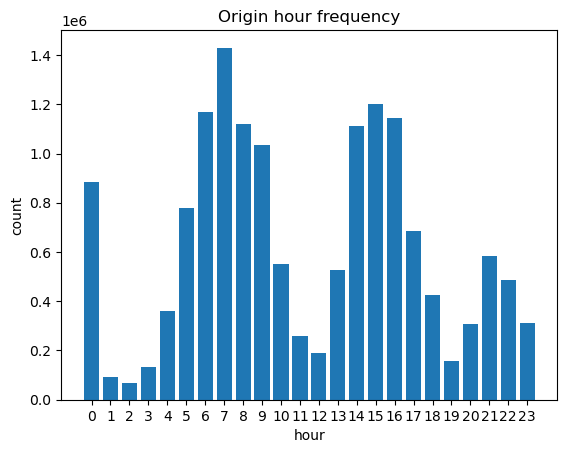

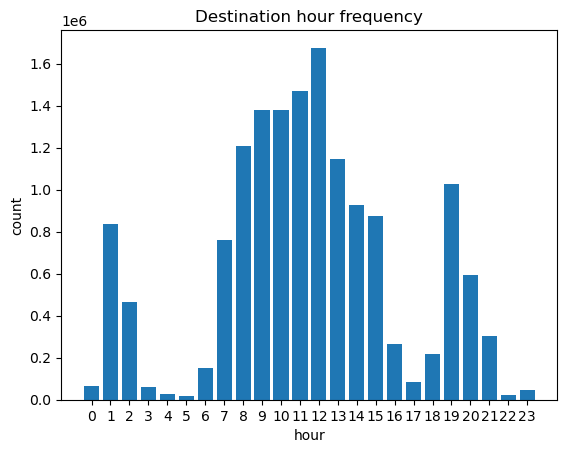

In [78]:
# exact timestamps (top 10)
exact_orig = (policy_2_greedy_moves_pldf
              .group_by("original_time").agg(pl.len().alias("count"))
              .sort("count", descending=True)
              .head(10)).to_pandas()

exact_dest = (policy_2_greedy_moves_pldf
              .group_by("proposed_shift_time").agg(pl.len().alias("count"))
              .sort("count", descending=True)
              .head(10)).to_pandas()

# hour-of-day
hour_orig = (moves_enriched.group_by("orig_hour").agg(pl.len().alias("count"))
             .sort("count", descending=True)).to_pandas()
hour_dest = (moves_enriched.group_by("dest_hour").agg(pl.len().alias("count"))
             .sort("count", descending=True)).to_pandas()

display(exact_orig.head(10))
display(exact_dest.head(10))
display(hour_orig.head(10))
display(hour_dest.head(10))

# plots
plt.figure(); plt.bar(hour_orig["orig_hour"], hour_orig["count"]); plt.title("Origin hour frequency"); plt.xlabel("hour"); plt.ylabel("count"); plt.xticks(range(24)); plt.show()
plt.figure(); plt.bar(hour_dest["dest_hour"], hour_dest["count"]); plt.title("Destination hour frequency"); plt.xlabel("hour"); plt.ylabel("count"); plt.xticks(range(24)); plt.show()


,mean,median,min,max,std,n
0,0.428672,0.323056,1.490116e-08,12553.291992,3.629109,14996536


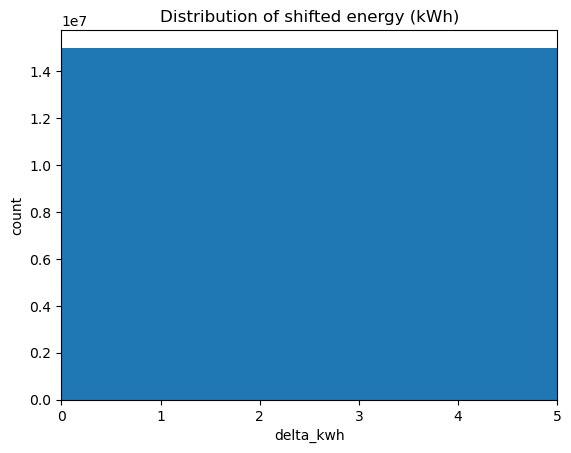

In [79]:
stats_kwh = moves_enriched.select([
    pl.col("delta_kwh").mean().alias("mean"),
    pl.col("delta_kwh").median().alias("median"),
    pl.col("delta_kwh").min().alias("min"),
    pl.col("delta_kwh").max().alias("max"),
    pl.col("delta_kwh").std().alias("std"),
    pl.len().alias("n")
]).to_pandas()
display(stats_kwh)

plt.figure()
plt.hist(moves_enriched.select("delta_kwh").to_series().to_list(), bins=400)
plt.title("Distribution of shifted energy (kWh)")
plt.xlabel("delta_kwh"); plt.ylabel("count")
plt.xlim(0,5)
plt.show()

Correlation (marg vs avg): 0.9272946237486557


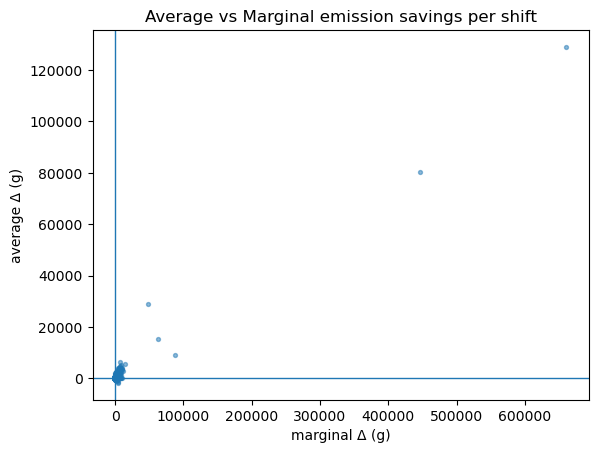

count    1.499654e+07
mean     3.349672e+01
std      1.757556e+02
min     -1.322287e+03
25%      4.927671e+00
50%      1.697401e+01
75%      4.504251e+01
max      5.312937e+05
Name: diff, dtype: float64

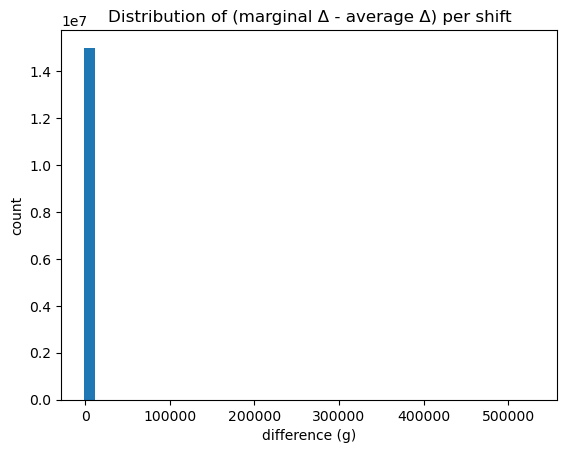

In [80]:
comp = moves_enriched.select([
    pl.col("marginal_emissions_delta_grams_co2").alias("marg"),
    pl.col("average_emissions_delta_grams_co2").alias("avg")
]).to_pandas()

comp["diff"] = comp["marg"] - comp["avg"]

print("Correlation (marg vs avg):", np.corrcoef(comp["marg"], comp["avg"])[0,1])

# scatter
plt.figure()
plt.scatter(comp["marg"], comp["avg"], s=8, alpha=0.5)
plt.title("Average vs Marginal emission savings per shift")
plt.xlabel("marginal Δ (g)"); plt.ylabel("average Δ (g)")
plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
plt.show()

# differences summary
display(comp["diff"].describe())
plt.figure()
plt.hist(comp["diff"], bins=40)
plt.title("Distribution of (marginal Δ - average Δ) per shift")
plt.xlabel("difference (g)"); plt.ylabel("count")
plt.show()


#         (pl.col("delta_kwh") > 0).alias("moved_flag"),
#         (pl.col("marginal_emissions_delta_grams_co2") > 0).alias("marginal_saving"),
#         (pl.col("average_emissions_delta_grams_co2")  > 0).alias("average_saving"),
#     ])
# )

In [81]:
# only shifts with marginal savings
marg_pos = moves_enriched.filter(pl.col("marginal_emissions_delta_grams_co2") > 0)

summary_when_marg_pos = marg_pos.select([
    pl.col("average_emissions_delta_grams_co2").mean().alias("avg_mean_g"),
    pl.col("average_emissions_delta_grams_co2").median().alias("avg_median_g"),
    pl.col("average_emissions_delta_grams_co2").min().alias("avg_min_g"),
    pl.col("average_emissions_delta_grams_co2").max().alias("avg_max_g"),
    pl.len().alias("n")
]).to_pandas()
display(summary_when_marg_pos)

# cases where marginal saves but average does not
disagree = marg_pos.filter(pl.col("average_emissions_delta_grams_co2") <= 0)
print("Shifts with marginal>0 but average<=0:", disagree.height)

# peek a few examples
disagree.select(["ca_id","city","day","original_time","proposed_shift_time","delta_kwh","marginal_emissions_delta_grams_co2","average_emissions_delta_grams_co2"]).head(10).to_pandas()


,avg_mean_g,avg_median_g,avg_min_g,avg_max_g,n
0,10.702879,4.863188,-1801.012232,129029.820841,14996536


Shifts with marginal>0 but average<=0: 2527139


,ca_id,city,day,original_time,proposed_shift_time,delta_kwh,marginal_emissions_delta_grams_co2,average_emissions_delta_grams_co2
0,60007096831,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,6.301249,730.839452,-29.323651
1,60023471331,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,0.726789,84.295424,-3.382206
2,60007240595,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,12.938595,1500.660619,-60.211375
3,60009767454,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,7.575535,878.635349,-35.253702
4,60003996448,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,2.212623,179.018010,-10.296719
5,60000123277,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,0.326544,37.873621,-1.519613
6,60006546893,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,1.948500,225.993377,-9.067588
7,60026447585,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,0.886283,102.793969,-4.124428
8,60008281226,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,7.831240,908.292838,-36.443657
9,60014947471,delhi,2022-02-21 00:00:00+05:30,2022-02-21 14:00:00+05:30,2022-02-21 12:00:00+05:30,2.889174,335.095837,-13.445133


,city,unique_customers_in_metrics,solve_time_s,moved_kwh_sum,moved_kwh_day_sum,customers_per_sec,kwh_per_sec
0,delhi,184641,4551.333894,5.195772e+06,5.195772e+06,40.568546,1141.593152
1,mumbai,53840,958.540115,1.232820e+06,1.232820e+06,56.168750,1286.143608


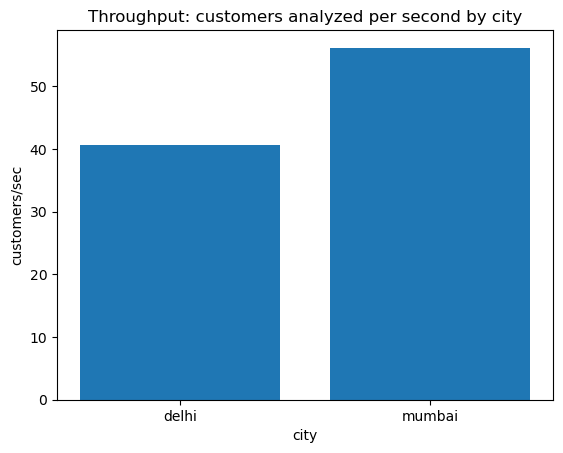

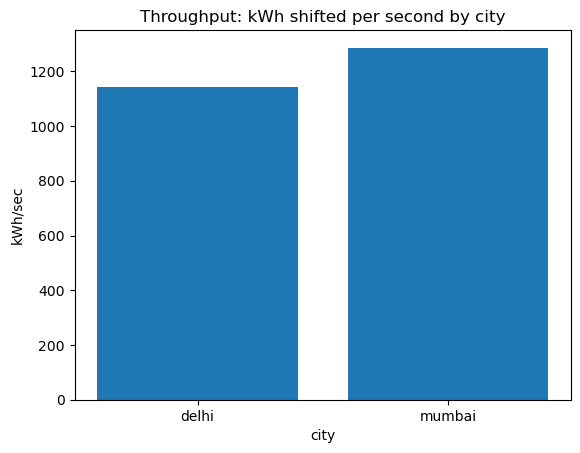

In [82]:
# guard against nulls
metrics = policy_2_greedy_metrics_pldf.with_columns([
    pl.when(pl.col("solve_wall_s").is_null()).then(0.0).otherwise(pl.col("solve_wall_s")).alias("solve_wall_s"),
    pl.when(pl.col("moved_kwh").is_null()).then(0.0).otherwise(pl.col("moved_kwh")).alias("moved_kwh"),
    pl.when(pl.col("moved_kwh_day_sum").is_null()).then(0.0).otherwise(pl.col("moved_kwh_day_sum")).alias("moved_kwh_day_sum"),
    pl.when(pl.col("n_customers_solved").is_null()).then(0).otherwise(pl.col("n_customers_solved")).alias("n_customers_solved"),
])

# per city aggregates
per_city = (metrics.group_by("city").agg([
    pl.n_unique("ca_id").alias("unique_customers_in_metrics"),
    pl.sum("solve_wall_s").alias("solve_time_s"),
    pl.sum("moved_kwh").alias("moved_kwh_sum"),
    pl.sum("moved_kwh_day_sum").alias("moved_kwh_day_sum"),
]).with_columns([
    (pl.col("unique_customers_in_metrics") / pl.col("solve_time_s")).alias("customers_per_sec").fill_null(0),
    (pl.col("moved_kwh_sum") / pl.col("solve_time_s")).alias("kwh_per_sec").fill_null(0),
]).sort("solve_time_s", descending=True)).to_pandas()

display(per_city)

plt.figure()
plt.bar(per_city["city"], per_city["customers_per_sec"])
plt.title("Throughput: customers analyzed per second by city")
plt.xlabel("city"); plt.ylabel("customers/sec")
plt.show()

plt.figure()
plt.bar(per_city["city"], per_city["kwh_per_sec"])
plt.title("Throughput: kWh shifted per second by city")
plt.xlabel("city"); plt.ylabel("kWh/sec")
plt.show()


In [83]:
overall = metrics.select([
    pl.sum("baseline_E_marg_g").alias("baseline_marg_g"),
    pl.sum("post_E_marg_g").alias("post_marg_g"),
    pl.sum("delta_E_marg_g").alias("delta_marg_g"),
    pl.sum("baseline_E_avg_g").alias("baseline_avg_g"),
    pl.sum("post_E_avg_g").alias("post_avg_g"),
    pl.sum("delta_E_avg_g").alias("delta_avg_g"),
]).to_pandas()

display(overall)

# nice print
bm = overall["baseline_marg_g"].iloc[0]; pm = overall["post_marg_g"].iloc[0]; dm = overall["delta_marg_g"].iloc[0]
ba = overall["baseline_avg_g"].iloc[0]; pa = overall["post_avg_g"].iloc[0]; da = overall["delta_avg_g"].iloc[0]

print(f"Marginal emissions: baseline={bm:,.0f} g, post={pm:,.0f} g, Δ={dm:,.0f} g ({100*dm/bm:.2f}% of baseline)")
print(f"Average  emissions: baseline={ba:,.0f} g, post={pa:,.0f} g, Δ={da:,.0f} g ({100*da/ba:.2f}% of baseline)")


,baseline_marg_g,post_marg_g,delta_marg_g,baseline_avg_g,post_avg_g,delta_avg_g
0,1.331853e+11,1.325225e+11,6.628409e+08,1.316243e+11,1.314638e+11,1.605061e+08


Marginal emissions: baseline=133,185,347,658 g, post=132,522,506,796 g, Δ=662,840,863 g (0.50% of baseline)
Average  emissions: baseline=131,624,297,955 g, post=131,463,791,842 g, Δ=160,506,113 g (0.12% of baseline)


In [84]:
# per-shift savings (marginal)
per_shift_stats = moves_enriched.select([
    pl.col("marginal_emissions_delta_grams_co2").mean().alias("marg_mean_g_per_shift"),
    pl.col("marginal_emissions_delta_grams_co2").median().alias("marg_median_g_per_shift"),
    pl.col("average_emissions_delta_grams_co2").mean().alias("avg_mean_g_per_shift"),
    pl.col("average_emissions_delta_grams_co2").median().alias("avg_median_g_per_shift"),
]).to_pandas()
display(per_shift_stats)

# per-customer-per-week (ISO week) — no .dt.isocalendar(), use strftime
weekly = (
    moves
    .with_columns([
        # ensure datetime precision is fine (optional)
        pl.col("day").dt.cast_time_unit("ns"),
        pl.col("day").dt.strftime("%G").cast(pl.Int32).alias("iso_year"),  # ISO year
        pl.col("day").dt.strftime("%V").cast(pl.Int32).alias("iso_week"),  # ISO week (01–53)
    ])
    .group_by(["city","ca_id","iso_year","iso_week"])
    .agg([
        pl.sum("marginal_emissions_delta_grams_co2").alias("weekly_marg_g"),
        pl.sum("average_emissions_delta_grams_co2").alias("weekly_avg_g"),
        pl.sum("delta_kwh").alias("weekly_shifted_kwh"),
        pl.len().alias("weekly_n_shifts"),
    ])
)

weekly_stats = weekly.select([
    pl.col("weekly_marg_g").mean().alias("marg_mean_g_per_customer_week"),
    pl.col("weekly_marg_g").median().alias("marg_median_g_per_customer_week"),
    pl.col("weekly_avg_g").mean().alias("avg_mean_g_per_customer_week"),
    pl.col("weekly_avg_g").median().alias("avg_median_g_per_customer_week"),
    pl.col("weekly_shifted_kwh").mean().alias("kwh_mean_per_customer_week"),
    pl.col("weekly_n_shifts").mean().alias("shifts_mean_per_customer_week"),
]).to_pandas()

display(weekly_stats)


,marg_mean_g_per_shift,marg_median_g_per_shift,avg_mean_g_per_shift,avg_median_g_per_shift
0,44.199598,26.132967,10.702879,4.863188


,marg_mean_g_per_customer_week,marg_median_g_per_customer_week,avg_mean_g_per_customer_week,avg_median_g_per_customer_week,kwh_mean_per_customer_week,shifts_mean_per_customer_week
0,129.492315,88.753176,31.356407,18.557979,1.255887,2.929717


,orig_hour,dest_hour,n_shifts,marg_mean_g,marg_median_g,marg_sum_g,mean_kwh
0,16,15,312932,80.537579,63.279804,2.520279e+07,0.648023
1,15,15,49503,73.903384,64.546469,3.658439e+06,0.716483
2,6,8,1111194,73.203971,57.774394,8.134381e+07,0.448177
3,17,15,484730,70.382859,47.160308,3.411668e+07,0.581574
4,15,14,164194,59.662855,37.954036,9.796283e+06,0.540445
5,15,13,981523,59.511722,43.281004,5.841212e+07,0.469437
6,0,1,697678,58.662945,45.104045,4.092785e+07,0.629959
7,5,7,718265,56.806357,35.137194,4.080202e+07,0.358746
8,14,12,996282,55.687281,42.644505,5.548024e+07,0.480089
9,4,3,8787,55.263579,45.236171,4.856011e+05,0.598125


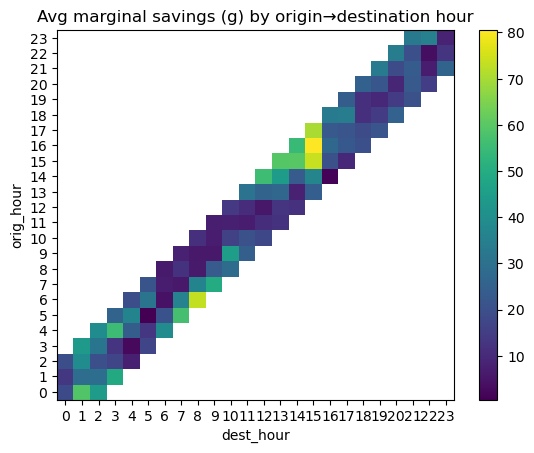

In [85]:
pair_stats = (moves_enriched
    .group_by(["orig_hour","dest_hour"])
    .agg([
        pl.len().alias("n_shifts"),
        pl.mean("marginal_emissions_delta_grams_co2").alias("marg_mean_g"),
        pl.median("marginal_emissions_delta_grams_co2").alias("marg_median_g"),
        pl.sum("marginal_emissions_delta_grams_co2").alias("marg_sum_g"),
        pl.mean("delta_kwh").alias("mean_kwh"),
    ])
    .sort(["marg_mean_g"], descending=True)
)

display(pair_stats.head(20).to_pandas())

# heatmap of average marginal savings by hour pair
pivot = pair_stats.select(["orig_hour","dest_hour","marg_mean_g"]).to_pandas().pivot(index="orig_hour", columns="dest_hour", values="marg_mean_g")
plt.figure()
plt.imshow(pivot.values, aspect="auto", origin="lower")
plt.title("Avg marginal savings (g) by origin→destination hour")
plt.xlabel("dest_hour"); plt.ylabel("orig_hour")
plt.colorbar()
plt.xticks(range(24)); plt.yticks(range(24))
plt.show()


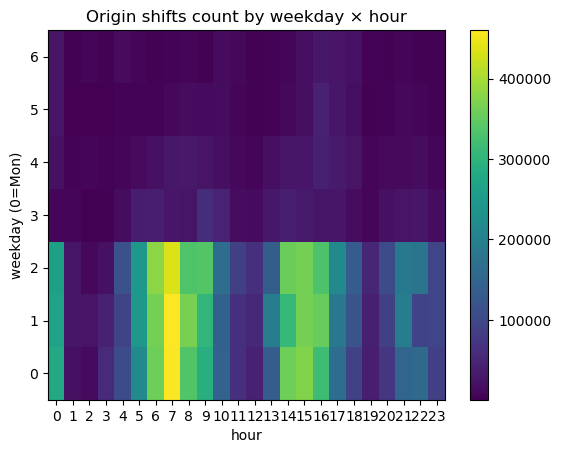

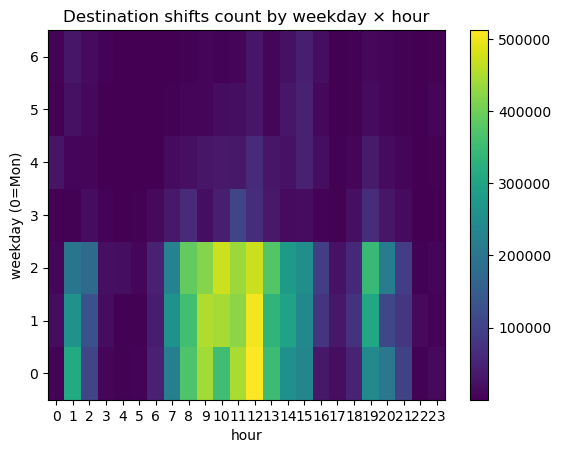

In [86]:
# count by weekday-hour for origins and destinations
orig_count = (moves_enriched.group_by(["orig_wday","orig_hour"]).agg(pl.len().alias("count")).to_pandas())
dest_count = (moves_enriched.group_by(["dest_wday","dest_hour"]).agg(pl.len().alias("count")).to_pandas())

# heatmaps
orig_pivot = orig_count.pivot(index="orig_wday", columns="orig_hour", values="count").fillna(0)
dest_pivot = dest_count.pivot(index="dest_wday", columns="dest_hour", values="count").fillna(0)

plt.figure(); plt.imshow(orig_pivot.values, aspect="auto", origin="lower")
plt.title("Origin shifts count by weekday × hour"); plt.xlabel("hour"); plt.ylabel("weekday (0=Mon)")
plt.colorbar(); plt.xticks(range(24)); plt.yticks(range(7))
plt.show()

plt.figure(); plt.imshow(dest_pivot.values, aspect="auto", origin="lower")
plt.title("Destination shifts count by weekday × hour"); plt.xlabel("hour"); plt.ylabel("weekday (0=Mon)")
plt.colorbar(); plt.xticks(range(24)); plt.yticks(range(7))
plt.show()


##### Shift direction frequency

/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_54984/1979957461.py:2: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  moves_enriched.group_by("shift_direction").count()


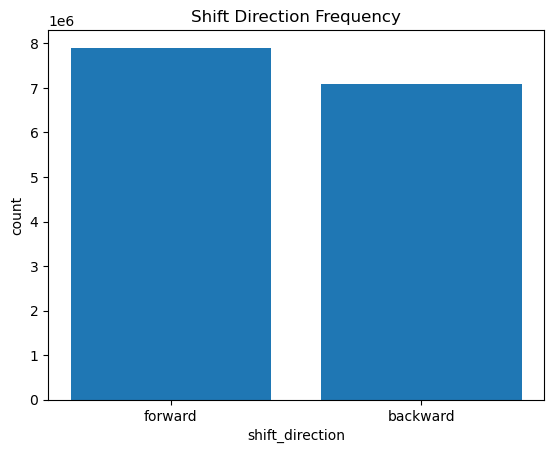

In [114]:
direction_counts = (
    moves_enriched.group_by("shift_direction").count()
                  .sort("count", descending=True)
)
direction_counts

# Simple bar
pdf = to_pd(direction_counts)
plt.figure()
plt.bar(pdf["shift_direction"], pdf["count"])
plt.title("Shift Direction Frequency")
plt.xlabel("shift_direction")
plt.ylabel("count")
plt.show()


In [155]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

# --- Helper: ensure we have hour + direction columns -------------------------
def _enrich_moves(moves: pl.DataFrame | pl.LazyFrame) -> pl.LazyFrame:
    lf = moves.lazy()
    # direction from column if present, else derive from delta_minutes
    dir_expr = (
        pl.when(pl.col("delta_minutes") > 0).then(pl.lit("forward"))
          .when(pl.col("delta_minutes") < 0).then(pl.lit("backward"))
          .otherwise(pl.lit("zero"))
    )
    direction = (pl.when(pl.col("shift_direction").is_not_null())
                  .then(pl.col("shift_direction").cast(pl.Utf8))
                  .otherwise(dir_expr).alias("direction"))

    return (
        lf.with_columns([
            pl.col("original_time").dt.hour().alias("orig_hour"),
            pl.col("proposed_shift_time").dt.hour().alias("dest_hour"),
            pl.col("delta_minutes").cast(pl.Int32),
            direction
        ])
    )

# --- Helper: aggregate counts by hour × direction and return tidy pandas -----
def _counts_by_hour_direction(lf: pl.LazyFrame, hour_col: str, include_zero: bool) -> pd.DataFrame:
    out = (
        lf.group_by([hour_col, "direction"])
        .agg(pl.col("delta_kwh").sum().alias("n"))   # <— weight by kWh moved
        .collect()
        .to_pandas()
    )
    # Pivot to wide (columns: direction) then reindex to hours 0..23
    wide = (out.pivot(index=hour_col, columns="direction", values="n")
               .reindex(range(24), fill_value=0))
    # Optionally drop the zero-direction column
    if not include_zero and "zero" in wide.columns:
        wide = wide.drop(columns=["zero"])
    # Ensure forward/backward columns exist
    for col in ["forward", "backward"]:
        if col not in wide.columns:
            wide[col] = 0
    return wide[["forward", "backward"]]

def plot_dual_direction_bars_by_hour(
    moves: pl.DataFrame | pl.LazyFrame,
    *,
    include_zero_category: bool = False,
    normalize_to_share: bool = False,  # if True, y-axis is share (0–1)
    bar_width: float = 0.4,
    title: str = "Shift direction by hour (origin vs destination)",
    legend_outside: str = "right",     # "right" | "bottom" | "none"
    ):
    lf = _enrich_moves(moves)

    orig_wide = _counts_by_hour_direction(lf, "orig_hour", include_zero_category)
    dest_wide = _counts_by_hour_direction(lf, "dest_hour", include_zero_category)

    if normalize_to_share:
        orig_wide = orig_wide.div(orig_wide.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)
        dest_wide = dest_wide.div(dest_wide.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    hours = np.arange(24)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    for ax, wide, title_side in [
        (axes[0], orig_wide, "Source hour (origin)"),
        (axes[1], dest_wide, "Destination hour"),
    ]:
        ax.bar(hours, wide["forward"].values, label="Forward (later)")
        ax.bar(hours, wide["backward"].values, bottom=wide["forward"].values, label="Backward (earlier)")
        ax.set_title(title_side)
        ax.set_xlabel("Hour of day")
        if normalize_to_share:
            ax.set_ylabel("Share of moves")
            ax.set_ylim(0, 1)
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f"{y:.0%}"))
        else:
            ax.set_ylabel("Count of moves")
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f"{int(y):,}"))
            ax.ticklabel_format(style="plain", axis="y")
        ax.set_xlim(-0.5, 23.5)
        ax.xaxis.set_major_locator(MultipleLocator(4))
        ax.xaxis.set_minor_locator(MultipleLocator(2))
        ax.grid(True, axis="y", alpha=0.3)
        # no per-axes legend here

    # --- single shared legend outside ---
    if legend_outside != "none":
        handles, labels = axes[0].get_legend_handles_labels()
        if legend_outside == "right":
            fig.legend(handles, labels, loc="center left",
                       bbox_to_anchor=(1.0, 0.5), frameon=False, title="Direction")
            fig.tight_layout(rect=[0, 0, 0.86, 0.95])  # leave room on the right
        elif legend_outside == "bottom":
            fig.legend(handles, labels, loc="lower center", ncol=2,
                       bbox_to_anchor=(0.5, -0.02), frameon=False, title="Direction")
            fig.tight_layout(rect=[0, 0.08, 1, 0.95])  # leave room at the bottom

    fig.suptitle(title, y=0.98, fontsize=14)
    if legend_outside == "none":
        fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# --- Histogram: shift size (delta_minutes) centered at 0, 30-min bins --------
def plot_shift_minutes_hist(
    moves: pl.DataFrame | pl.LazyFrame,
    *,
    bin_width_min: int = 30,
    limit_min: int = 120,
    title: str = "Distribution of shift size (minutes)",
):
    lf = _enrich_moves(moves)
    dm = (lf.select(pl.col("delta_minutes")).collect()["delta_minutes"].to_numpy())
    # bins centered at 0: ..., -90, -60, -30, 0, 30, 60, 90, ...
    edges = np.arange(-limit_min, limit_min + bin_width_min, bin_width_min)

    fig, ax = plt.subplots(figsize=(8, 4.5))
    ax.hist(dm, bins=edges, align="mid")
    ax.set_title(title)
    ax.set_xlabel("Shift size (minutes)\n (negative=earlier, positive=later)")
    ax.set_ylabel("Count of Shifts")

    # Remove the ticklabel_format call since we're using FuncFormatter
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f"{int(y):,}"))

    # vertical line at 0
    ax.axvline(0, linestyle="--", linewidth=1)
    # x ticks every 30, label every 60 for clarity
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(30))
    ax.grid(True, axis="y", alpha=0.3)
    fig.tight_layout()
    plt.show()

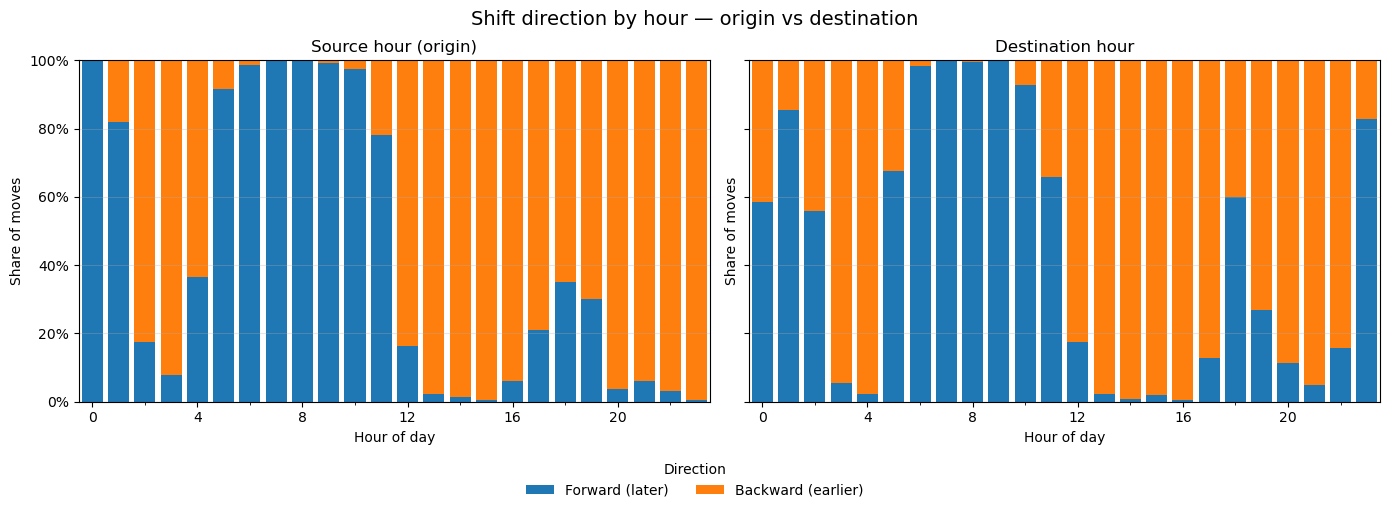

In [156]:
# 1) Dual bars: counts by hour (origin vs destination), forward vs backward
plot_dual_direction_bars_by_hour(
    moves,
    include_zero_category=False,      # set True if you also want “zero” shifts tracked
    normalize_to_share=True,         # set True to show shares instead of counts
    title="Shift direction by hour — origin vs destination",
    legend_outside="bottom"
)


In [157]:
def plot_direction_bars_by_hour_source(
    moves: pl.DataFrame | pl.LazyFrame,
    *,
    include_zero_category: bool = False,
    normalize_to_share: bool = True,   # True: show shares; False: show totals
    title: str = "Shift direction by hour — source (origin)",
    legend_outside: str = "bottom",    # "bottom" | "none"
):
    # Build hour/direction view for origin hours
    lf = _enrich_moves(moves)
    wide = _counts_by_hour_direction(lf, "orig_hour", include_zero_category)  # sums kWh moved

    # Normalize to within-hour shares if requested
    if normalize_to_share:
        wide = wide.div(wide.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    hours = np.arange(24)
    fig, ax = plt.subplots(figsize=(10, 5))

    # Stacked bars: forward on bottom, backward on top
    ax.bar(hours, wide["forward"].values, label="Forward (later)")
    ax.bar(hours, wide["backward"].values, bottom=wide["forward"].values, label="Backward (earlier)")

    # Labels, ticks, grid
    ax.set_title("Source hour (origin)")
    ax.set_xlabel("Hour of day")
    if normalize_to_share:
        ax.set_ylabel("Share of moves")
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f"{y:.0%}"))
    else:
        ax.set_ylabel("Total moved kWh")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: f"{int(y):,}"))
        ax.ticklabel_format(style="plain", axis="y")

    ax.set_xlim(-0.5, 23.5)
    ax.xaxis.set_major_locator(MultipleLocator(4))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.grid(True, axis="y", alpha=0.3)

    # Figure title
    fig.suptitle(title, y=0.98, fontsize=14)

    # Legend outside (bottom)
    if legend_outside == "bottom":
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=2,
                   bbox_to_anchor=(0.5, -0.02), frameon=False, title="Direction")
        fig.tight_layout(rect=[0, 0.08, 1, 0.94])
    else:
        fig.tight_layout(rect=[0, 0, 1, 0.94])

    plt.show()


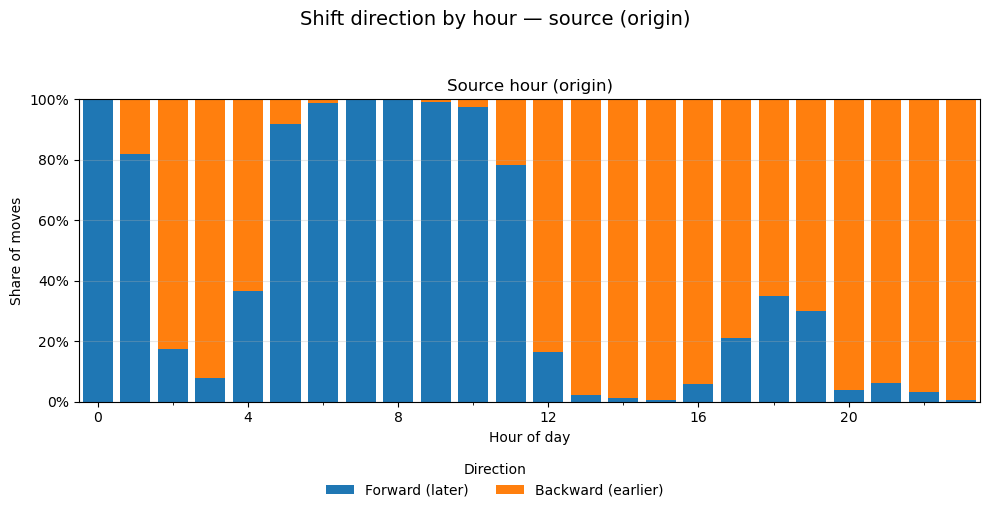

In [158]:
plot_direction_bars_by_hour_source(
    moves,
    include_zero_category=False,
    normalize_to_share=True,
    title="Shift direction by hour — source (origin)",
    legend_outside="bottom"
)


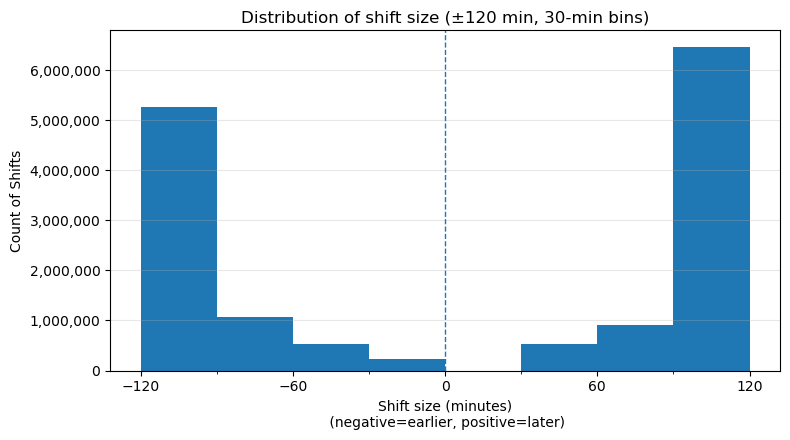

In [159]:
# 2) Histogram of shift size in minutes, 30-min bins from -120..+120
plot_shift_minutes_hist(
    moves,
    bin_width_min=30,
    limit_min=120,
    title="Distribution of shift size (±120 min, 30-min bins)",

)

##### Most frequent origin & destination hours

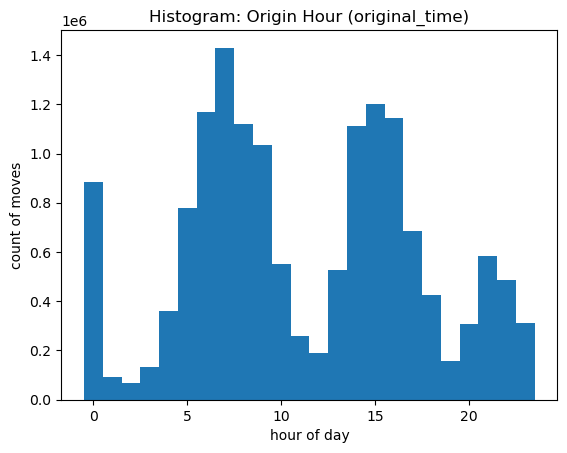

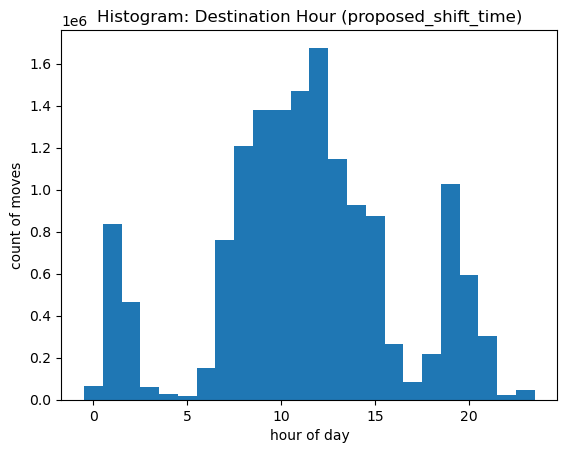

In [88]:
top_orig_hours = (
    moves_enriched.group_by("orig_hour").len()
                  .sort("len", descending=True)
)
top_dest_hours = (
    moves_enriched.group_by("dest_hour").len()
                  .sort("len", descending=True)
)
top_orig_hours.head(10), top_dest_hours.head(10)

# Histograms of origin/destination hour-of-day
for col, title in [("orig_hour","Origin Hour (original_time)"),
                   ("dest_hour","Destination Hour (proposed_shift_time)")]:
    pdf = to_pd(moves_enriched.select(col))
    plt.figure()
    plt.hist(pdf[col], bins=np.arange(-0.5,24.5,1))
    plt.title(f"Histogram: {title}")
    plt.xlabel("hour of day")
    plt.ylabel("count of moves")
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import polars as pl

def plot_hour_histograms(
    moves_enriched: pl.DataFrame,
    *,
    figsize=(12, 4),
    bins=np.arange(-0.5, 24.5, 1),
    rwidth=0.9,
    edgecolor="none",
    alpha=0.9,
    major_xtick_every=4,
    minor_xtick_every=2,
    y_formatter=None,      # e.g., ticker.StrMethodFormatter('{x:,.0f}') or custom FuncFormatter
    y_max=None,            # set a number to cap; None → auto from data
    suptitle="Moves by Hour (origin vs destination)",
):
    # pull the two series safely
    pdf = moves_enriched.select(["orig_hour", "dest_hour"]).to_pandas()
    orig = pdf["orig_hour"].dropna().to_numpy()
    dest = pdf["dest_hour"].dropna().to_numpy()

    # compute a common ymax if not provided
    if y_max is None:
        c1, _ = np.histogram(orig, bins=bins)
        c2, _ = np.histogram(dest, bins=bins)
        y_max = max(c1.max() if c1.size else 0, c2.max() if c2.size else 0) * 1.05

    # default y-axis formatting: 1,234 style
    if y_formatter is None:
        y_formatter = ticker.StrMethodFormatter('{x:,.0f}')

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
    hours = np.arange(24)

    # left: origin hours
    ax = axes[0]
    ax.hist(orig, bins=bins, rwidth=rwidth, edgecolor=edgecolor, alpha=alpha)
    ax.set_title("Origin Hour (original_time)")
    ax.set_xlabel("Hour of day")
    ax.set_ylabel("Count of Time Slots")
    ax.set_ylim(0, y_max)
    ax.grid(True, axis="y", linestyle=":", alpha=0.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_xtick_every))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_xtick_every))
    ax.yaxis.set_major_formatter(y_formatter)
    ax.ticklabel_format(axis="x", style="plain")
    ax.set_xticks(hours[::major_xtick_every])

    # right: destination hours
    ax = axes[1]
    ax.hist(dest, bins=bins, rwidth=rwidth, edgecolor=edgecolor, alpha=alpha)
    ax.set_title("Destination Hour (proposed_shift_time)")
    ax.set_xlabel("Hour of day")
    ax.set_ylim(0, y_max)
    ax.grid(True, axis="y", linestyle=":", alpha=0.5)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(major_xtick_every))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(minor_xtick_every))
    ax.yaxis.set_major_formatter(y_formatter)
    ax.ticklabel_format(axis="x", style="plain")
    ax.set_xticks(hours[::major_xtick_every])

    fig.suptitle(suptitle, y=1.04)
    fig.tight_layout()
    return fig, axes


(<Figure size 1200x400 with 2 Axes>,
 array([<Axes: title={'center': 'Origin Hour (original_time)'}, xlabel='Hour of day', ylabel='Count of Time Slots'>,
        <Axes: title={'center': 'Destination Hour (proposed_shift_time)'}, xlabel='Hour of day'>],
       dtype=object))

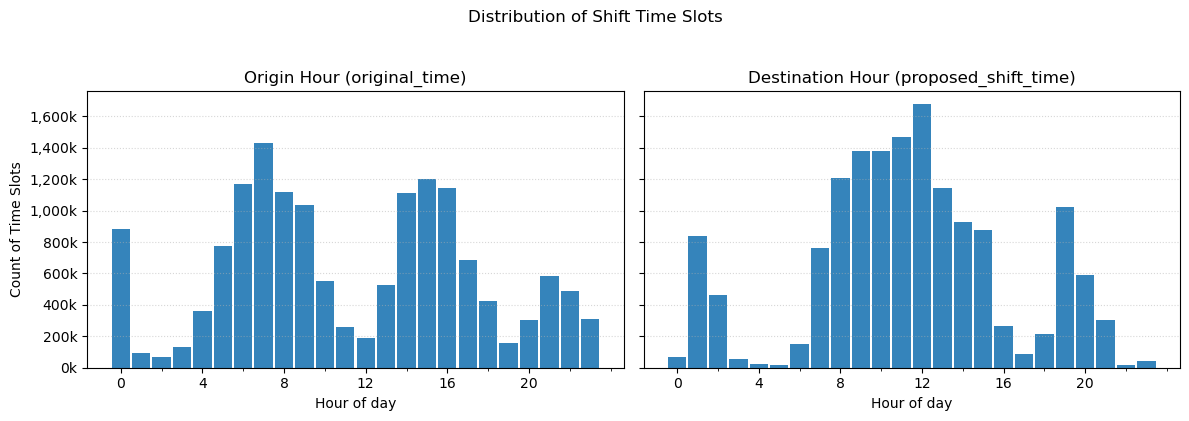

In [103]:
from matplotlib.ticker import FuncFormatter
kfmt = FuncFormatter(lambda x, pos: f"{x/1_000:,.0f}k")
plot_hour_histograms(moves_enriched, y_formatter=kfmt, suptitle="Distribution of Shift Time Slots")


##### Power shifted (kWh): distribution, avg, min, max

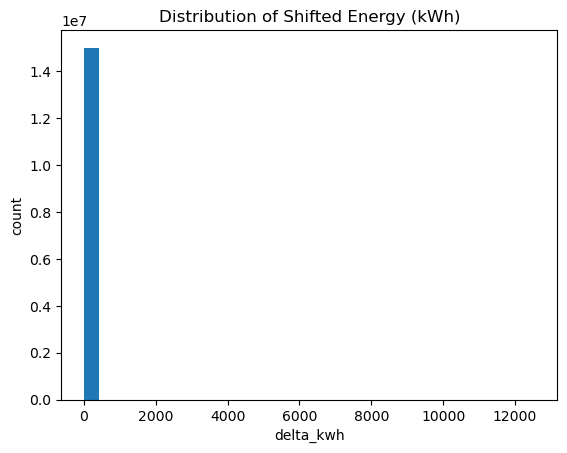

In [89]:
delta_stats = (
    moves_enriched
    .select([
        pl.col("delta_kwh").mean().alias("mean_kwh"),
        pl.col("delta_kwh").median().alias("median_kwh"),
        pl.col("delta_kwh").min().alias("min_kwh"),
        pl.col("delta_kwh").max().alias("max_kwh"),
        pl.col("delta_kwh").quantile(0.25).alias("q25"),
        pl.col("delta_kwh").quantile(0.75).alias("q75"),
    ])
)
delta_stats

pdf = to_pd(moves_enriched.select("delta_kwh"))
plt.figure()
plt.hist(pdf["delta_kwh"], bins=30)
plt.title("Distribution of Shifted Energy (kWh)")
plt.xlabel("delta_kwh")
plt.ylabel("count")
plt.show()


##### Marginal emissions delta (gCO₂): dist, avg, min, max (+ compare to average emissions)

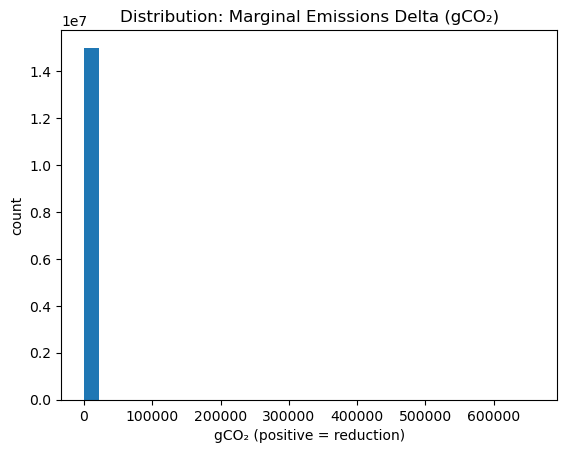

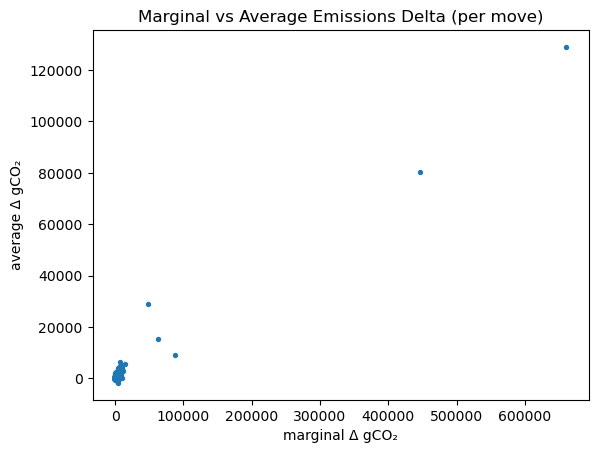

In [90]:
em_stats = (
    moves_enriched
    .select([
        pl.col("marginal_emissions_delta_grams_co2").mean().alias("mean_marginal_g"),
        pl.col("marginal_emissions_delta_grams_co2").median().alias("median_marginal_g"),
        pl.col("marginal_emissions_delta_grams_co2").min().alias("min_marginal_g"),
        pl.col("marginal_emissions_delta_grams_co2").max().alias("max_marginal_g"),
        pl.col("average_emissions_delta_grams_co2").mean().alias("mean_average_g"),
        pl.col("average_emissions_delta_grams_co2").median().alias("median_average_g"),
    ])
)
em_stats

# Hist of marginal deltas
pdf = to_pd(moves_enriched.select("marginal_emissions_delta_grams_co2"))
plt.figure()
plt.hist(pdf["marginal_emissions_delta_grams_co2"], bins=30)
plt.title("Distribution: Marginal Emissions Delta (gCO₂)")
plt.xlabel("gCO₂ (positive = reduction)")
plt.ylabel("count")
plt.show()

# Scatter: marginal vs average deltas
pdf2 = to_pd(moves_enriched.select(["marginal_emissions_delta_grams_co2",
                                    "average_emissions_delta_grams_co2"]))
plt.figure()
plt.scatter(pdf2["marginal_emissions_delta_grams_co2"],
            pdf2["average_emissions_delta_grams_co2"], s=8)
plt.title("Marginal vs Average Emissions Delta (per move)")
plt.xlabel("marginal Δ gCO₂")
plt.ylabel("average Δ gCO₂")
plt.show()


##### When marginal savings > 0, what’s the comparable average-emissions saving?

In [91]:
# TZ = "Asia/Kolkata"
# AVG_COL  = "average_emissions_grams_co2_per_kWh"
# MARG_COL = "pg_marginal_emissions_grams_co2_per_kWh_calibrated"

# # -------------------- 1) flexible baseline & post from moves + optimised --------------------
# # Net shift per (city, day, 30-min bin): destination +, origin -
# moves = (
#     policy_2_greedy_moves_pldf
#     .select([
#         pl.col("city").cast(pl.Utf8),
#         pl.col("original_time").dt.convert_time_zone(TZ).alias("orig_ts"),
#         pl.col("proposed_shift_time").dt.convert_time_zone(TZ).alias("dest_ts"),
#         pl.col("delta_kwh").cast(pl.Float64),
#     ])
#     .filter(pl.col("delta_kwh") > 0)
#     .with_columns([
#         pl.col("orig_ts").dt.truncate("30m").alias("orig_bin30"),
#         pl.col("dest_ts").dt.truncate("30m").alias("dest_bin30"),
#         pl.col("orig_ts").dt.date().alias("orig_day"),
#         pl.col("dest_ts").dt.date().alias("dest_day"),
#     ])
# )

# orig_side = (
#     moves.group_by(["city","orig_day","orig_bin30"])
#          .agg((pl.col("delta_kwh") * -1).sum().alias("net_kwh"))
#          .rename({"orig_day":"day","orig_bin30":"bin30"})
# )
# dest_side = (
#     moves.group_by(["city","dest_day","dest_bin30"])
#          .agg(pl.col("delta_kwh").sum().alias("net_kwh"))
#          .rename({"dest_day":"day","dest_bin30":"bin30"})
# )

# net_30m = (
#     pl.concat([orig_side, dest_side])
#     .group_by(["city","day","bin30"])
#     .agg(pl.sum("net_kwh").alias("net_kwh"))
#     .with_columns(pl.col("bin30").dt.cast_time_unit("us"))
# )

# # Optimized flexible kWh per 30-min bin
# opt_flex_30m = (
#     policy_2_greedy_optimised_pldf
#     .select([
#         pl.col("city").cast(pl.Utf8),
#         pl.col("date").dt.convert_time_zone(TZ).alias("bin30"),
#         pl.col("optimised_value").cast(pl.Float64).alias("opt_flex_kwh")
#     ])
#     .group_by(["city","bin30"]).agg(pl.sum("opt_flex_kwh").alias("opt_flex_kwh"))
#     .with_columns([
#         pl.col("bin30").dt.cast_time_unit("us"),
#         pl.col("bin30").dt.date().alias("day"),
#     ])
# )

# flex_compare_30m = (
#     opt_flex_30m
#     .join(net_30m, on=["city","day","bin30"], how="left")
#     .with_columns(pl.col("net_kwh").fill_null(0.0))
#     .with_columns((pl.col("opt_flex_kwh") - pl.col("net_kwh")).alias("base_flex_kwh"))
# )

# # -------------------- 2) join emission factors per 30-min bin --------------------
# ef_30m = (
#     national_emission_factors
#     .select([
#         pl.col("timestamp").dt.convert_time_zone(TZ).alias("ts"),
#         pl.col(AVG_COL).cast(pl.Float64),
#         pl.col(MARG_COL).cast(pl.Float64),
#     ])
#     .with_columns(pl.col("ts").dt.truncate("30m").alias("bin30"))
#     .group_by("bin30")  # in case of duplicates
#     .agg([
#         pl.col(AVG_COL).mean().alias("avg_gpkwh"),
#         pl.col(MARG_COL).mean().alias("marg_gpkwh"),
#     ])
#     .with_columns(pl.col("bin30").dt.cast_time_unit("us"))
# )

# compare_em_30m = (
#     flex_compare_30m
#     .join(ef_30m, on="bin30", how="inner")  # keep bins with EF
#     .with_columns([
#         (pl.col("base_flex_kwh") * pl.col("avg_gpkwh")).alias("baseline_avg_g"),
#         (pl.col("opt_flex_kwh")  * pl.col("avg_gpkwh")).alias("post_avg_g"),
#         (pl.col("base_flex_kwh") * pl.col("marg_gpkwh")).alias("baseline_marg_g"),
#         (pl.col("opt_flex_kwh")  * pl.col("marg_gpkwh")).alias("post_marg_g"),
#         pl.col("bin30").dt.hour().alias("hour"),
#     ])
# )

# # -------------------- 3) region-wide hourly totals (kWh and emissions) --------------------
# # kWh (flexible-only), if you want to plot load too:
# region_hour_kwh = (
#     flex_compare_30m
#     .with_columns(pl.col("bin30").dt.hour().alias("hour"))
#     .group_by("hour")
#     .agg([
#         pl.sum("base_flex_kwh").alias("baseline_kwh"),
#         pl.sum("opt_flex_kwh").alias("post_kwh"),
#     ])
#     .sort("hour")
# ).to_pandas()

# # Emissions → convert g → tons
# avg_hour = (
#     compare_em_30m
#     .group_by("hour")
#     .agg([
#         pl.sum("baseline_avg_g").alias("baseline_g"),
#         pl.sum("post_avg_g").alias("post_g"),
#     ])
#     .sort("hour")
#     .with_columns([
#         (pl.col("baseline_g")/1_000_000).alias("baseline_t"),
#         (pl.col("post_g")/1_000_000).alias("post_t"),
#     ])
#     .select(["hour","baseline_t","post_t"])
# ).to_pandas()

# marg_hour = (
#     compare_em_30m
#     .group_by("hour")
#     .agg([
#         pl.sum("baseline_marg_g").alias("baseline_g"),
#         pl.sum("post_marg_g").alias("post_g"),
#     ])
#     .sort("hour")
#     .with_columns([
#         (pl.col("baseline_g")/1_000_000).alias("baseline_t"),
#         (pl.col("post_g")/1_000_000).alias("post_t"),
#     ])
#     .select(["hour","baseline_t","post_t"])
# ).to_pandas()

# # -------------------- 4) two-panel plot (AVG vs MARG in tons), nice formatting --------------------
# def format_tons_yaxis(ax, formatter: str | None = None, ylim: tuple | None = None):
#     """
#     formatter examples:
#       "{x:.1f} t"        -> 1 decimal
#       "{x:,.0f} t"       -> thousands with no decimals
#       None               -> plain numbers (no sci notation)
#     """
#     if formatter:
#         ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: formatter.format(x=x)))
#     else:
#         ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
#         ax.ticklabel_format(style='plain', axis='y')
#     if ylim:
#         ax.set_ylim(*ylim)

# hours = np.arange(24)
# fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

# # Panel 1: Average EF
# ax1 = axes[0]
# ax1.plot(avg_hour["hour"], avg_hour["baseline_t"], marker="o", label="Baseline (avg)")
# ax1.plot(avg_hour["hour"], avg_hour["post_t"],     marker="o", label="Post (avg)")
# ax1.set_title("Average Emissions Factors")
# ax1.set_xlabel("Hour"); ax1.set_ylabel("tCO₂")
# ax1.set_xticks(range(0,24,2))
# ax1.grid(True, alpha=0.3)
# ax1.legend()
# ax1.ticklabel_format(style='plain', axis='x')  # no sci notation on X
# format_tons_yaxis(ax1, formatter=None)         # <- customize if you want

# # Panel 2: Marginal EF
# ax2 = axes[1]
# ax2.plot(marg_hour["hour"], marg_hour["baseline_t"], marker="o", label="Baseline (marginal)")
# ax2.plot(marg_hour["hour"], marg_hour["post_t"],     marker="o", label="Post (marginal)")
# ax2.set_title("Marginal Emissions Factors")
# ax2.set_xlabel("Hour"); ax2.set_ylabel("tCO₂")
# ax2.set_xticks(range(0,24,2))
# ax2.grid(True, alpha=0.3)
# ax2.legend()
# ax2.ticklabel_format(style='plain', axis='x')
# format_tons_yaxis(ax2, formatter=None)

# fig.suptitle("Hourly Emissions — Baseline vs Post (Flexible Load Only)", y=1.02, fontsize=13)
# fig.tight_layout()
# plt.show()

# # (Optional) quick conservation check on the flexible layer:
# check_conservation = (
#     net_30m.group_by(["city","day"]).agg(pl.sum("net_kwh").alias("net_day_sum_kwh")).to_pandas()
# )
# print("Max |net_day_sum_kwh| (flex layer; should be ~0):",
#       float(check_conservation["net_day_sum_kwh"].abs().max()))


In [92]:
national_emission_factors_full_pldf

average_emissions_grams_co2_per_kWh,timestamp,demand_met_kWh,quantile_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh,pg_marginal_emissions_grams_co2_per_kWh_calibrated,National MW Shift,Pearson R Score,Spearman Score,Confidence Level
f64,"datetime[μs, Asia/Kolkata]",f64,f64,f64,f64,f64,f64,f64,str
802.033059,2021-01-01 00:00:00 IST,6.4741e7,1019.474915,975.287688,1005.087922,3102.666667,0.55606,0.587619,"""medium"""
808.4177,2021-01-01 00:30:00 IST,6.3078e7,1017.348058,990.645477,1039.275896,2087.583333,0.5321,0.571076,"""medium"""
811.554595,2021-01-01 01:00:00 IST,6.2424875e7,1049.469712,972.448151,998.76683,1455.125,0.479428,0.539555,"""medium"""
808.966393,2021-01-01 01:30:00 IST,6.1435e7,1049.641954,917.840625,877.205015,1698.0,0.503676,0.552412,"""medium"""
806.104596,2021-01-01 02:00:00 IST,6.0568e7,1057.557294,868.783074,767.998002,1411.583333,0.47798,0.538592,"""medium"""
…,…,…,…,…,…,…,…,…,…
687.919301,2025-05-31 21:30:00 IST,1.0404e8,685.357381,730.640632,460.479111,1528.125,0.484789,0.542533,"""medium"""
687.28651,2025-05-31 22:00:00 IST,1.0475e8,680.709674,726.951792,452.267384,1715.666667,0.505299,0.553196,"""medium"""
686.737951,2025-05-31 22:30:00 IST,1.0612e8,671.795602,721.221054,439.510189,1836.25,0.516378,0.55855,"""medium"""


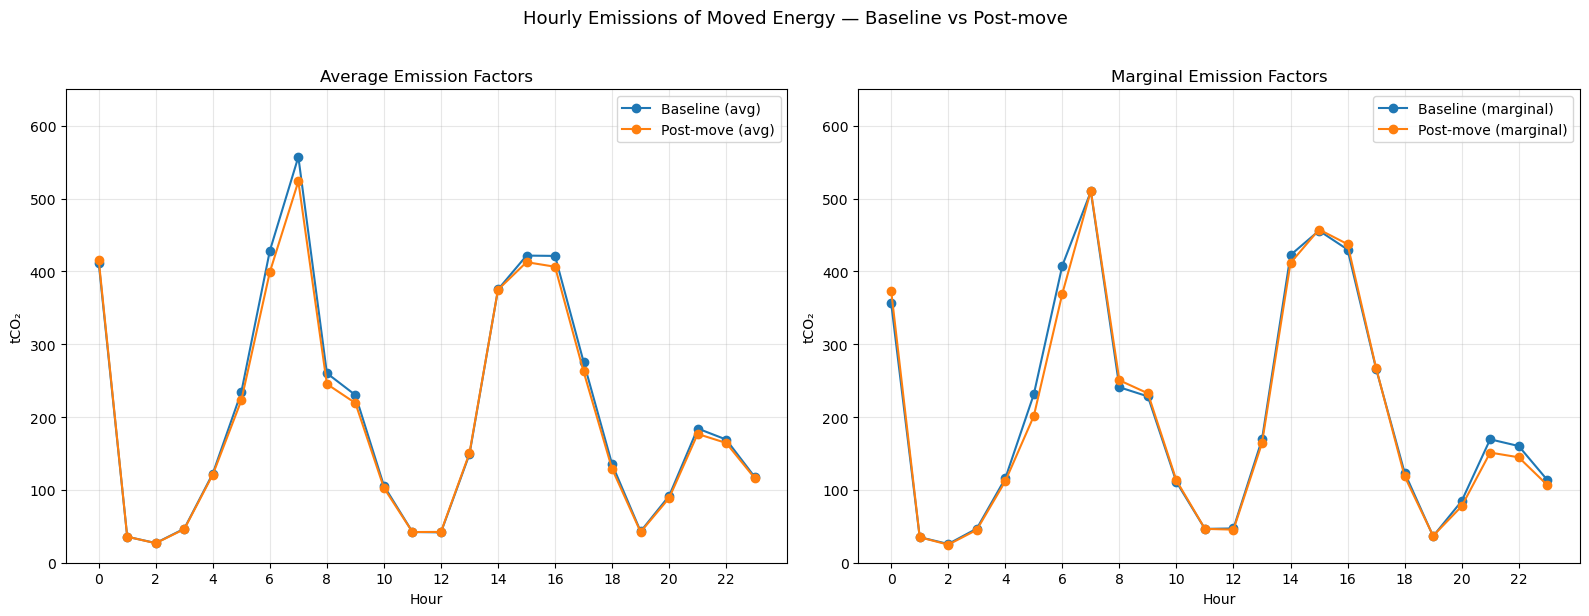

In [182]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

TZ = "Asia/Kolkata"

AVG_COL  = "average_emissions_grams_co2_per_kWh"
MARG_COL = "pg_marginal_emissions_grams_co2_per_kWh_calibrated"

# ---- collapse EFs to 30-min bins (in your local TZ), 1 row per bin ----
ef_30m = (
    national_emission_factors_full_pldf
    .select([
        pl.col("timestamp").dt.convert_time_zone(TZ).alias("ts"),
        pl.col(AVG_COL).cast(pl.Float64).alias("avg_gpkwh"),
        pl.col(MARG_COL).cast(pl.Float64).alias("marg_gpkwh"),
    ])
    .with_columns(pl.col("ts").dt.truncate("30m").alias("bin30"))
    .group_by("bin30").agg([
        pl.mean("avg_gpkwh").alias("avg_gpkwh"),
        pl.mean("marg_gpkwh").alias("marg_gpkwh"),
    ])
    .with_columns(pl.col("bin30").dt.cast_time_unit("us"))
)

# ---- per-move contributions: baseline at origin, post at destination ----
mv = (
    policy_2_greedy_moves_pldf
    .select([
        pl.col("city").cast(pl.Utf8),
        pl.col("original_time").dt.convert_time_zone(TZ).alias("orig_ts"),
        pl.col("proposed_shift_time").dt.convert_time_zone(TZ).alias("dest_ts"),
        pl.col("delta_kwh").cast(pl.Float64),
    ])
    .filter(pl.col("delta_kwh") > 0)
    .with_columns([
        pl.col("orig_ts").dt.truncate("30m").alias("orig_bin30"),
        pl.col("dest_ts").dt.truncate("30m").alias("dest_bin30"),
    ])
)

# join EF at origin and destination
mv_with_ef = (
    mv.join(ef_30m.rename({"bin30":"orig_bin30"}),
            on="orig_bin30", how="left")
      .rename({"avg_gpkwh":"avg_src", "marg_gpkwh":"marg_src"})
      .join(ef_30m.rename({"bin30":"dest_bin30"}),
            on="dest_bin30", how="left")
      .rename({"avg_gpkwh":"avg_dst", "marg_gpkwh":"marg_dst"})
)

# emissions contribution from MOVED energy only (grams)
# baseline: moves at the origin time; post: same kWh at the destination time
contrib = (
    mv_with_ef
    .select([
        pl.col("orig_bin30").alias("bin30"),
        (pl.col("delta_kwh") * pl.col("avg_src")).alias("baseline_avg_g"),
        (pl.col("delta_kwh") * pl.col("marg_src")).alias("baseline_marg_g"),
        (pl.col("delta_kwh") * pl.col("avg_dst")).alias("post_avg_g"),
        (pl.col("delta_kwh") * pl.col("marg_dst")).alias("post_marg_g"),
    ])
)

hourly = (
    contrib
    .with_columns(pl.col("bin30").dt.hour().alias("hour"))
    .group_by("hour")
    .agg([
        pl.sum("baseline_avg_g").alias("baseline_avg_g"),
        pl.sum("post_avg_g").alias("post_avg_g"),
        pl.sum("baseline_marg_g").alias("baseline_marg_g"),
        pl.sum("post_marg_g").alias("post_marg_g"),
    ])
    .sort("hour")
    .with_columns([
        (pl.col("baseline_avg_g")/1_000_000).alias("baseline_avg_t"),
        (pl.col("post_avg_g")/1_000_000).alias("post_avg_t"),
        (pl.col("baseline_marg_g")/1_000_000).alias("baseline_marg_t"),
        (pl.col("post_marg_g")/1_000_000).alias("post_marg_t"),
    ])
).to_pandas()

# ---- plotting helper: custom y formatting (tons) & no sci notation on X ----
def format_tons_yaxis(ax, fmt: str | None = None, ylim=None):
    if fmt:
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: fmt.format(x=x)))
    else:
        ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False, useMathText=False))
        ax.ticklabel_format(style='plain', axis='y')
    if ylim: ax.set_ylim(*ylim)

# ---- two-panel comparison (Average vs Marginal), tons, no sci on X ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

ax = axes[0]
ax.plot(hourly["hour"], hourly["baseline_avg_t"], marker="o", label="Baseline (avg)")
ax.plot(hourly["hour"], hourly["post_avg_t"],     marker="o", label="Post-move (avg)")
ax.set_title("Average Emission Factors")
ax.set_xlabel("Hour")
ax.set_ylabel("tCO₂")
ax.set_ylim(0, 650)
ax.set_xticks(range(0,24,2))
ax.grid(True, alpha=0.3)
ax.legend()
ax.ticklabel_format(style='plain', axis='x')
format_tons_yaxis(ax, fmt=None)  # e.g. "{x:,.1f} t" for 1dp with thousands

ax = axes[1]
ax.plot(hourly["hour"], hourly["baseline_marg_t"], marker="o", label="Baseline (marginal)")
ax.plot(hourly["hour"], hourly["post_marg_t"],     marker="o", label="Post-move (marginal)")
ax.set_title("Marginal Emission Factors")
ax.set_xlabel("Hour")
ax.set_ylabel("tCO₂")
ax.set_xticks(range(0,24,2))
ax.set_ylim(0, 650)
ax.grid(True, alpha=0.3)
ax.legend()
ax.ticklabel_format(style='plain', axis='x')
format_tons_yaxis(ax, fmt=None)

fig.suptitle("Hourly Emissions of Moved Energy — Baseline vs Post-move", y=1.02, fontsize=13)
fig.tight_layout()
plt.show()


In [94]:
from pathlib import Path
import polars as pl

big_path = policy_2_greedy_optimised_filepath  # string path to the 1GB file
out_small = Path("data/optimised_flex_30m.parquet")

# This *streams* the file, keeps only needed cols, bins to 30m, and writes a tiny parquet
(
    pl.scan_parquet(big_path)
      .select([
          pl.col("city").cast(pl.Utf8),
          pl.col("date"),
          pl.col("optimised_value").cast(pl.Float64).alias("opt_flex_kwh"),
      ])
      .with_columns([
          pl.col("date").dt.convert_time_zone("Asia/Kolkata"),
          pl.col("date").dt.truncate("30m"),
      ])
      .group_by(["city","date"])
      .agg(pl.sum("opt_flex_kwh").alias("opt_flex_kwh"))
      .sink_parquet(out_small.as_posix())
)

print("Wrote:", out_small, "size:", out_small.stat().st_size, "bytes")


ComputeError: the name 'date' passed to `LazyFrame.with_columns` is duplicate

It's possible that multiple expressions are returning the same default column name. If this is the case, try renaming the columns with `.alias("new_name")` to avoid duplicate column names.

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
SELECT [col("city").cast(String), col("date"), col("optimised_value").cast(Float64).alias("opt_flex_kwh")]
  Parquet SCAN [data/optimisation_development/full_results/policy_2_greedy_optimised_20250828_203425.parquet] [id: 4537189968]
  PROJECT */6 COLUMNS

In [ ]:
baseline_30m = orig_side.with_columns(pl.col("bin30").dt.cast_time_unit("us"))
net_30m      = net_30m.with_columns(pl.col("bin30").dt.cast_time_unit("us"))

compare_30m = (
    baseline_30m
    .join(net_30m, on=["city","day","bin30"], how="left")
    .with_columns(pl.col("net_kwh").fill_null(0.0))
    .with_columns((pl.col("baseline_kwh") + pl.col("net_kwh")).alias("post_kwh"))
)

# Region-wide hourly (sum all cities/days, then average the two half-hours per hour for display if you like)
region_hour = (
    compare_30m
    .with_columns([
        pl.col("bin30").dt.hour().alias("hour"),
    ])
    .group_by(["hour"])
    .agg([
        pl.sum("baseline_kwh").alias("baseline_kwh"),
        pl.sum("post_kwh").alias("post_kwh"),
    ])
    .sort("hour")
    .to_pandas()
)

plt.figure()
plt.plot(region_hour["hour"], region_hour["baseline_kwh"], marker="o", label="baseline")
plt.plot(region_hour["hour"], region_hour["post_kwh"], marker="o", label="post (baseline+net shift)")
plt.title("Hourly Load: Baseline vs Post (region-wide)")
plt.xlabel("hour"); plt.ylabel("kWh")
plt.ylim(1200000, 1800000)
plt.legend()
plt.show()


NameError: name 'baseline_30m' is not defined

In [ ]:
# A) net energy conservation per city-day (should be ~0)
check_conservation = (
    net_30m
    .group_by(["city","day"])
    .agg(pl.sum("net_kwh").alias("net_day_sum_kwh"))
    .sort("net_day_sum_kwh", descending=True)
    .to_pandas()
)
print("Max |net_day_sum_kwh| (should be ~0):", check_conservation["net_day_sum_kwh"].abs().max())

# B) scale mismatch you saw: flexible vs total load (for curiosity)
flex_total_opt = policy_2_greedy_optimised_pldf.select(pl.sum("optimised_value")).item()
baseline_total  = baseline_30m.select(pl.sum("baseline_kwh")).item()
print(f"Flexible optimized total (kWh): {flex_total_opt:,.0f}")
print(f"Baseline total (kWh)          : {baseline_total:,.0f}")
print(f"Flexible share estimate       : {100*flex_total_opt/baseline_total:.2f}%")


NameError: name 'net_30m' is not defined

In [ ]:
# # Reconstruct flexible-only baseline vs optimized (30-min bins)
# opt_flex_30m = (
#     policy_2_greedy_optimised_pldf
#     .select(["city", pl.col("date").alias("bin30"), pl.col("optimised_value").alias("opt_flex_kwh")])
#     .group_by(["city","bin30"]).agg(pl.sum("opt_flex_kwh").alias("opt_flex_kwh"))
#     .with_columns(pl.col("bin30").dt.date().alias("day"))
# )

# flex_compare = (
#     opt_flex_30m
#     .join(net_30m, on=["city","day","bin30"], how="left")
#     .with_columns(pl.col("net_kwh").fill_null(0.0))
#     .with_columns( (pl.col("opt_flex_kwh") - pl.col("net_kwh")).alias("base_flex_kwh") )
# )

# flex_hour = (
#     flex_compare
#     .with_columns(pl.col("bin30").dt.hour().alias("hour"))
#     .group_by("hour")
#     .agg([
#         pl.sum("base_flex_kwh").alias("baseline_flex_kwh"),
#         pl.sum("opt_flex_kwh").alias("optimized_flex_kwh"),
#     ])
#     .sort("hour")
#     .to_pandas()
# )

# plt.figure()
# plt.plot(flex_hour["hour"], flex_hour["baseline_flex_kwh"], marker="o", label="baseline (flex only)")
# plt.plot(flex_hour["hour"], flex_hour["optimized_flex_kwh"], marker="o", label="optimized (flex only)")
# plt.title("Flexible Load: Baseline vs Optimized (region-wide)")
# plt.xlabel("hour"); plt.ylabel("kWh"); plt.legend(); plt.show()


: 

In [ ]:
comp_when_marginal_pos = (
    moves_enriched
    .filter(pl.col("marginal_emissions_delta_grams_co2") > 0)
    .select([
        pl.col("average_emissions_delta_grams_co2").mean().alias("avg_avg_em_saving_g_when_marginal_pos"),
        pl.col("average_emissions_delta_grams_co2").median().alias("median_avg_em_saving_g_when_marginal_pos"),
    ])
)
comp_when_marginal_pos


avg_avg_em_saving_g_when_marginal_pos,median_avg_em_saving_g_when_marginal_pos
f64,f64
10.702879,4.863188


In [ ]:
# Count cases where marginal shows savings but average does not (and vice versa)
flag_counts = (
    moves_enriched
    .select([
        ((pl.col("marginal_emissions_delta_grams_co2") > 0) & (pl.col("average_emissions_delta_grams_co2") <= 0)).alias("marginal_only"),
        ((pl.col("marginal_emissions_delta_grams_co2") <= 0) & (pl.col("average_emissions_delta_grams_co2") > 0)).alias("average_only"),
    ])
    .with_columns([
        pl.when(pl.col("marginal_only")).then(1).otherwise(0).alias("marginal_only_i"),
        pl.when(pl.col("average_only")).then(1).otherwise(0).alias("average_only_i"),
    ])
    .select([
        pl.col("marginal_only_i").sum().alias("count_marginal_saving_but_not_average"),
        pl.col("average_only_i").sum().alias("count_average_saving_but_not_marginal"),
    ])
)
flag_counts

count_marginal_saving_but_not_average,count_average_saving_but_not_marginal
i32,i32
2527139,0


In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

moves_src = policy_2_greedy_moves_pldf

# factors from ORIGINAL time (before-shift)
factors_orig = (
    moves_src.select([
        "city",
        pl.col("original_time").alias("ts"),
        pl.col("average_emissions_before_shift_grams_co2").alias("avg_factor"),
        pl.col("marginal_emissions_before_shift_grams_co2").alias("marg_factor"),
    ])
    .with_columns([
        pl.col("ts").dt.truncate("30m").alias("bin30"),
        pl.col("ts").dt.date().alias("day"),
    ])
    .group_by(["city","day","bin30"])
    .agg([
        pl.mean("avg_factor").alias("avg_factor"),
        pl.mean("marg_factor").alias("marg_factor"),
    ])
)

# factors from DESTINATION time (after-shift)
factors_dest = (
    moves_src.select([
        "city",
        pl.col("proposed_shift_time").alias("ts"),
        pl.col("average_emissions_after_shift_grams_co2").alias("avg_factor"),
        pl.col("marginal_emissions_after_shift_grams_co2").alias("marg_factor"),
    ])
    .with_columns([
        pl.col("ts").dt.truncate("30m").alias("bin30"),
        pl.col("ts").dt.date().alias("day"),
    ])
    .group_by(["city","day","bin30"])
    .agg([
        pl.mean("avg_factor").alias("avg_factor"),
        pl.mean("marg_factor").alias("marg_factor"),
    ])
)

# combine (take mean where both sides exist)
factors_30m = (
    pl.concat([factors_orig, factors_dest])
    .group_by(["city","day","bin30"])
    .agg([
        pl.mean("avg_factor").alias("avg_factor_gpkwh"),
        pl.mean("marg_factor").alias("marg_factor_gpkwh"),
    ])
)

# match time unit with compare_30m.bin30 (you used "us" above)
factors_30m = factors_30m.with_columns(pl.col("bin30").dt.cast_time_unit("us"))


In [ ]:
compare_em = (
    compare_30m  # from your previous cell; has baseline_kwh, post_kwh
    .join(factors_30m, on=["city","day","bin30"], how="inner")  # keep bins with known factors
    .with_columns([
        (pl.col("baseline_kwh") * pl.col("avg_factor_gpkwh")).alias("baseline_avg_g"),
        (pl.col("post_kwh")      * pl.col("avg_factor_gpkwh")).alias("post_avg_g"),
        (pl.col("baseline_kwh") * pl.col("marg_factor_gpkwh")).alias("baseline_marg_g"),
        (pl.col("post_kwh")      * pl.col("marg_factor_gpkwh")).alias("post_marg_g"),
        pl.col("bin30").dt.hour().alias("hour"),
    ])
)


NameError: name 'compare_30m' is not defined

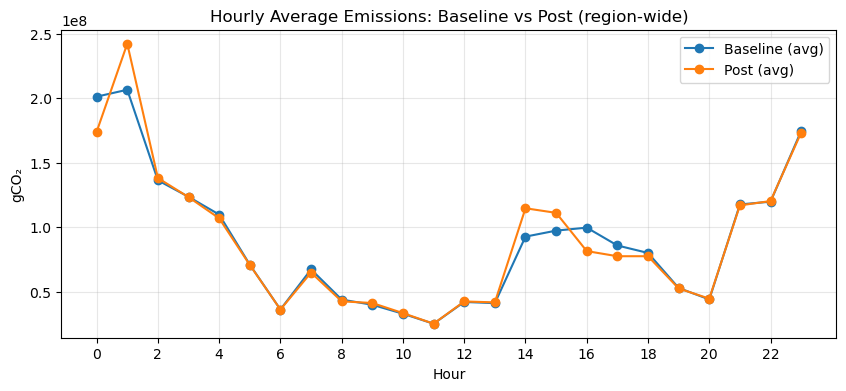

In [ ]:
avg_hour = (
    compare_em.group_by("hour")
    .agg([
        pl.sum("baseline_avg_g").alias("baseline_g"),
        pl.sum("post_avg_g").alias("post_g"),
    ])
    .sort("hour")
).to_pandas()

plt.figure(figsize=(10,4))
plt.plot(avg_hour["hour"], avg_hour["baseline_g"], marker="o", label="Baseline (avg)")
plt.plot(avg_hour["hour"], avg_hour["post_g"],     marker="o", label="Post (avg)")
plt.title("Hourly Average Emissions: Baseline vs Post (region-wide)")
plt.xlabel("Hour"); plt.ylabel("gCO₂")
plt.xticks(range(0,24,2)); plt.grid(True, alpha=0.3); plt.legend(); plt.show()


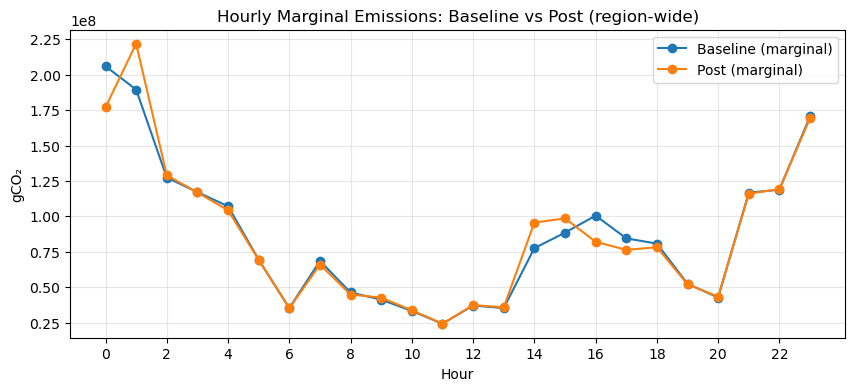

In [ ]:
marg_hour = (
    compare_em.group_by("hour")
    .agg([
        pl.sum("baseline_marg_g").alias("baseline_g"),
        pl.sum("post_marg_g").alias("post_g"),
    ])
    .sort("hour")
).to_pandas()

plt.figure(figsize=(10,4))
plt.plot(marg_hour["hour"], marg_hour["baseline_g"], marker="o", label="Baseline (marginal)")
plt.plot(marg_hour["hour"], marg_hour["post_g"],     marker="o", label="Post (marginal)")
plt.title("Hourly Marginal Emissions: Baseline vs Post (region-wide)")
plt.xlabel("Hour"); plt.ylabel("gCO₂")
plt.xticks(range(0,24,2)); plt.grid(True, alpha=0.3); plt.legend(); plt.show()


In [ ]:

def plot_hourly_prepost_two_panel(
    compare_em: pl.DataFrame | pl.LazyFrame,
    *,
    figsize=(14, 4),
    xtick_step: int = 2,
    y_min: float | None = None,
    y_max: float | None = None,
    y_formatter=None,  # None | str fmt using {x} | callable(y, pos) -> str
    suptitle: str = "Hourly emissions (Baseline vs Post): Average vs Marginal factors",
    legend_fontsize: str | int = "small",
):
    """
    Builds two side-by-side line charts:
      Left: Average EF (baseline vs post), Right: Marginal EF (baseline vs post)
    - Units on Y: tons of CO₂
    - X axis is hours (0..23) with no scientific notation
    - Custom Y limits and formatter supported
    """

    lf = compare_em.lazy() if isinstance(compare_em, pl.DataFrame) else compare_em

    # ---- aggregate to hour, convert grams -> tons ----
    avg_hour = (
        lf.group_by("hour")
          .agg([
              pl.sum("baseline_avg_g").alias("baseline_g"),
              pl.sum("post_avg_g").alias("post_g"),
          ])
          .sort("hour")
          .collect()
          .to_pandas()
    )
    avg_hour["baseline_t"] = avg_hour["baseline_g"] / 1_000_000.0
    avg_hour["post_t"]     = avg_hour["post_g"]     / 1_000_000.0

    marg_hour = (
        lf.group_by("hour")
          .agg([
              pl.sum("baseline_marg_g").alias("baseline_g"),
              pl.sum("post_marg_g").alias("post_g"),
          ])
          .sort("hour")
          .collect()
          .to_pandas()
    )
    marg_hour["baseline_t"] = marg_hour["baseline_g"] / 1_000_000.0
    marg_hour["post_t"]     = marg_hour["post_g"]     / 1_000_000.0

    # ---- y formatter ----
    if y_formatter is None:
        fmt = FuncFormatter(lambda y, _pos: f"{y:,.1f}")  # default: 1 decimal, thousands sep
    elif isinstance(y_formatter, str):
        # treat as format string using {x}
        fmt = FuncFormatter(lambda y, _pos, f=y_formatter: f.format(x=y))
    else:
        # assume callable(y, pos) -> str
        fmt = FuncFormatter(y_formatter)

    # ---- plot ----
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharex=True)
    axL, axR = axes

    # Left: Average EF
    axL.plot(avg_hour["hour"], avg_hour["baseline_t"], marker="o", label="Baseline (avg)")
    axL.plot(avg_hour["hour"], avg_hour["post_t"],     marker="o", label="Post (avg)")
    axL.set_title("Average Emission Factors")
    axL.set_xlabel("Hour")
    axL.set_ylabel("tCO₂")

    # Right: Marginal EF
    axR.plot(marg_hour["hour"], marg_hour["baseline_t"], marker="o", label="Baseline (marginal)")
    axR.plot(marg_hour["hour"], marg_hour["post_t"],     marker="o", label="Post (marginal)")
    axR.set_title("Marginal Emission Factors")
    axR.set_xlabel("Hour")
    axR.set_ylabel("tCO₂")

    # Common axis styling
    for ax in axes:
        ax.set_xticks(range(0, 24, xtick_step))
        ax.xaxis.set_minor_locator(MultipleLocator(1))
        ax.grid(True, which="major", axis="both", alpha=0.3)
        ax.grid(True, which="minor", axis="x", alpha=0.15, linestyle=":")
        # No scientific notation on either axis
        ax.ticklabel_format(style="plain", axis="both", useMathText=False)
        # Y limits & formatter
        if (y_min is not None) or (y_max is not None):
            ax.set_ylim(y_min, y_max)
        ax.yaxis.set_major_formatter(fmt)
        ax.legend(fontsize=legend_fontsize)

    fig.suptitle(suptitle, y=1.02, fontsize=12)
    fig.tight_layout()
    return fig, axes


In [ ]:
# Basic
plot_hourly_prepost_two_panel(compare_em, figsize=(12,4))

# Custom Y limits
plot_hourly_prepost_two_panel(compare_em, y_min=0, y_max=None)

# Custom Y formatter (e.g., show in kilo-tons)
plot_hourly_prepost_two_panel(
    compare_em,
    y_formatter=lambda y, pos: f"{y/1_000:,.2f} kt",
)

# Different x tick density
plot_hourly_prepost_two_panel(compare_em, xtick_step=3)


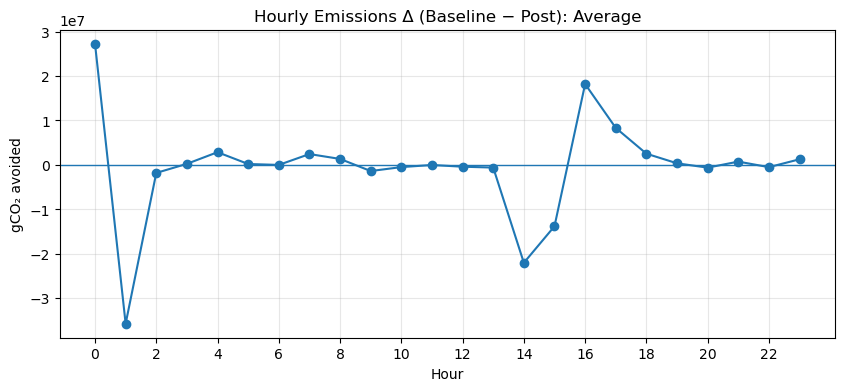

In [ ]:
avg_hour_delta = avg_hour.copy()
avg_hour_delta["delta_g"] = avg_hour_delta["baseline_g"] - avg_hour_delta["post_g"]  # + = avoided

plt.figure(figsize=(10,4))
plt.plot(avg_hour_delta["hour"], avg_hour_delta["delta_g"], marker="o")
plt.axhline(0, linewidth=1)
plt.title("Hourly Emissions Δ (Baseline − Post): Average")
plt.xlabel("Hour"); plt.ylabel("gCO₂ avoided")
plt.xticks(range(0,24,2)); plt.grid(True, alpha=0.3); plt.show()


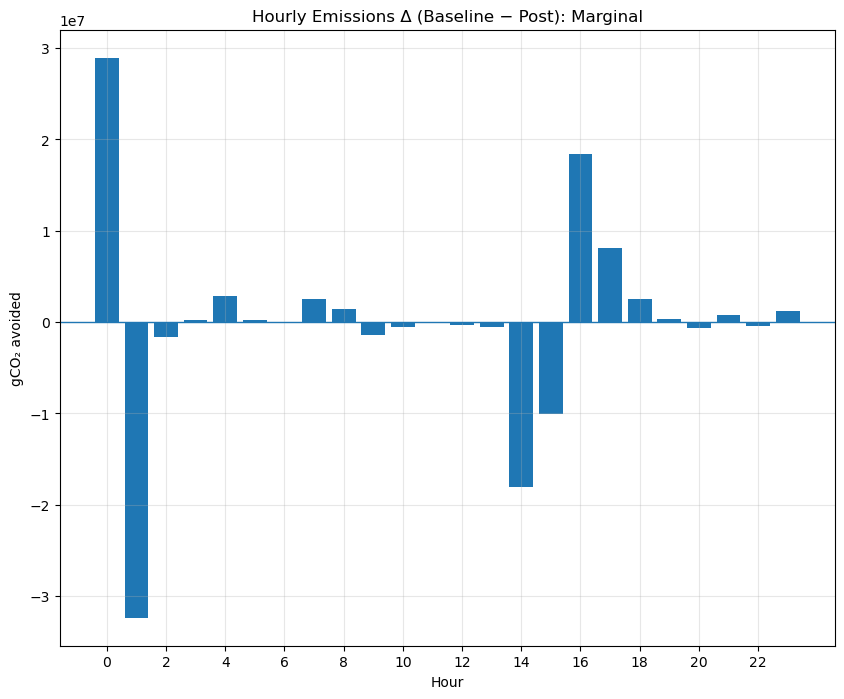

Net avoided emissions (marg): 1.87 tons
Positive avoided emissions (marg): 67.78 tons
Negative avoided emissions (marg): -65.92 tons


In [ ]:
marg_hour_delta = marg_hour.copy()
marg_hour_delta["delta_g"] = marg_hour_delta["baseline_g"] - marg_hour_delta["post_g"]  # + = avoided



plt.figure(figsize=(10,8))
plt.bar(marg_hour_delta["hour"], marg_hour_delta["delta_g"])
plt.axhline(0, linewidth=1)
plt.title("Hourly Emissions Δ (Baseline − Post): Marginal")
plt.xlabel("Hour"); plt.ylabel("gCO₂ avoided")
plt.xticks(range(0,24,2)); plt.grid(True, alpha=0.3); plt.show()

print(f"Net avoided emissions (marg): {((marg_hour_delta['delta_g'].sum()) / 1_000_000 ) :,.2f} tons")
print(f"Positive avoided emissions (marg): {((marg_hour_delta[marg_hour_delta['delta_g'] > 0]['delta_g'].sum()) / 1_000_000 ) :,.2f} tons")
print(f"Negative avoided emissions (marg): {((marg_hour_delta[marg_hour_delta['delta_g'] < 0]['delta_g'].sum()) / 1_000_000 ) :,.2f} tons")


##### Overall success of optimisation (metrics-level; marginal & average)

In [ ]:
overall = (
    metrics
    .select([
        pl.col("baseline_E_marg_g").sum().alias("baseline_marg_g"),
        pl.col("post_E_marg_g").sum().alias("post_marg_g"),
        pl.col("delta_E_marg_g").sum().alias("delta_marg_g"),  # expected baseline - post
        pl.col("baseline_E_avg_g").sum().alias("baseline_avg_g"),
        pl.col("post_E_avg_g").sum().alias("post_avg_g"),
        pl.col("delta_E_avg_g").sum().alias("delta_avg_g"),
    ])
    .with_columns([
        (pl.col("delta_marg_g") * 100 / pl.col("baseline_marg_g")).alias("pct_reduction_marginal"),
        (pl.col("delta_avg_g") * 100 / pl.col("baseline_avg_g")).alias("pct_reduction_average"),
    ])
)
overall

baseline_marg_g,post_marg_g,delta_marg_g,baseline_avg_g,post_avg_g,delta_avg_g,pct_reduction_marginal,pct_reduction_average
f64,f64,f64,f64,f64,f64,f64,f64
4.7183e9,4.6945e9,2.3820e7,4.8625e9,4.8589e9,3.5693e6,0.504852,0.073404


In [ ]:
# Share of customer-days with positive marginal reduction
share_pos_days = (
    metrics
    .with_columns((pl.col("delta_E_marg_g") > 0).alias("reduced"))
    .select(pl.col("reduced").cast(pl.Int8).mean().alias("share_days_reduced_marginal"))
)
share_pos_days

share_days_reduced_marginal
f64
0.614913


##### Rate metrics: time per customer, time per kWh moved (by city)

In [ ]:
# Note: solve_wall_s can be per ca_id/day. We build simple rates.
rates_by_city = (
    metrics
    .group_by("city")
    .agg([
        pl.len().alias("rows"),
        pl.col("n_customers_solved").sum().alias("customers_solved_sum"),
        pl.col("solve_wall_s").sum().alias("solve_time_s_sum"),
        pl.col("moved_kwh_day_sum").sum().alias("moved_kwh_sum"),
    ])
    .with_columns([
        (pl.col("customers_solved_sum") / pl.col("solve_time_s_sum")).alias("customers_per_s"),
        (pl.col("moved_kwh_sum") / pl.col("solve_time_s_sum")).alias("kwh_per_s"),
        (pl.col("solve_time_s_sum") / pl.col("customers_solved_sum")).alias("seconds_per_customer"),
        (pl.col("solve_time_s_sum") / pl.col("moved_kwh_sum")).alias("seconds_per_kwh_moved"),
    ])
    .sort("kwh_per_s", descending=True)
)
rates_by_city


city,rows,customers_solved_sum,solve_time_s_sum,moved_kwh_sum,customers_per_s,kwh_per_s,seconds_per_customer,seconds_per_kwh_moved
str,u32,f64,f64,f64,f64,f64,f64,f64
"""delhi""",537416,537413.0,188.251371,191371.511283,2854.762748,1016.574332,0.00035,0.000984


##### Savings per week per customer; savings per shift

In [ ]:
# Per-week per customer (marginal)
weekly_cust = (
    metrics
    .with_columns([
        pl.col("day").dt.strftime("%G-W%V").alias("iso_week"),  # ISO year-week
    ])
    .group_by(["city","ca_id","iso_week"])
    .agg([
        pl.col("delta_E_marg_g").sum().alias("weekly_marginal_saving_g"),
        pl.col("moved_kwh_day_sum").sum().alias("weekly_kwh_moved"),
    ])
)
weekly_cust

city,ca_id,iso_week,weekly_marginal_saving_g,weekly_kwh_moved
str,str,str,f64,f64
"""delhi""","""60014563476""","""2022-W20""",791.065036,0.0
"""delhi""","""60023204419""","""2022-W20""",457.146768,0.0
"""delhi""","""60009241633""","""2022-W20""",37.116829,0.0
"""delhi""","""60021724749""","""2022-W20""",19.643339,0.0
"""delhi""","""60024790614""","""2022-W20""",39.054136,0.0
…,…,…,…,…
"""delhi""","""60017974324""","""2022-W20""",173.75037,0.0
"""delhi""","""60007186129""","""2022-W20""",0.01129,0.0
"""delhi""","""60017467162""","""2022-W20""",0.0,0.0


In [ ]:
weekly_summary = (
    weekly_cust
    .select([
        pl.col("weekly_marginal_saving_g").mean().alias("avg_weekly_saving_g_per_customer"),
        pl.col("weekly_marginal_saving_g").median().alias("median_weekly_saving_g_per_customer"),
        pl.col("weekly_kwh_moved").mean().alias("avg_weekly_kwh_moved_per_customer"),
        pl.col("weekly_kwh_moved").median().alias("median_weekly_kwh_moved_per_customer"),
    ])
)
weekly_summary

avg_weekly_saving_g_per_customer,median_weekly_saving_g_per_customer,avg_weekly_kwh_moved_per_customer,median_weekly_kwh_moved_per_customer
f64,f64,f64,f64
132.912764,84.6597,1.067814,0.0


In [ ]:
# Per-shift savings (moves)
per_shift_summary = (
    moves_enriched
    .select([
        pl.col("marginal_emissions_delta_grams_co2").mean().alias("avg_saving_g_per_shift"),
        pl.col("marginal_emissions_delta_grams_co2").median().alias("median_saving_g_per_shift"),
        pl.col("delta_kwh").mean().alias("avg_kwh_per_shift"),
        pl.col("delta_kwh").median().alias("median_kwh_per_shift"),
    ])
)
per_shift_summary

avg_saving_g_per_shift,median_saving_g_per_shift,avg_kwh_per_shift,median_kwh_per_shift
f64,f64,f64,f64
72.081993,42.228142,0.579103,0.47


##### Average savings per shift pair (orig hour → dest hour)

In [ ]:
pair_savings = (
    moves_enriched
    .group_by(["orig_hour","dest_hour"])
    .agg([
        pl.len().alias("n_moves"),
        pl.col("marginal_emissions_delta_grams_co2").mean().alias("avg_saving_g"),
        pl.col("marginal_emissions_delta_grams_co2").median().alias("median_saving_g"),
        pl.col("delta_kwh").mean().alias("avg_kwh"),
    ])
    .sort(["avg_saving_g"], descending=True)
)
pair_savings.head(20)


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_94714/2007472144.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("n_moves"),


orig_hour,dest_hour,n_moves,avg_saving_g,median_saving_g,avg_kwh
i8,i8,u32,f64,f64,f64
16,15,36398,111.029967,101.891641,0.710679
15,14,22126,110.037219,94.669609,0.696099
15,15,3513,105.14182,92.24198,0.94483
17,15,30463,100.88811,87.872277,0.706548
16,14,55102,90.03897,63.09683,0.52905
…,…,…,…,…,…
4,2,12513,29.245446,26.581256,0.559721
10,12,11705,24.92364,12.800565,0.234824
18,17,2305,24.673672,16.9152,0.422722


/var/folders/lg/rt7jvg4x71vd57p0zm_718200000gn/T/ipykernel_94714/2360619044.py:3: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  moves_enriched


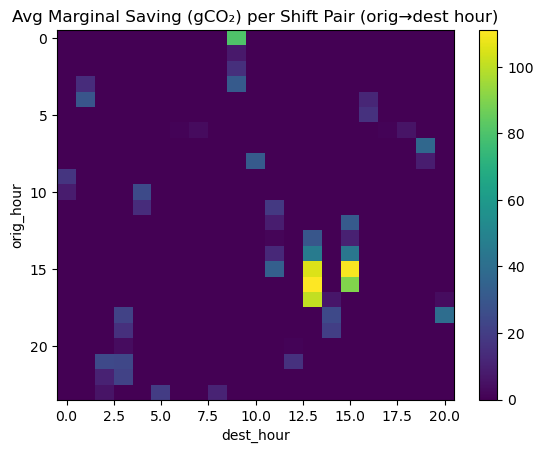

In [ ]:
# Heatmap of average marginal savings by hour pair
mat_df = (
    moves_enriched
    .group_by(["orig_hour","dest_hour"])
    .agg(pl.col("marginal_emissions_delta_grams_co2").mean().alias("avg_saving_g"))
    .pivot(values="avg_saving_g", index="orig_hour", columns="dest_hour")
    .sort("orig_hour")
)
pdf = to_pd(mat_df.fill_null(0))
plt.figure()
plt.imshow(pdf.set_index("orig_hour").to_numpy(), aspect="auto")
plt.title("Avg Marginal Saving (gCO₂) per Shift Pair (orig→dest hour)")
plt.xlabel("dest_hour")
plt.ylabel("orig_hour")
plt.colorbar()
plt.show()


##### Regional “power shifted per hour” (outgoing vs incoming)

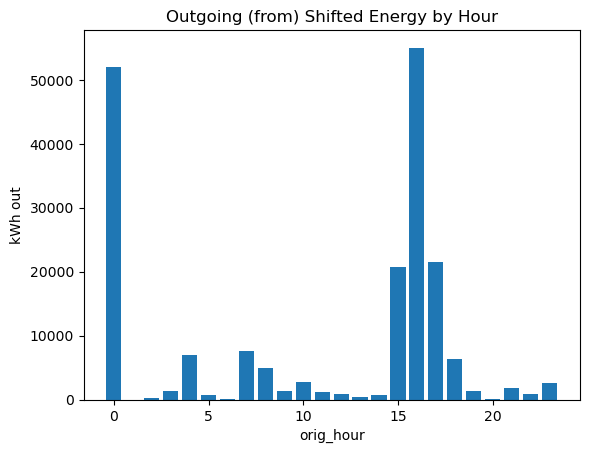

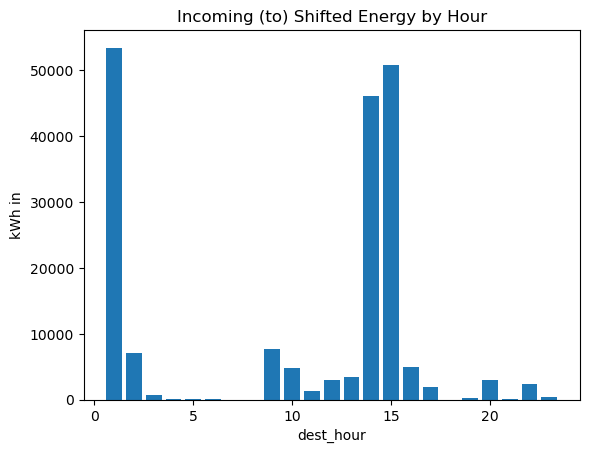

In [ ]:
# Outgoing: sum of delta_kwh by origin hour
out_per_hour = (
    moves_enriched.group_by("orig_hour")
    .agg(pl.col("delta_kwh").sum().alias("kwh_out"))
    .sort("orig_hour")
)
# Incoming: sum by destination hour
in_per_hour = (
    moves_enriched.group_by("dest_hour")
    .agg(pl.col("delta_kwh").sum().alias("kwh_in"))
    .sort("dest_hour")
)

pdf_out = to_pd(out_per_hour)
pdf_in  = to_pd(in_per_hour)

plt.figure()
plt.bar(pdf_out["orig_hour"], pdf_out["kwh_out"])
plt.title("Outgoing (from) Shifted Energy by Hour")
plt.xlabel("orig_hour")
plt.ylabel("kWh out")
plt.show()

plt.figure()
plt.bar(pdf_in["dest_hour"], pdf_in["kwh_in"])
plt.title("Incoming (to) Shifted Energy by Hour")
plt.xlabel("dest_hour")
plt.ylabel("kWh in")
plt.show()


##### (If available) Regional load by day/hour: baseline vs optimized

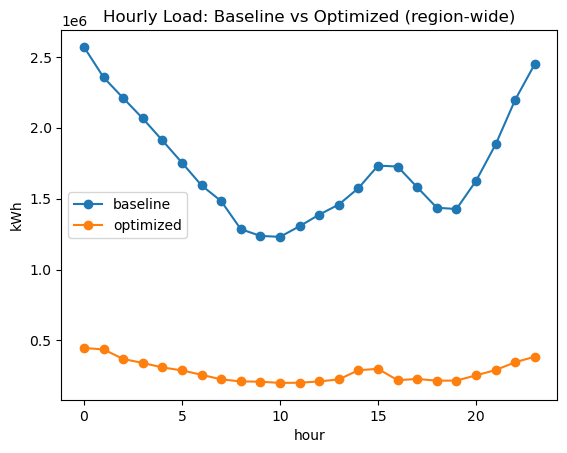

In [ ]:
# Try to guess a baseline load column in test_data
baseline_col = None
for c in ["kwh","value","baseline_value","load_kwh","meter_kwh"]:
    if c in test_data.columns:
        baseline_col = c
        break

if baseline_col is not None:
    base_day_hour = (
        test_data
        .select([
            pl.col("date").alias("ts") if "date" in test_data.columns else pl.col("timestamp").alias("ts"),
            pl.col("city"),
            pl.col(baseline_col).alias("baseline_kwh")
        ])
        .with_columns([
            pl.col("ts").dt.date().alias("day"),
            pl.col("ts").dt.hour().alias("hour"),
        ])
        .group_by(["city","day","hour"]).agg(pl.col("baseline_kwh").sum().alias("baseline_kwh"))
    )
else:
    base_day_hour = None

opt_day_hour = (
    optimised
    .select([
        pl.col("date").alias("ts"),
        pl.col("city"),
        pl.col("optimised_value").alias("opt_kwh")
    ])
    .with_columns([
        pl.col("ts").dt.date().alias("day"),
        pl.col("ts").dt.hour().alias("hour"),
    ])
    .group_by(["city","day","hour"]).agg(pl.col("opt_kwh").sum().alias("opt_kwh"))
)

if base_day_hour is not None:
    joined = (
        base_day_hour.join(opt_day_hour, on=["city","day","hour"], how="full")
                     .fill_null(0)
    )
    region_hour_delta = (
        joined.group_by(["city","hour"])
              .agg([
                   pl.col("baseline_kwh").sum().alias("baseline_kwh"),
                   pl.col("opt_kwh").sum().alias("opt_kwh"),
                   (pl.col("opt_kwh") - pl.col("baseline_kwh")).sum().alias("delta_kwh"),
              ])
              .sort("hour")
    )
    region_hour_delta.head(24)

    # Plot baseline vs optimized (aggregated across cities)
    agg_all = (
        joined.group_by(["hour"])
              .agg([
                   pl.col("baseline_kwh").sum().alias("baseline_kwh"),
                   pl.col("opt_kwh").sum().alias("opt_kwh"),
              ])
              .sort("hour")
    )
    pdf = to_pd(agg_all)
    plt.figure()
    plt.plot(pdf["hour"], pdf["baseline_kwh"], marker="o", label="baseline")
    plt.plot(pdf["hour"], pdf["opt_kwh"], marker="o", label="optimized")
    plt.title("Hourly Load: Baseline vs Optimized (region-wide)")
    plt.xlabel("hour")
    plt.ylabel("kWh")
    plt.legend()
    plt.show()
else:
    print("Baseline per-hour not found in test_data; plotted optimized distribution only.")
    pdf = to_pd(
        optimised
        .with_columns(pl.col("date").dt.hour().alias("hour"))
        .group_by("hour").agg(pl.col("optimised_value").sum().alias("opt_kwh"))
        .sort("hour")
    )
    plt.figure()
    plt.plot(pdf["hour"], pdf["opt_kwh"], marker="o")
    plt.title("Hourly Load: Optimized Only (no baseline available)")
    plt.xlabel("hour")
    plt.ylabel("kWh")
    plt.show()


##### Constraints diagnostics (weekly/daily moves, caps)

In [ ]:
# Weekly moves remaining/used summary
weekly_caps = (
    metrics
    .select([
        "city","ca_id","day",
        "weekly_moves_used","weekly_moves_remaining"
    ])
    .group_by("city")
    .agg([
        pl.col("weekly_moves_used").mean().alias("avg_weekly_moves_used"),
        pl.col("weekly_moves_remaining").mean().alias("avg_weekly_moves_remaining"),
        (pl.col("weekly_moves_remaining")==0).cast(pl.Int8).mean().alias("share_days_at_weekly_cap"),
    ])
    .sort("share_days_at_weekly_cap", descending=True)
)
weekly_caps

city,avg_weekly_moves_used,avg_weekly_moves_remaining,share_days_at_weekly_cap
str,f64,f64,f64
"""delhi""",0.614913,1.46323,0.0


In [ ]:
# Heuristic: when days hit weekly cap, did we still see high unmet 'demand' for shifts?
# Proxy: Are there many moves that are exactly at your allowed window boundary (e.g., ±120 min)?
BOUNDARY_MIN = 120
boundary_pressure = (
    moves_enriched
    .with_columns((pl.col("delta_minutes").abs() >= BOUNDARY_MIN).alias("at_boundary"))
    .group_by("city")
    .agg([
        pl.col("at_boundary").cast(pl.Int8).mean().alias("share_moves_at_time_boundary"),
    ])
    .sort("share_moves_at_time_boundary", descending=True)
)
boundary_pressure

city,share_moves_at_time_boundary
str,f64
"""delhi""",0.506067


##### Most frequent day/time slots (origin & destination) + heatmaps

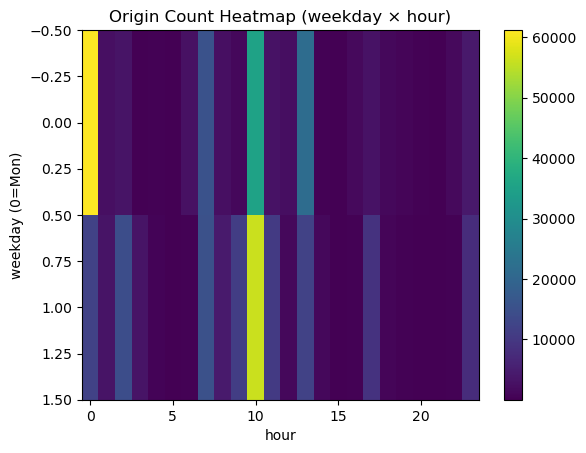

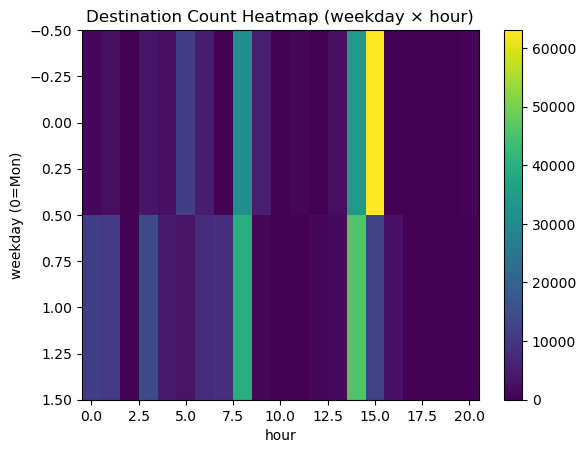

In [ ]:
# Origin day-of-week x hour heatmap
orig_grid = (
    moves_enriched
    .group_by(["orig_wday","orig_hour"]).len()
    .pivot(values="len", index="orig_wday", on="orig_hour")
    .sort("orig_wday")
    .fill_null(0)
)
pdf = to_pd(orig_grid)
plt.figure()
plt.imshow(pdf.set_index("orig_wday").to_numpy(), aspect="auto")
plt.title("Origin Count Heatmap (weekday × hour)")
plt.xlabel("hour")
plt.ylabel("weekday (0=Mon)")
plt.colorbar()
plt.show()

# Destination day-of-week x hour heatmap
dest_grid = (
    moves_enriched
    .group_by(["dest_wday","dest_hour"]).len()
    .pivot(values="len", index="dest_wday", on="dest_hour")
    .sort("dest_wday")
    .fill_null(0)
)
pdf = to_pd(dest_grid)
plt.figure()
plt.imshow(pdf.set_index("dest_wday").to_numpy(), aspect="auto")
plt.title("Destination Count Heatmap (weekday × hour)")
plt.xlabel("hour")
plt.ylabel("weekday (0=Mon)")
plt.colorbar()
plt.show()


##### Hourly histograms with grouping (no manual colors; default matplotlib palette)

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl

# starting point: moves_enriched from earlier steps
# (must already have: orig_hour, dest_hour, orig_wday, dest_wday)
moves_prof = (
    moves_enriched
    .with_columns([
        pl.col("original_time").dt.date().alias("orig_date"),
        pl.col("proposed_shift_time").dt.date().alias("dest_date"),
    ])
    .filter(pl.col("delta_kwh") > 0)  # only actual moved energy
)

hours = np.arange(24)
wd_names = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

def _series24(pdf, hour_col, value_col):
    """Return a length-24 numpy array (0..23) with zeros for missing hours."""
    s = pdf.set_index(hour_col)[value_col].reindex(range(24), fill_value=0.0)
    return s.values.astype(float)

from matplotlib.ticker import FuncFormatter

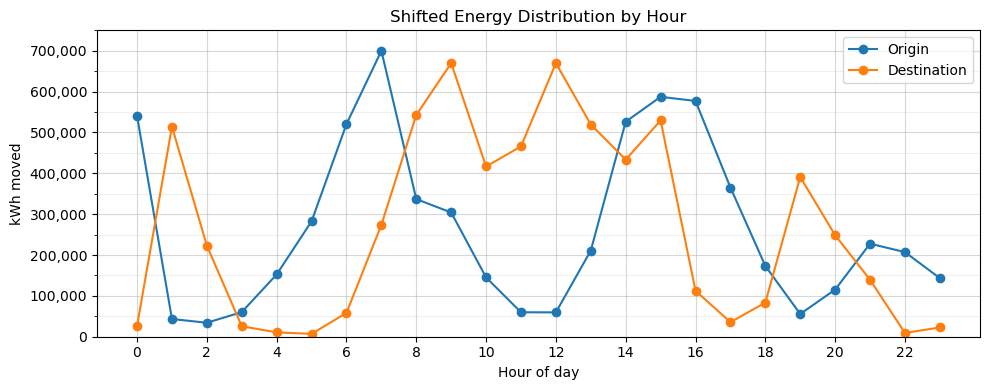

In [180]:
# Sum kWh moved *from* origin-hour and *to* destination-hour
orig_hourly = (
    moves_prof.group_by("orig_hour")
    .agg(pl.col("delta_kwh").sum().alias("kwh_out"))
    .sort("orig_hour")
).to_pandas()

dest_hourly = (
    moves_prof.group_by("dest_hour")
    .agg(pl.col("delta_kwh").sum().alias("kwh_in"))
    .sort("dest_hour")
).to_pandas()

y_out = _series24(orig_hourly, "orig_hour", "kwh_out")
y_in  = _series24(dest_hourly, "dest_hour", "kwh_in")

plt.figure(figsize=(10,4))
plt.plot(hours, y_out, marker="o", label="Origin", color="tab:blue")
plt.plot(hours, y_in,  marker="o", label="Destination", color="tab:orange")
plt.title("Shifted Energy Distribution by Hour")
plt.xlabel("Hour of day")
plt.ylabel("kWh moved")
plt.ylim(0, 750_000)

ax = plt.gca()
# Set custom formatter for thousands separators
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f"{y:,.0f}"))

# Set major and minor ticks as requested
major_ticks = range(0, 800000, 100000)  # Major ticks every 200,000
minor_ticks = range(0, 800000, 50000)   # Minor ticks every 50,000

plt.yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# Set grid lines
ax.grid(True, which='major', alpha=0.5)
ax.grid(True, which='minor', alpha=0.2)

plt.xticks(range(0,24,2))
plt.legend()
plt.tight_layout()
plt.show()

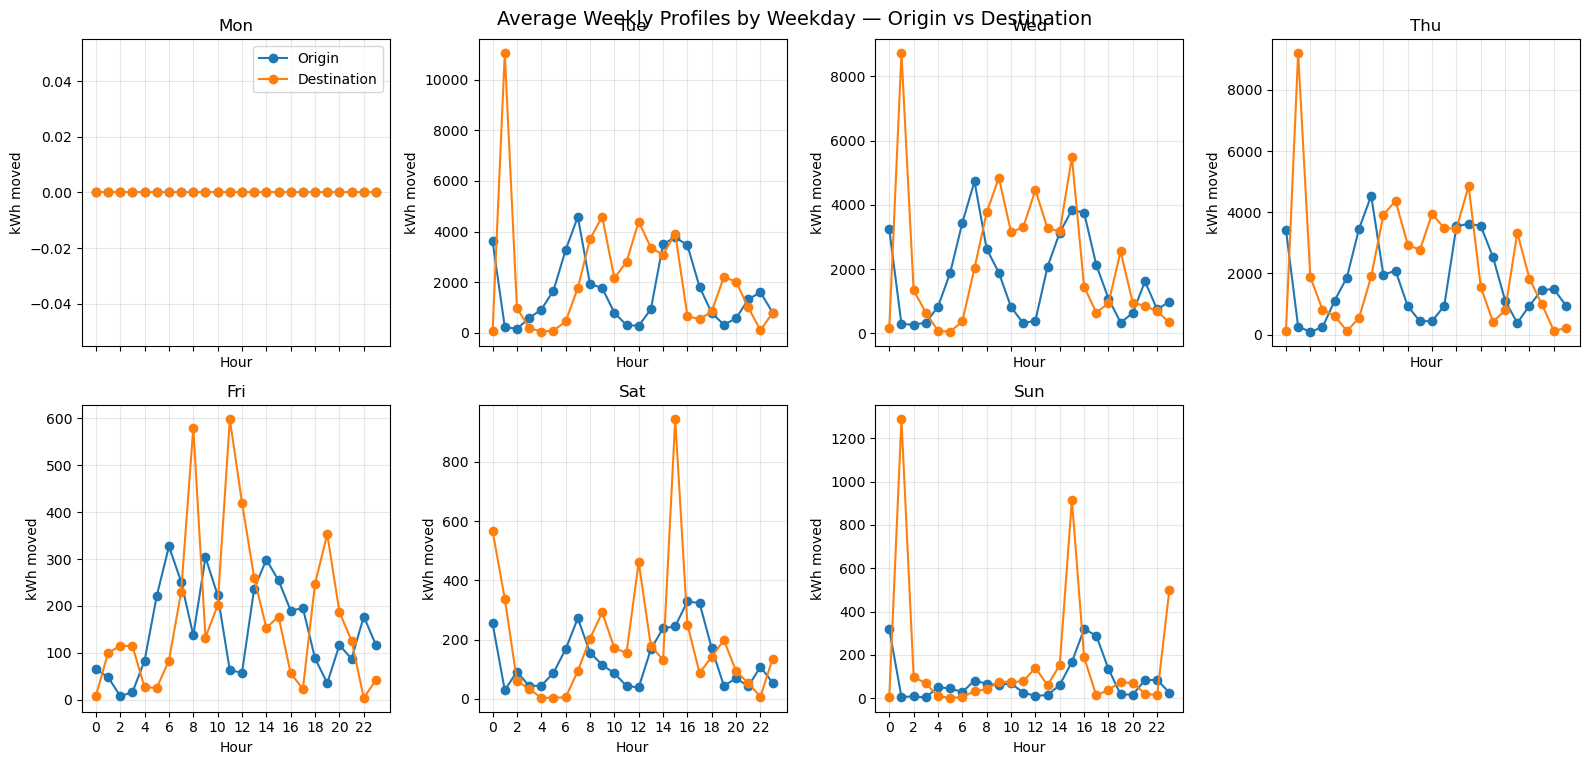

In [163]:
# 1) Build per-day hourly sums for origin/destination separately
orig_daily = (
    moves_prof
    .group_by(["orig_wday","orig_date","orig_hour"])
    .agg(pl.col("delta_kwh").sum().alias("kwh_out_daily"))
)
dest_daily = (
    moves_prof
    .group_by(["dest_wday","dest_date","dest_hour"])
    .agg(pl.col("delta_kwh").sum().alias("kwh_in_daily"))
)

# 2) Average across days within the same weekday
orig_avg = (
    orig_daily
    .group_by(["orig_wday","orig_hour"])
    .agg(pl.col("kwh_out_daily").mean().alias("avg_kwh_out"))
).to_pandas()

dest_avg = (
    dest_daily
    .group_by(["dest_wday","dest_hour"])
    .agg(pl.col("kwh_in_daily").mean().alias("avg_kwh_in"))
).to_pandas()

# 3) Plot 2x4 grid
normalize_shapes = False  # set True to compare shapes (area=1) instead of magnitudes

fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
for i, wd in enumerate(range(7)):
    r = 0 if i < 4 else 1
    c = i % 4
    ax = axes[r, c]

    # slice this weekday
    o_pdf = orig_avg[orig_avg["orig_wday"] == wd].rename(columns={"orig_hour":"hour"})
    d_pdf = dest_avg[dest_avg["dest_wday"] == wd].rename(columns={"dest_hour":"hour"})

    y_out = _series24(o_pdf, "hour", "avg_kwh_out")
    y_in  = _series24(d_pdf, "hour", "avg_kwh_in")

    if normalize_shapes:
        y_out = y_out / y_out.sum() if y_out.sum() else y_out
        y_in  = y_in  / y_in.sum()  if y_in.sum()  else y_in

    ax.plot(hours, y_out, marker="o", label="Origin", color="tab:blue")
    ax.plot(hours, y_in,  marker="o", label="Destination", color="tab:orange")
    ax.set_title(f"{wd_names[wd]}")
    ax.set_xlabel("Hour")
    ax.set_ylabel("kWh moved" if not normalize_shapes else "Share of kWh")
    ax.set_xticks(range(0,24,2))
    ax.grid(True, alpha=0.3)
    if wd == 0:  # only show legend once
        ax.legend()

# Hide the 8th (empty) subplot (row 2, col 4)
axes[1, 3].axis("off")

fig.suptitle("Average Weekly Profiles by Weekday — Origin vs Destination", y=0.95, fontsize=14)
plt.tight_layout()
plt.show()


In [160]:
# ==== Overall overlay: origin vs destination (marginal emissions Δ gCO2) ====
marg_orig_hourly = (
    moves_prof.group_by("orig_hour")
    .agg(pl.col("marginal_emissions_delta_grams_co2").sum().alias("g_out"))
    .sort("orig_hour")
).to_pandas()

marg_dest_hourly = (
    moves_prof.group_by("dest_hour")
    .agg(pl.col("marginal_emissions_delta_grams_co2").sum().alias("g_in"))
    .sort("dest_hour")
).to_pandas()

y_out = _series24(marg_orig_hourly, "orig_hour", "g_out")
y_in  = _series24(marg_dest_hourly, "dest_hour", "g_in")

plt.figure(figsize=(10,4))
plt.plot(hours, y_out, marker="o", label="Origin (Δ gCO₂ out)")
plt.plot(hours, y_in,  marker="o", label="Destination (Δ gCO₂ in)")
plt.title("Shifted Marginal Emissions by Hour (Overall)")
plt.xlabel("Hour of day")
plt.ylabel("Δ gCO₂ (positive = saving)")
plt.xticks(range(0,24,2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


NameError: name 'moves_prof' is not defined

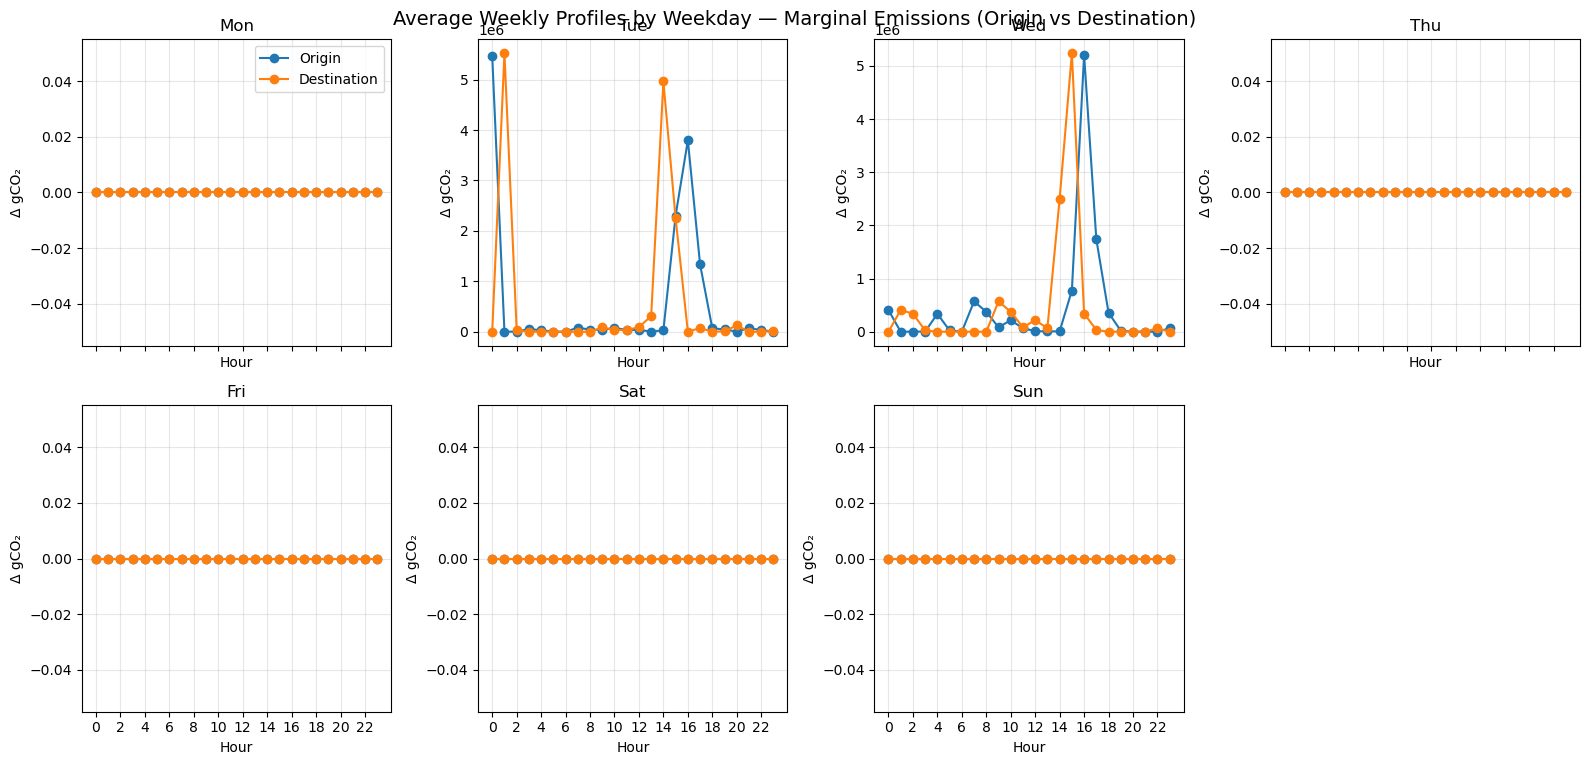

In [ ]:
# ==== 7 subplots: average weekly profiles (Mon–Sun); origin vs destination ====
# Per-day (date, hour) sums, then average across days for each weekday
marg_orig_daily = (
    moves_prof
    .group_by(["orig_wday","orig_date","orig_hour"])
    .agg(pl.col("marginal_emissions_delta_grams_co2").sum().alias("g_out_daily"))
)
marg_dest_daily = (
    moves_prof
    .group_by(["dest_wday","dest_date","dest_hour"])
    .agg(pl.col("marginal_emissions_delta_grams_co2").sum().alias("g_in_daily"))
)

marg_orig_avg = (
    marg_orig_daily
    .group_by(["orig_wday","orig_hour"])
    .agg(pl.col("g_out_daily").mean().alias("avg_g_out"))
).to_pandas()

marg_dest_avg = (
    marg_dest_daily
    .group_by(["dest_wday","dest_hour"])
    .agg(pl.col("g_in_daily").mean().alias("avg_g_in"))
).to_pandas()

normalize_shapes = False  # set True to compare shapes instead of magnitudes

fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
for i, wd in enumerate(range(7)):
    r = 0 if i < 4 else 1
    c = i % 4
    ax = axes[r, c]

    o_pdf = marg_orig_avg[marg_orig_avg["orig_wday"] == wd].rename(columns={"orig_hour":"hour"})
    d_pdf = marg_dest_avg[marg_dest_avg["dest_wday"] == wd].rename(columns={"dest_hour":"hour"})

    y_out = _series24(o_pdf, "hour", "avg_g_out")
    y_in  = _series24(d_pdf, "hour", "avg_g_in")

    if normalize_shapes:
        y_out = y_out / y_out.sum() if y_out.sum() else y_out
        y_in  = y_in  / y_in.sum()  if y_in.sum()  else y_in

    ax.plot(hours, y_out, marker="o", label="Origin")
    ax.plot(hours, y_in,  marker="o", label="Destination")
    ax.set_title(wd_names[wd])
    ax.set_xlabel("Hour")
    ax.set_ylabel("Δ gCO₂" if not normalize_shapes else "Share of Δ gCO₂")
    ax.set_xticks(range(0,24,2))
    ax.grid(True, alpha=0.3)
    if wd == 0:
        ax.legend()

axes[1,3].axis("off")  # hide empty panel
fig.suptitle("Average Weekly Profiles by Weekday — Marginal Emissions (Origin vs Destination)", y=0.95, fontsize=14)
plt.tight_layout()
plt.show()


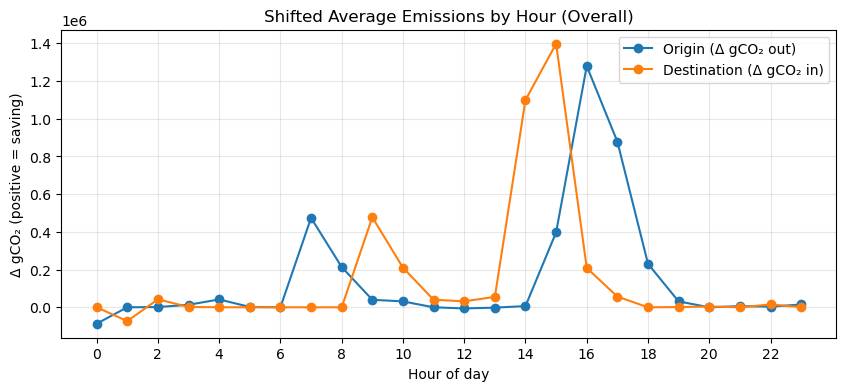

In [ ]:
# ==== Overall overlay: origin vs destination (average emissions Δ gCO2) ====
avg_orig_hourly = (
    moves_prof.group_by("orig_hour")
    .agg(pl.col("average_emissions_delta_grams_co2").sum().alias("g_out"))
    .sort("orig_hour")
).to_pandas()

avg_dest_hourly = (
    moves_prof.group_by("dest_hour")
    .agg(pl.col("average_emissions_delta_grams_co2").sum().alias("g_in"))
    .sort("dest_hour")
).to_pandas()

y_out = _series24(avg_orig_hourly, "orig_hour", "g_out")
y_in  = _series24(avg_dest_hourly, "dest_hour", "g_in")

plt.figure(figsize=(10,4))
plt.plot(hours, y_out, marker="o", label="Origin (Δ gCO₂ out)")
plt.plot(hours, y_in,  marker="o", label="Destination (Δ gCO₂ in)")
plt.title("Shifted Average Emissions by Hour (Overall)")
plt.xlabel("Hour of day")
plt.ylabel("Δ gCO₂ (positive = saving)")
plt.xticks(range(0,24,2))
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


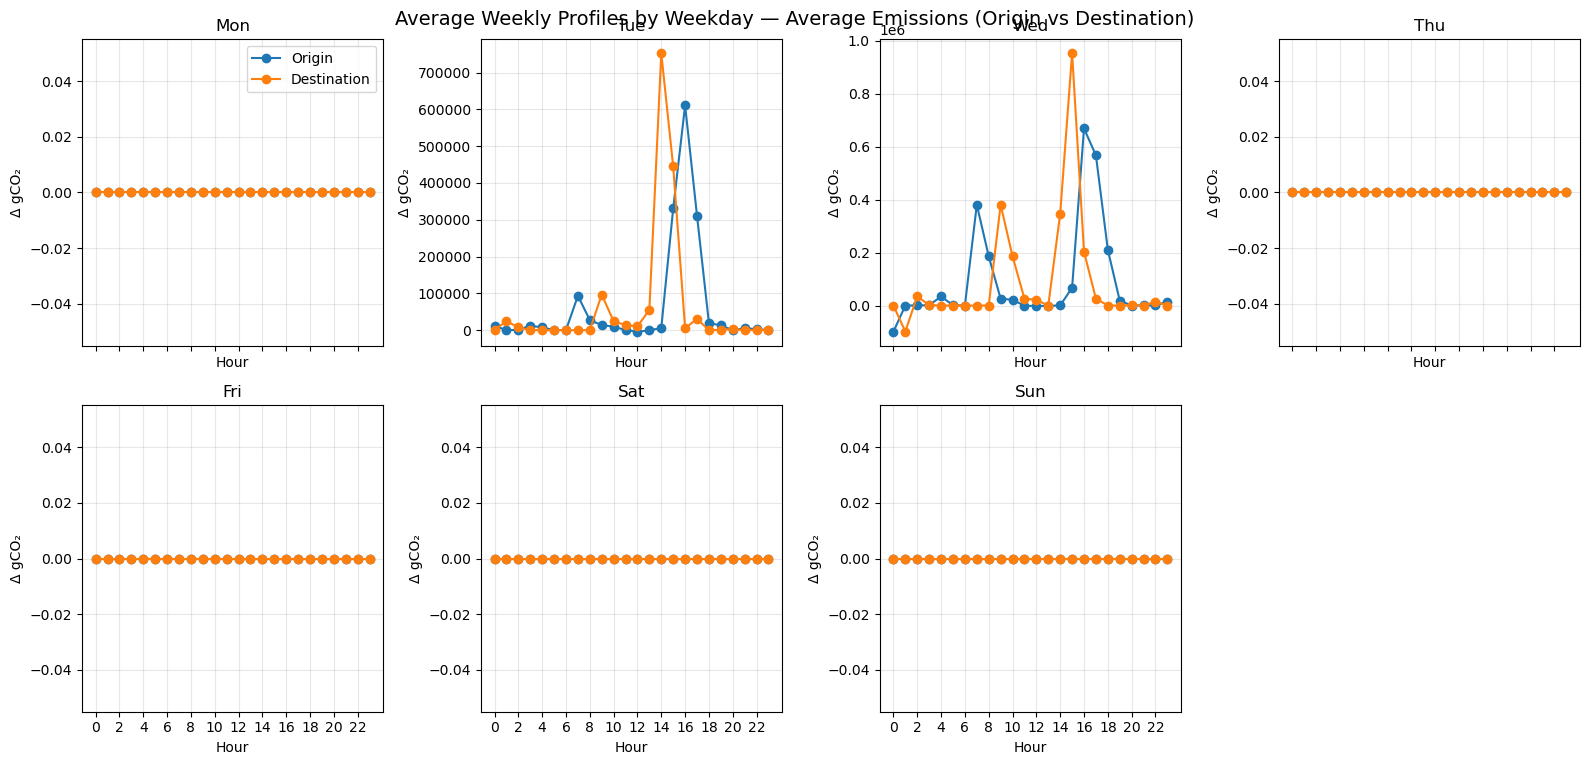

In [ ]:
# ==== 7 subplots: average weekly profiles (Mon–Sun); origin vs destination ====
avg_orig_daily = (
    moves_prof
    .group_by(["orig_wday","orig_date","orig_hour"])
    .agg(pl.col("average_emissions_delta_grams_co2").sum().alias("g_out_daily"))
)
avg_dest_daily = (
    moves_prof
    .group_by(["dest_wday","dest_date","dest_hour"])
    .agg(pl.col("average_emissions_delta_grams_co2").sum().alias("g_in_daily"))
)

avg_orig_avg = (
    avg_orig_daily
    .group_by(["orig_wday","orig_hour"])
    .agg(pl.col("g_out_daily").mean().alias("avg_g_out"))
).to_pandas()

avg_dest_avg = (
    avg_dest_daily
    .group_by(["dest_wday","dest_hour"])
    .agg(pl.col("g_in_daily").mean().alias("avg_g_in"))
).to_pandas()

normalize_shapes = False  # set True to compare shapes instead of magnitudes

fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True)
for i, wd in enumerate(range(7)):
    r = 0 if i < 4 else 1
    c = i % 4
    ax = axes[r, c]

    o_pdf = avg_orig_avg[avg_orig_avg["orig_wday"] == wd].rename(columns={"orig_hour":"hour"})
    d_pdf = avg_dest_avg[avg_dest_avg["dest_wday"] == wd].rename(columns={"dest_hour":"hour"})

    y_out = _series24(o_pdf, "hour", "avg_g_out")
    y_in  = _series24(d_pdf, "hour", "avg_g_in")

    if normalize_shapes:
        y_out = y_out / y_out.sum() if y_out.sum() else y_out
        y_in  = y_in  / y_in.sum()  if y_in.sum()  else y_in

    ax.plot(hours, y_out, marker="o", label="Origin")
    ax.plot(hours, y_in,  marker="o", label="Destination")
    ax.set_title(wd_names[wd])
    ax.set_xlabel("Hour")
    ax.set_ylabel("Δ gCO₂" if not normalize_shapes else "Share of Δ gCO₂")
    ax.set_xticks(range(0,24,2))
    ax.grid(True, alpha=0.3)
    if wd == 0:
        ax.legend()

axes[1,3].axis("off")  # hide empty panel
fig.suptitle("Average Weekly Profiles by Weekday — Average Emissions (Origin vs Destination)", y=0.95, fontsize=14)
plt.tight_layout()
plt.show()


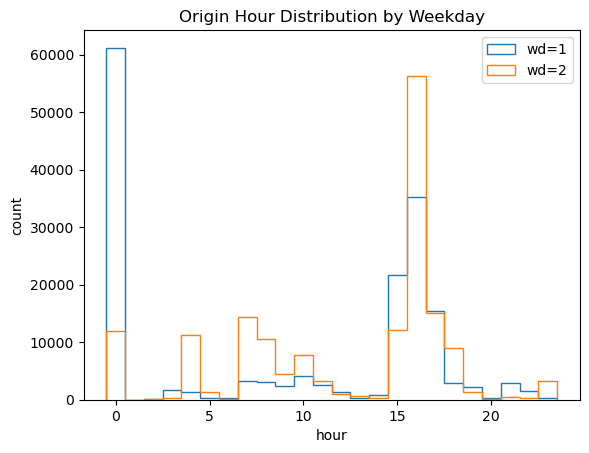

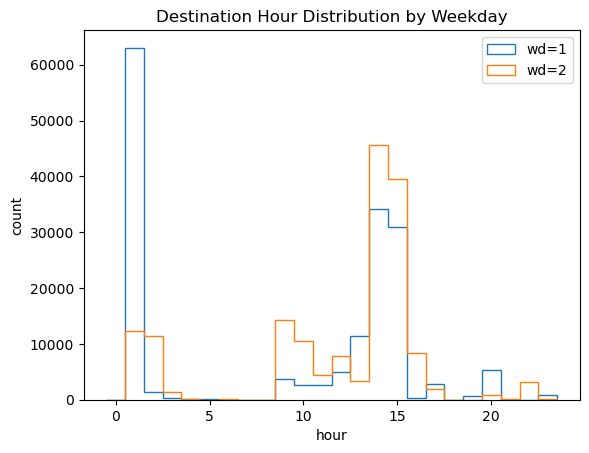

In [ ]:
# By weekday (orig)
pdf = to_pd(moves_enriched.select(["orig_wday","orig_hour"]))
plt.figure()
for wd in sorted(pdf["orig_wday"].unique()):
    arr = pdf.loc[pdf["orig_wday"]==wd, "orig_hour"].values
    plt.hist(arr, bins=np.arange(-0.5,24.5,1), histtype="step", label=f"wd={wd}")
plt.title("Origin Hour Distribution by Weekday")
plt.xlabel("hour")
plt.ylabel("count")
plt.legend()
plt.show()

# By hour (dest) but grouped by weekday series
pdf = to_pd(moves_enriched.select(["dest_wday","dest_hour"]))
plt.figure()
for wd in sorted(pdf["dest_wday"].unique()):
    arr = pdf.loc[pdf["dest_wday"]==wd, "dest_hour"].values
    plt.hist(arr, bins=np.arange(-0.5,24.5,1), histtype="step", label=f"wd={wd}")
plt.title("Destination Hour Distribution by Weekday")
plt.xlabel("hour")
plt.ylabel("count")
plt.legend()
plt.show()


##### Top contributors & tail risk

In [ ]:
# Customers contributing most to marginal savings
top_cust = (
    moves_enriched
    .group_by(["city","ca_id"])
    .agg(pl.col("marginal_emissions_delta_grams_co2").sum().alias("total_saving_g"))
    .sort("total_saving_g", descending=True)
    .head(20)
)
top_cust

share_moves_worse_marginal
f64
0.0


In [ ]:
# Share of moves that worsened marginal emissions
worsened_share = (
    moves_enriched
    .with_columns((pl.col("marginal_emissions_delta_grams_co2") < 0).alias("worse"))
    .select(pl.col("worse").cast(pl.Int8).mean().alias("share_moves_worse_marginal"))
)
worsened_share

##### Shift distance diagnostics (in minutes)

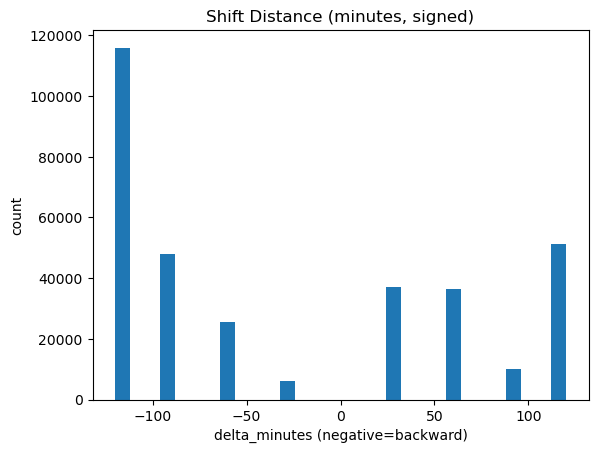

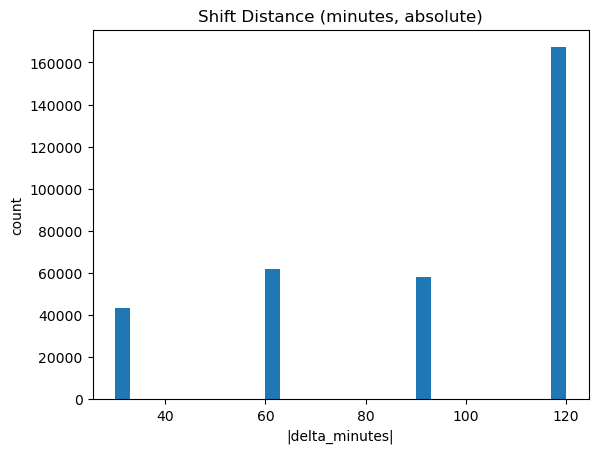

In [ ]:
pdf = to_pd(moves_enriched.select("delta_minutes"))
plt.figure()
plt.hist(pdf["delta_minutes"], bins=30)
plt.title("Shift Distance (minutes, signed)")
plt.xlabel("delta_minutes (negative=backward)")
plt.ylabel("count")
plt.show()

pdf_abs = np.abs(pdf["delta_minutes"].values)
plt.figure()
plt.hist(pdf_abs, bins=30)
plt.title("Shift Distance (minutes, absolute)")
plt.xlabel("|delta_minutes|")
plt.ylabel("count")
plt.show()


##### Regional “power shifted per hour” (outgoing vs incoming)

##### Regional “power shifted per hour” (outgoing vs incoming)